# Methods for Data Science: Course Work 2

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)

In [494]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from tqdm import tqdm

In [495]:
# set default parameters for notebook
# set dpi to 300
plt.rcParams['figure.dpi'] = 300
# set figsize to (6, 6)
plt.rcParams['figure.figsize'] = (9, 6)
# hide gridlines behind the plot
plt.rcParams['axes.axisbelow'] = True
# set gridlines to dashed
plt.rcParams['grid.linestyle'] = '--'
# set gridlines to light grey
plt.rcParams['grid.color'] = 'lightgrey'
# turn gridlines on by default
plt.rcParams['axes.grid'] = True

#### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

1.1.1

In [496]:
MNIST_train = pd.read_csv('data/MNIST_train.csv')
MNIST_test = pd.read_csv('data/MNIST_test.csv')

MNIST_train_labels = MNIST_train['label'].to_numpy()
MNIST_train_samples = MNIST_train.drop('label', axis=1).to_numpy()
MNIST_test_labels = MNIST_test['label'].to_numpy()
MNIST_test_samples = MNIST_test.drop('label', axis=1).to_numpy()

In [497]:
def normalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [498]:
## standardise the data

MNIST_train_samples = MNIST_train_samples/255
MNIST_test_samples = MNIST_test_samples/255
#MNIST_train_samples = normalize(MNIST_train_samples)
#MNIST_test_samples = normalize(MNIST_test_samples)



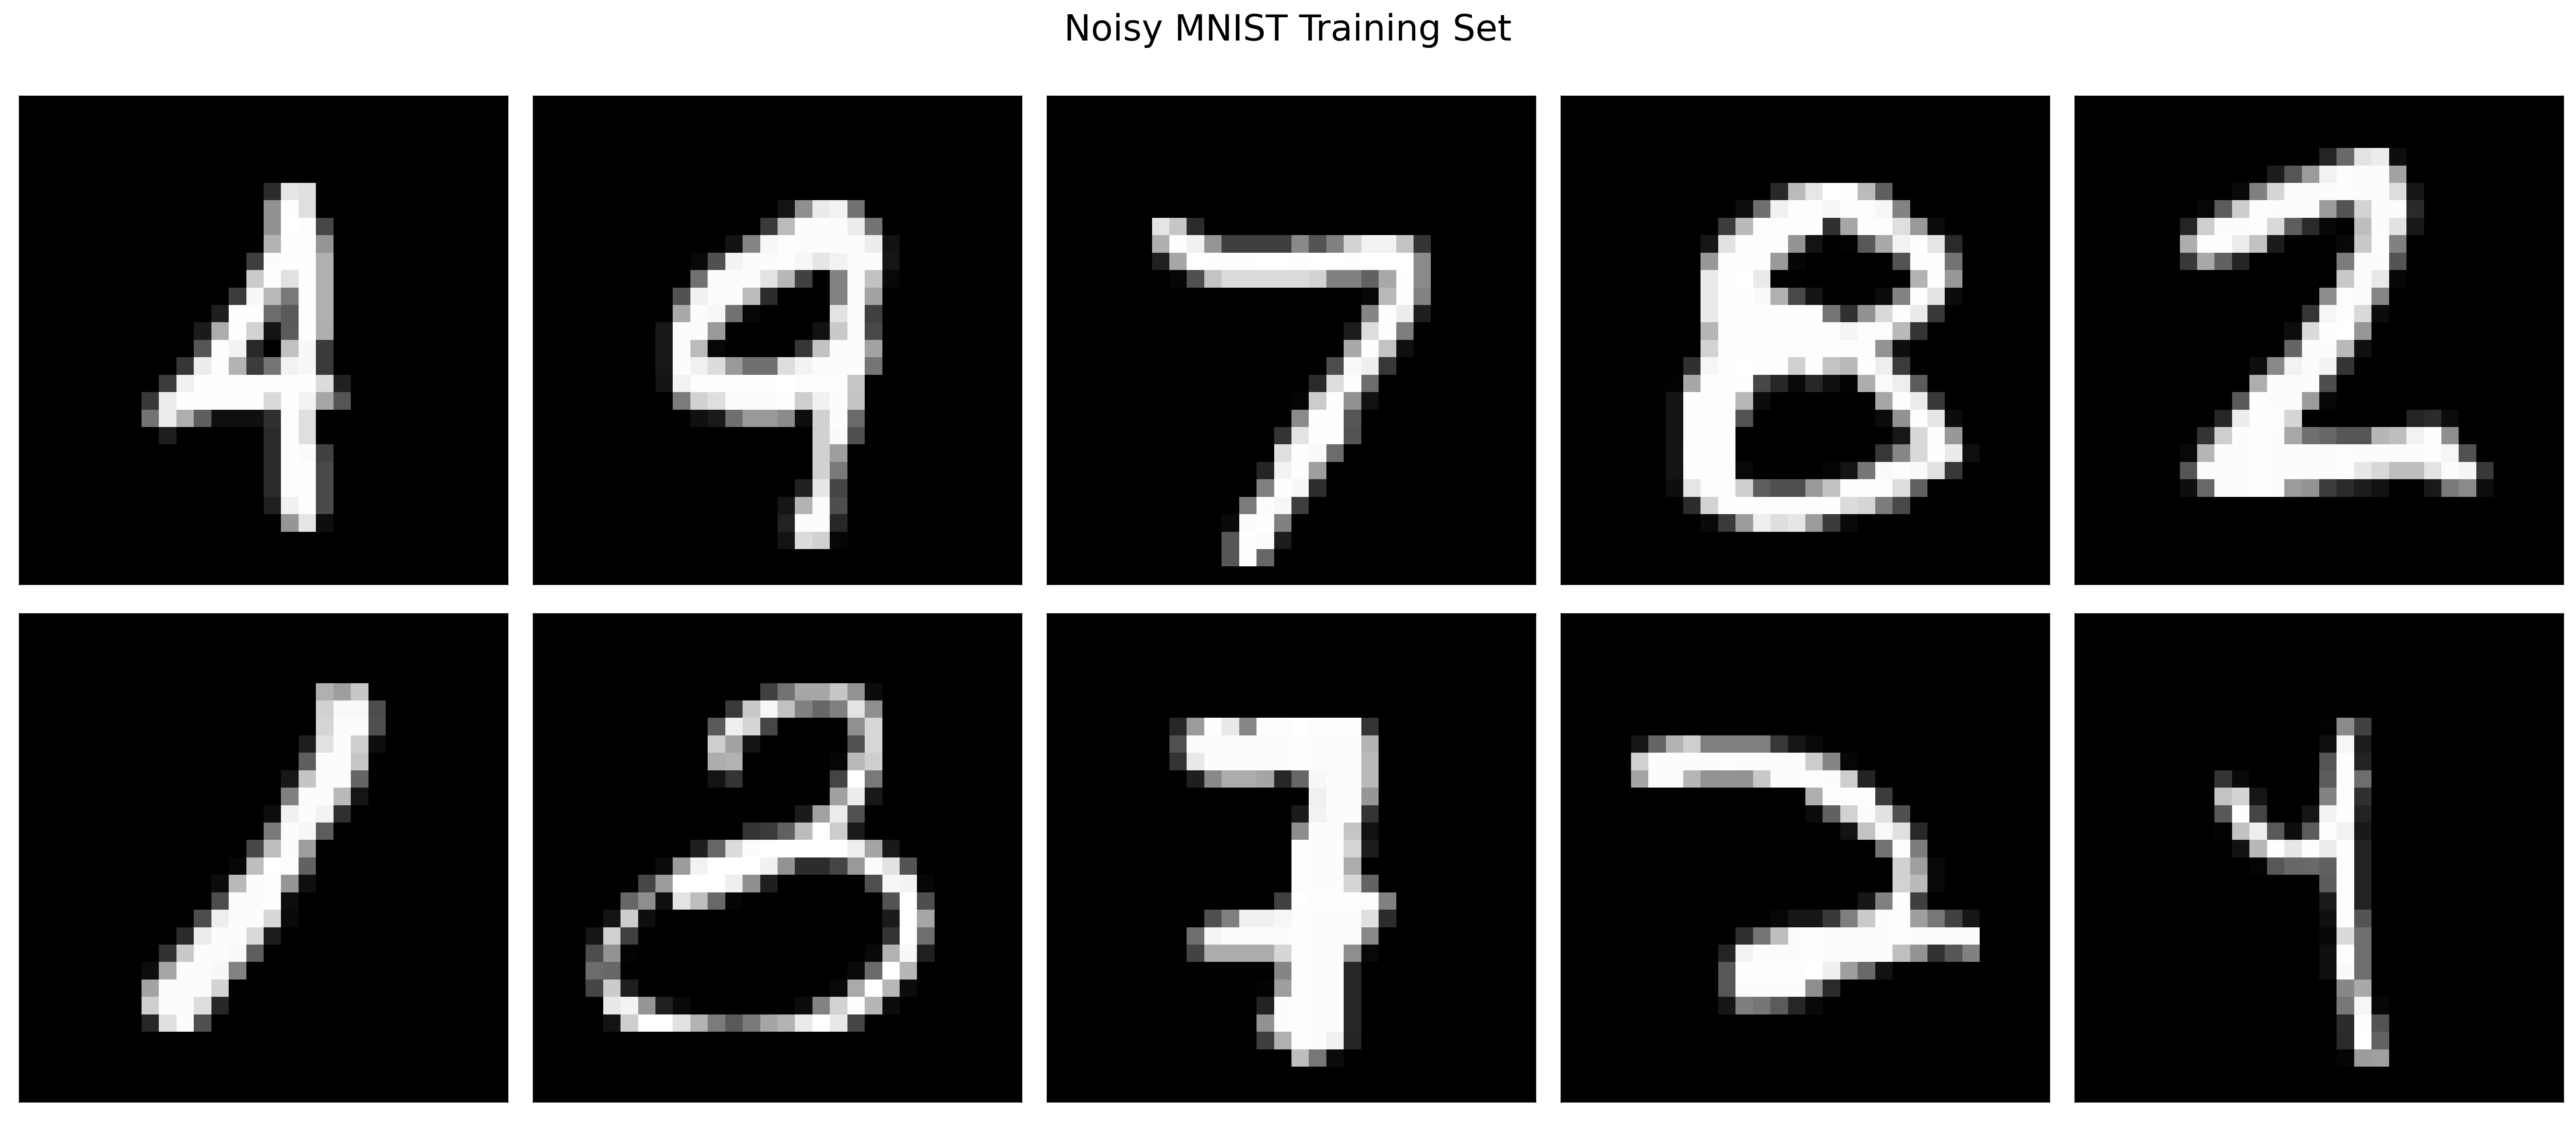

In [632]:

fig, axs = plt.subplots(2, 5, figsize=(20, 9))

for ax in axs:
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        a.grid(False)

for i in range(2):
    for j in range(5):
        axs[i, j].imshow(MNIST_train_samples[i*5 + j].reshape(28, 28), cmap="gray")


fig.suptitle("Noisy MNIST Training Set", fontsize=20)
fig.tight_layout()
plt.show()

In [500]:
def softplus(x, beta=1.0):
    if np.isnan(np.exp(x)).any():
        raise NotImplementedError
    return np.log(1 + np.exp(beta * x))

def softplus_derivative(x, beta=1.0):
    return 1/(1 + np.exp(-beta * x))

In [501]:
def softmax(x):
    x = x.squeeze()
    x = x.reshape(-1,1)
    exps = np.exp(x-np.max(x))
    return exps / np.sum(exps).reshape(-1,1)

In [502]:
def softmax_derivative(x):
    x = x.squeeze()
    x = x.reshape(1,-1)
    s_x = softmax(x).squeeze()
    return np.diag(s_x)- np.outer(s_x, s_x)    


$$
KL(y,\hat{y}) = \sum_{i=1}^{n} y_i \log y_i - \sum_{i=1}^{n} y_i \log \hat{y}_i = - \sum_{i=1}^{n} y_i \log \hat{y}_i
$$

In [503]:
def nan_xlogy(x, y):
    if x==0:
        return 0
    return x*np.log(y)

In [504]:
def kl_divergence(y_pred, true_label, eps=1e-10):
    y_pred_nonzero = np.copy(y_pred) + eps
    label_vector = np.zeros(y_pred_nonzero.shape[0])
    label_vector[true_label] = 1
    y_out = np.zeros((y_pred_nonzero.shape[0]))
    for i in range(y_pred_nonzero.shape[0]):
        y_out[i] = - nan_xlogy(label_vector[i], y_pred_nonzero[i])
    return y_out.sum()

In [505]:
def grad_kl_divergence(y_pred, true_label, eps=1e-10):
    y_pred_floored = y_pred + eps
    label_vector = np.zeros((10,1))
    label_vector[true_label] = 1
    return -label_vector/y_pred_floored

In [506]:
class Network():
    def __init__(self, architecture, dropout=0.0):
        self.arch = architecture
        self.num_layers = len(architecture)
        self.B = [np.zeros((l, 1)) for l in architecture[1:]]
        self.W = [np.random.randn(l, m) * np.sqrt(2/(l+m)) for l, m in zip(architecture[:-1], architecture[1:])]
        self.activations = [softplus]*(len(self.B)-1)
        self.activations.append(softmax)
        self.activation_derivatives = [softplus_derivative]*(len(self.B)-1)
        self.activation_derivatives.append(softmax_derivative)
        self.final_test_loss = 0
        self.test_losses = []
        self.train_losses = []
        self.test_accuracies = []
        self.train_accuracies = []
        self.dropout = dropout
        self.pkeep = 1-self.dropout

    def predict(self, x):
        x = x.reshape(-1, 1)
        for b, W, activation in zip(self.B, self.W, self.activations):
            x = activation(W.T @ x + b)
        return x

    def backprop(self, x, y):
        x = x.reshape(-1, 1)
        dL_dB = [np.zeros(b.shape) for b in self.B]
        dL_dW = [np.zeros(w.shape) for w in self.W]

        Z_n = []
        A_n = []
        for b, W, activation in zip(self.B, self.W, self.activations):
            dropout_m = np.random.rand(*W.shape) < self.pkeep
            W = W * dropout_m
            W = W / self.pkeep
            z = W.T @ a + b if Z_n else W.T @ x + b
            a = activation(z)
            Z_n.append(z)
            A_n.append(a)

        H = self.num_layers - 2
        for L in range(H, -1, -1):
            if L == H:
                dL_dZ = grad_kl_divergence(A_n[L], y).T @ self.activation_derivatives[L](Z_n[L])
                dL_dZ = dL_dZ.reshape(-1,1)
            else:
                dL_dZ = self.activation_derivatives[L](Z_n[L]) * (self.W[L+1] @ dL_dZ)
            dL_dB[L] = dL_dZ
            dL_dW[L] = A_n[L-1] @ dL_dZ.T if L!= 0 else x @ dL_dZ.T
        return dL_dB, dL_dW

    def sgd(self, minibatch, lr):
        dL_dB = [np.zeros(b.shape) for b in self.B]
        dL_dW = [np.zeros(w.shape) for w in self.W]
        data, labels = minibatch
        d = len(minibatch)
        for x, y in zip(data, labels):
            dL_dB_, dL_dW_ = self.backprop(x, y)
            dL_dB = [db + db_ for db, db_ in zip(dL_dB, dL_dB_)]
            dL_dW = [dw + dw_ for dw, dw_ in zip(dL_dW, dL_dW_)]
        self.W = [w - (lr/d)*dw for w, dw in zip(self.W, dL_dW)]
        self.B = [b - (lr/d)*db for b, db in zip(self.B, dL_dB)]

    def accuracy(self, test_data, test_labels):
        preds = np.asarray([np.argmax(self.predict(x)) for x in test_data])
        test_results = (preds == test_labels).mean()
        return test_results

    def loss(self, test_data, test_labels):
        test_results = [kl_divergence(self.predict(x), y) for x, y in zip(test_data, test_labels)]
        return sum(test_results)/len(test_data)
    
    def train(self, train_data, train_labels, test_data, test_labels, epochs, batch_size, lr, verbose=False, compute_stats=False):
        n = len(train_data)
        for i in range(epochs):
            permutation = np.random.permutation(n)
            train_data_perm = train_data[permutation]
            train_labels_perm = train_labels[permutation]
            minibatches = [(train_data_perm[k:k+batch_size], train_labels_perm[k:k+batch_size]) for k in range(0, n, batch_size)]
            for minibatch in minibatches:
                self.sgd(minibatch, lr)
            if compute_stats:
                self.test_losses.append(self.loss(test_data, test_labels))
                self.test_accuracies.append(self.accuracy(test_data, test_labels))
                self.train_losses.append(self.loss(train_data, train_labels))
                self.train_accuracies.append(self.accuracy(train_data, train_labels))
            if verbose:
                print(f"Epoch {i+1} complete. Test accuracy: {self.accuracy(test_data, test_labels)}, Test loss: {self.loss(test_data, test_labels)}")
            if i == epochs-1:
                self.final_test_loss = self.loss(test_data, test_labels)
                print(f"Final test accuracy: {self.accuracy(test_data, test_labels)}, Final test loss: {self.final_test_loss}")

In [507]:
model_dict = {}

for lr in [10**-i for i in range(1, 6)]:
    model = Network([784, 200, 200, 200, 10])
    model.train(MNIST_train_samples, MNIST_train_labels, MNIST_test_samples, MNIST_test_labels, 40, 128, lr, verbose=False)
    model_dict[lr] = model

Final test accuracy: 0.1, Final test loss: 20.723265836936566
Final test accuracy: 0.952, Final test loss: 0.285975681190733
Final test accuracy: 0.912, Final test loss: 0.2537980960629232
Final test accuracy: 0.862, Final test loss: 0.444688210208979
Final test accuracy: 0.478, Final test loss: 2.1986461375902357


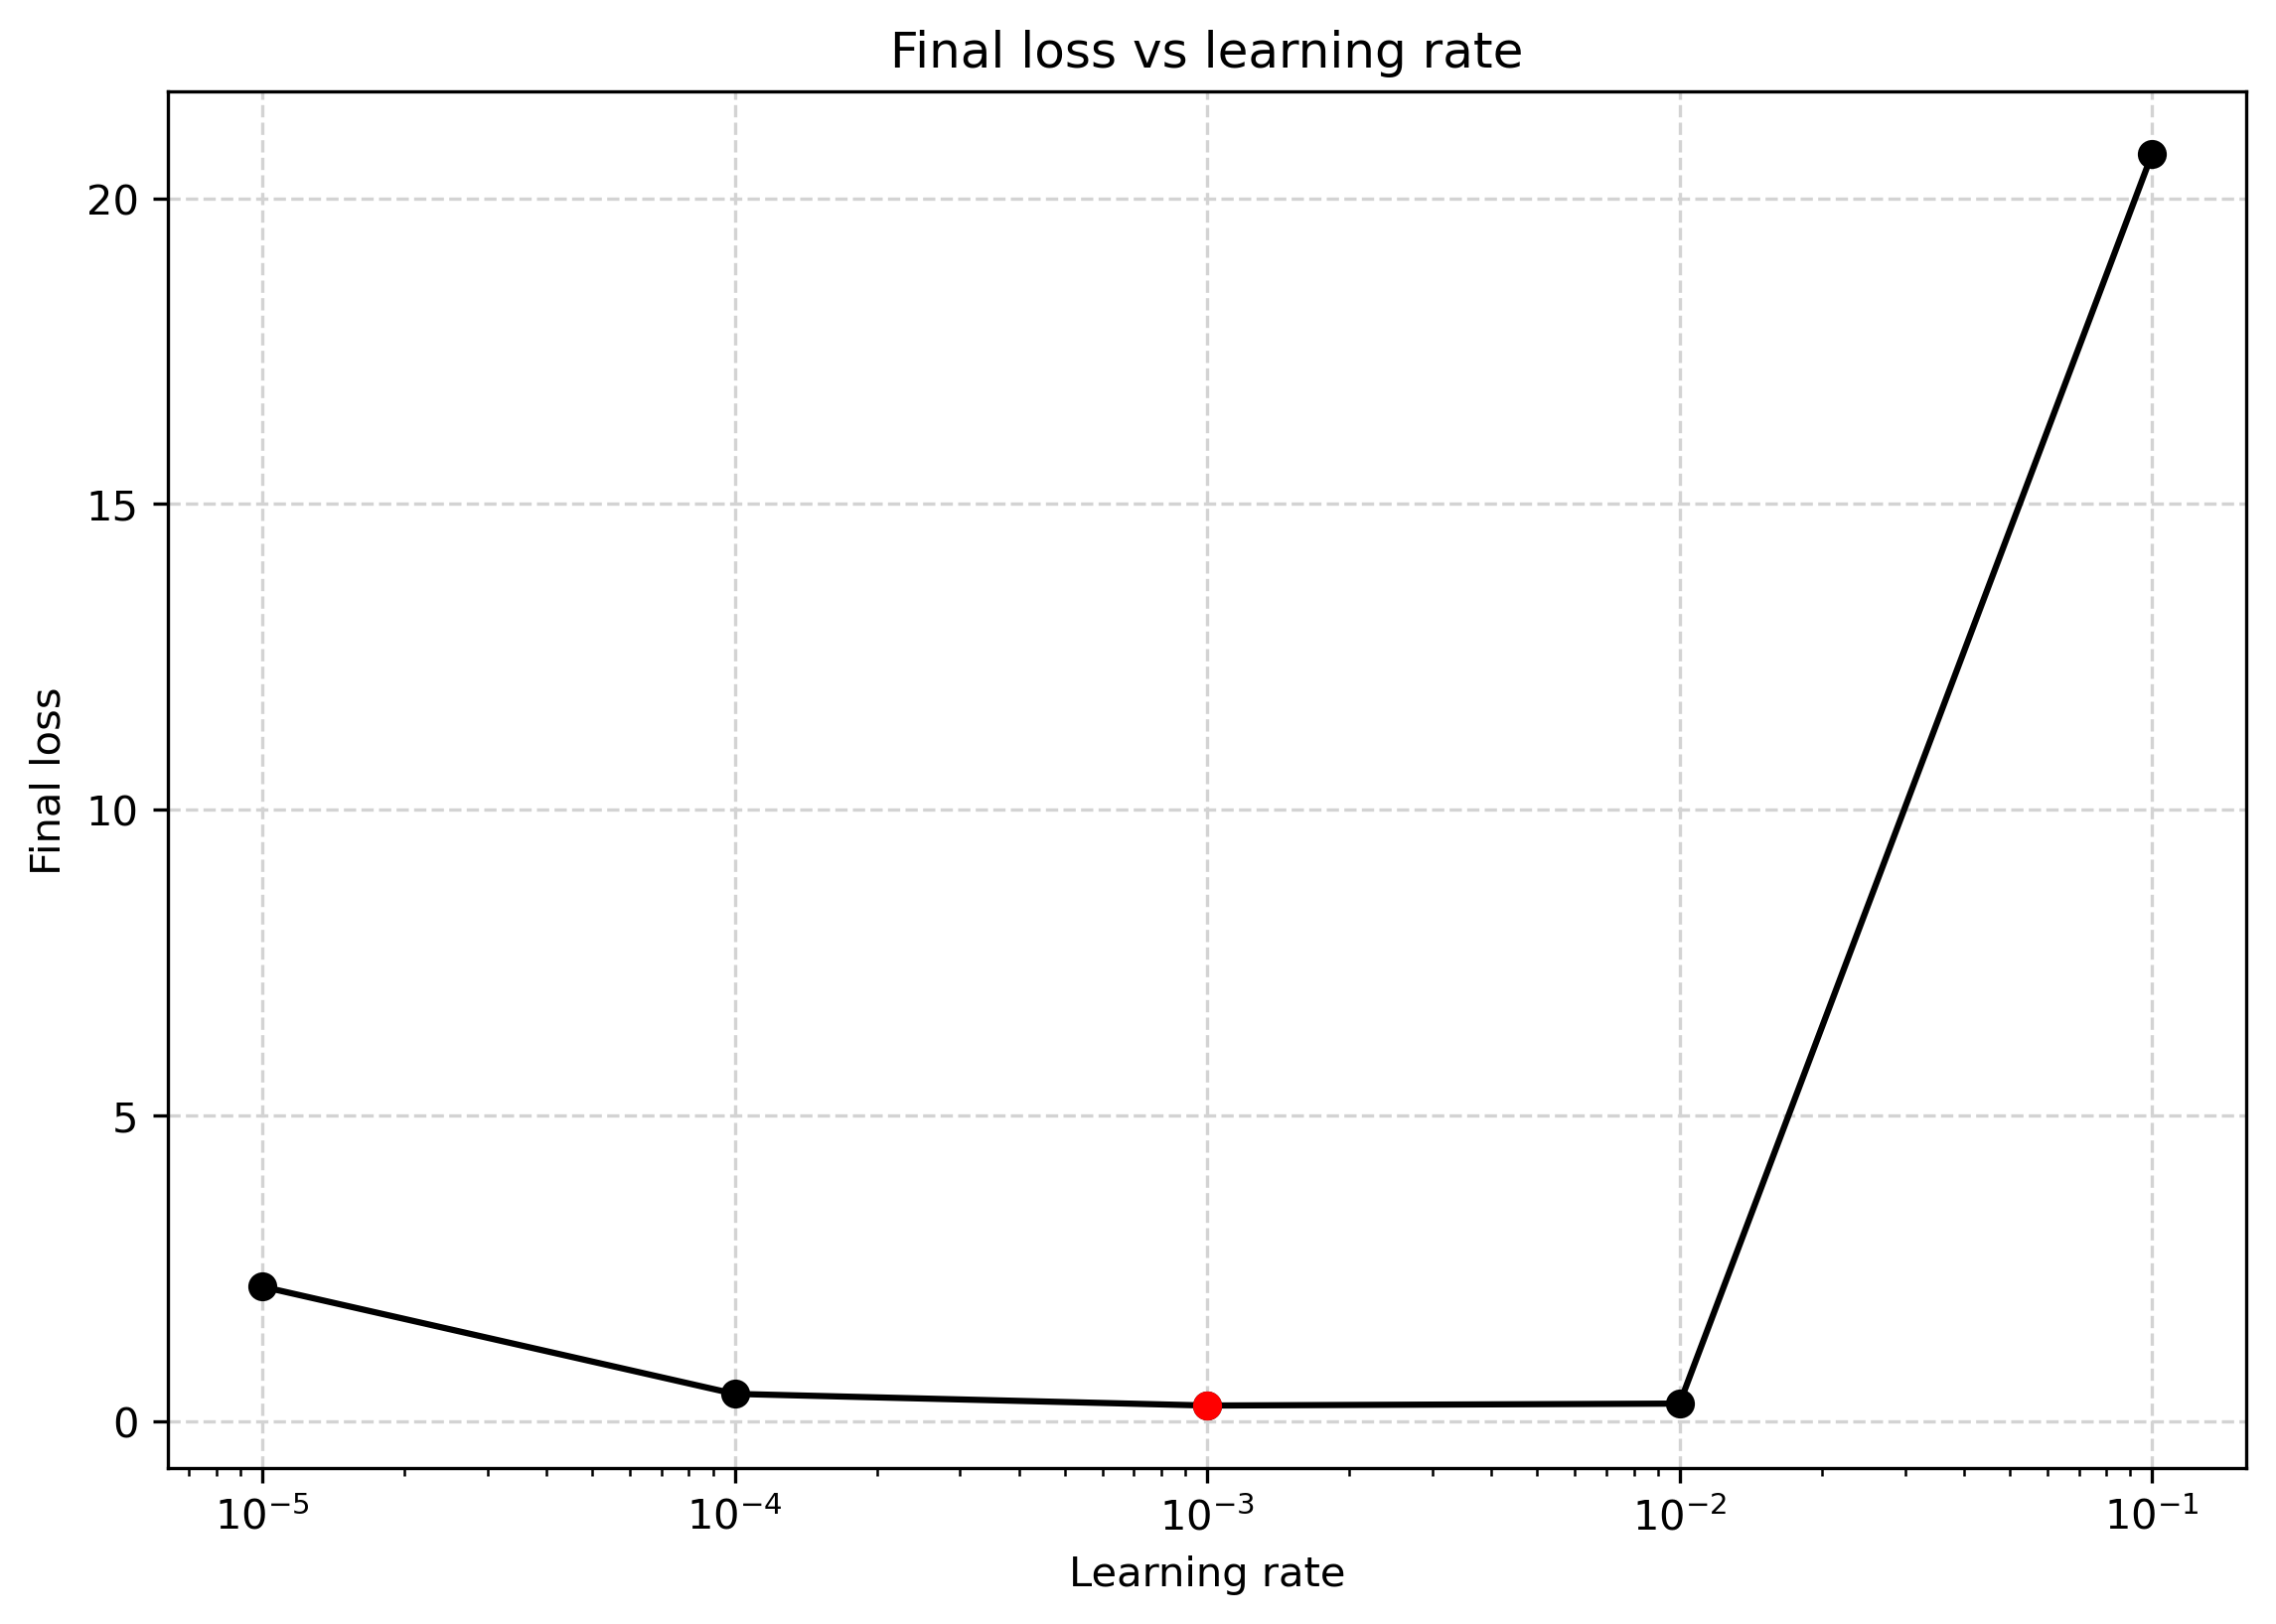

In [540]:
final_losses = [model_dict[lr].final_test_loss for lr in model_dict.keys()]
min_lr = list(model_dict.keys())[final_losses.index(min(final_losses))]
plt.plot(list(model_dict.keys()), final_losses, color="black")
plt.scatter(list(model_dict.keys()), final_losses, color="black")
plt.plot(min_lr, min(final_losses), marker="o", color="red")
plt.xscale("log", base=10)
plt.xlabel("Learning rate")
plt.ylabel("Final loss")
plt.title("Final loss vs learning rate")
plt.show()

1.1.2

In [509]:
best_model = Network([784, 200, 200, 200, 10])
best_model.train(MNIST_train_samples, MNIST_train_labels, MNIST_test_samples, MNIST_test_labels, 40, 128, min_lr, verbose=True,  compute_stats=True)

Epoch 1 complete. Test accuracy: 0.135, Test loss: 2.1459840139580875
Epoch 2 complete. Test accuracy: 0.616, Test loss: 1.4829714428233434
Epoch 3 complete. Test accuracy: 0.639, Test loss: 0.9866586899769517
Epoch 4 complete. Test accuracy: 0.806, Test loss: 0.6917026224345214
Epoch 5 complete. Test accuracy: 0.834, Test loss: 0.5479649406294692
Epoch 6 complete. Test accuracy: 0.827, Test loss: 0.5541912875669268
Epoch 7 complete. Test accuracy: 0.869, Test loss: 0.43684525684756853
Epoch 8 complete. Test accuracy: 0.867, Test loss: 0.4548532110260086
Epoch 9 complete. Test accuracy: 0.822, Test loss: 0.5128305674081505
Epoch 10 complete. Test accuracy: 0.843, Test loss: 0.49965271080154156
Epoch 11 complete. Test accuracy: 0.891, Test loss: 0.3712746927518054
Epoch 12 complete. Test accuracy: 0.877, Test loss: 0.3756615007935107
Epoch 13 complete. Test accuracy: 0.891, Test loss: 0.34436625071039645
Epoch 14 complete. Test accuracy: 0.894, Test loss: 0.35696817808573367
Epoch 15 co

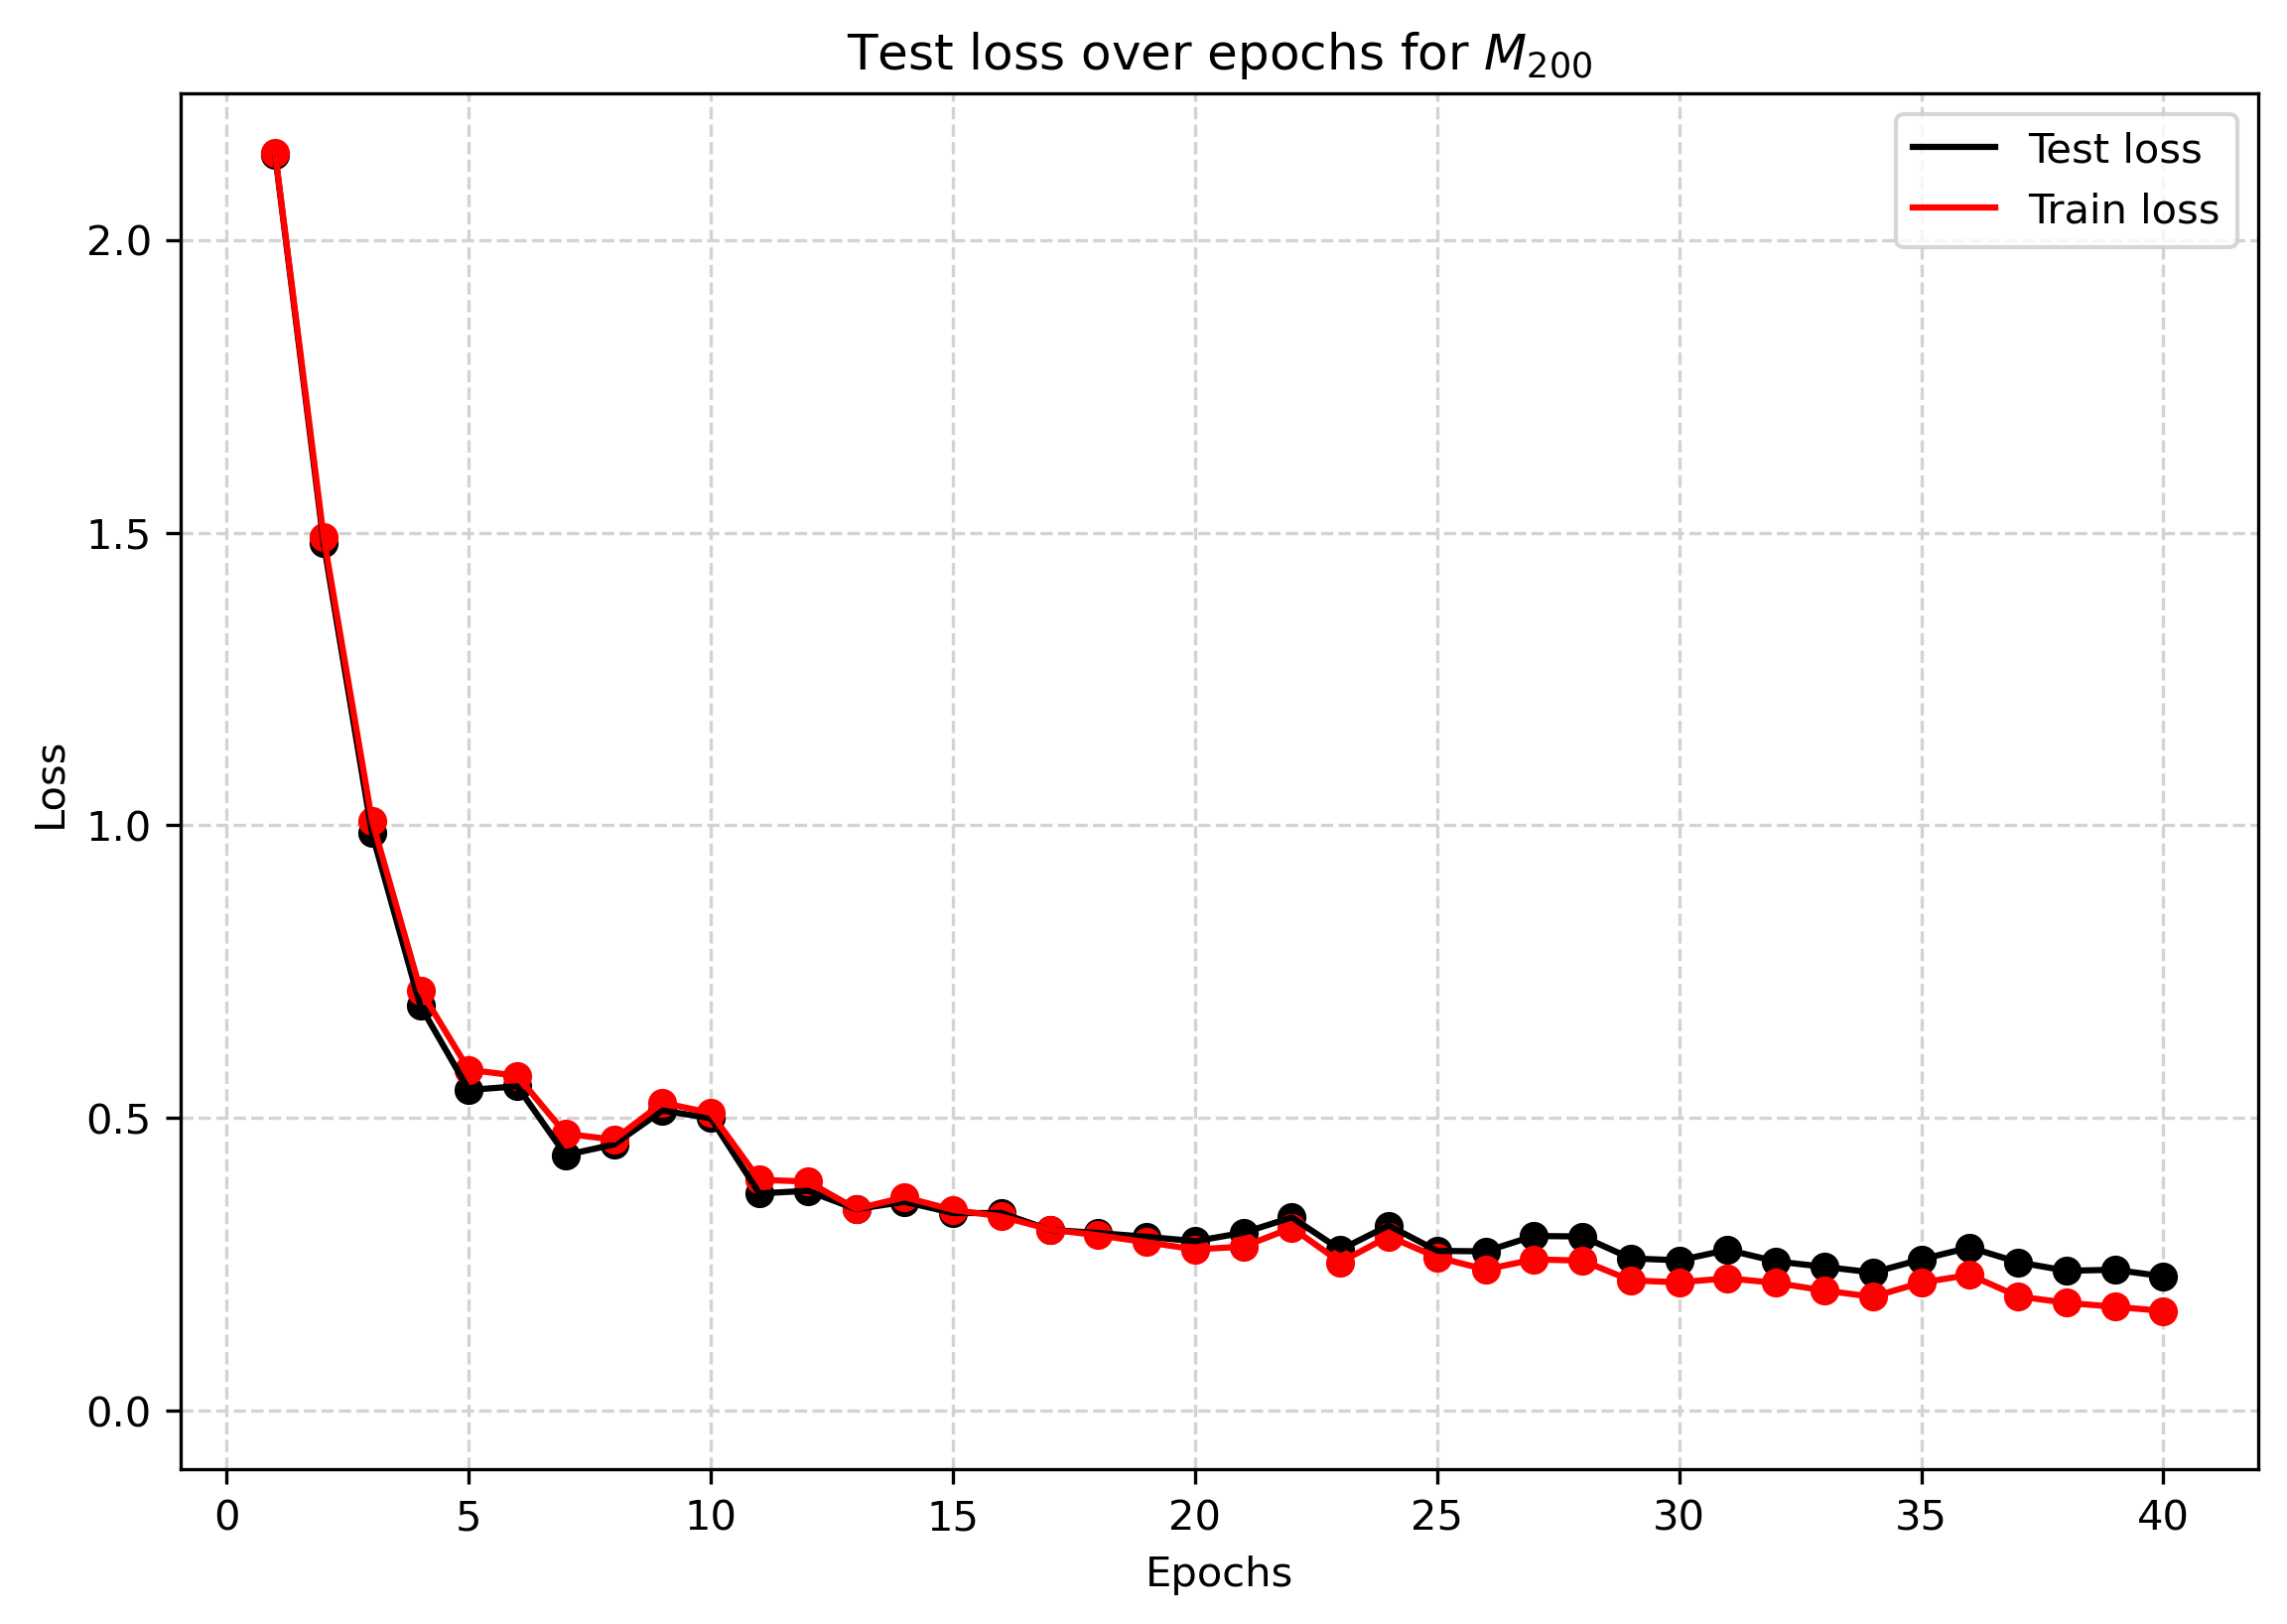

In [510]:
plt.plot([i for i in range(1, len(best_model.test_losses) + 1)], best_model.test_losses, color="black", label="Test loss")
plt.scatter([i for i in range(1, len(best_model.test_losses) + 1)], best_model.test_losses, color="black")
plt.plot([i for i in range(1, len(best_model.train_losses) + 1)], best_model.train_losses, color="red", label="Train loss")
plt.scatter([i for i in range(1, len(best_model.train_losses) + 1)], best_model.train_losses, color="red")
plt.title("Test loss over epochs for $M_{200}$")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(-0.1,2.25)
plt.show()

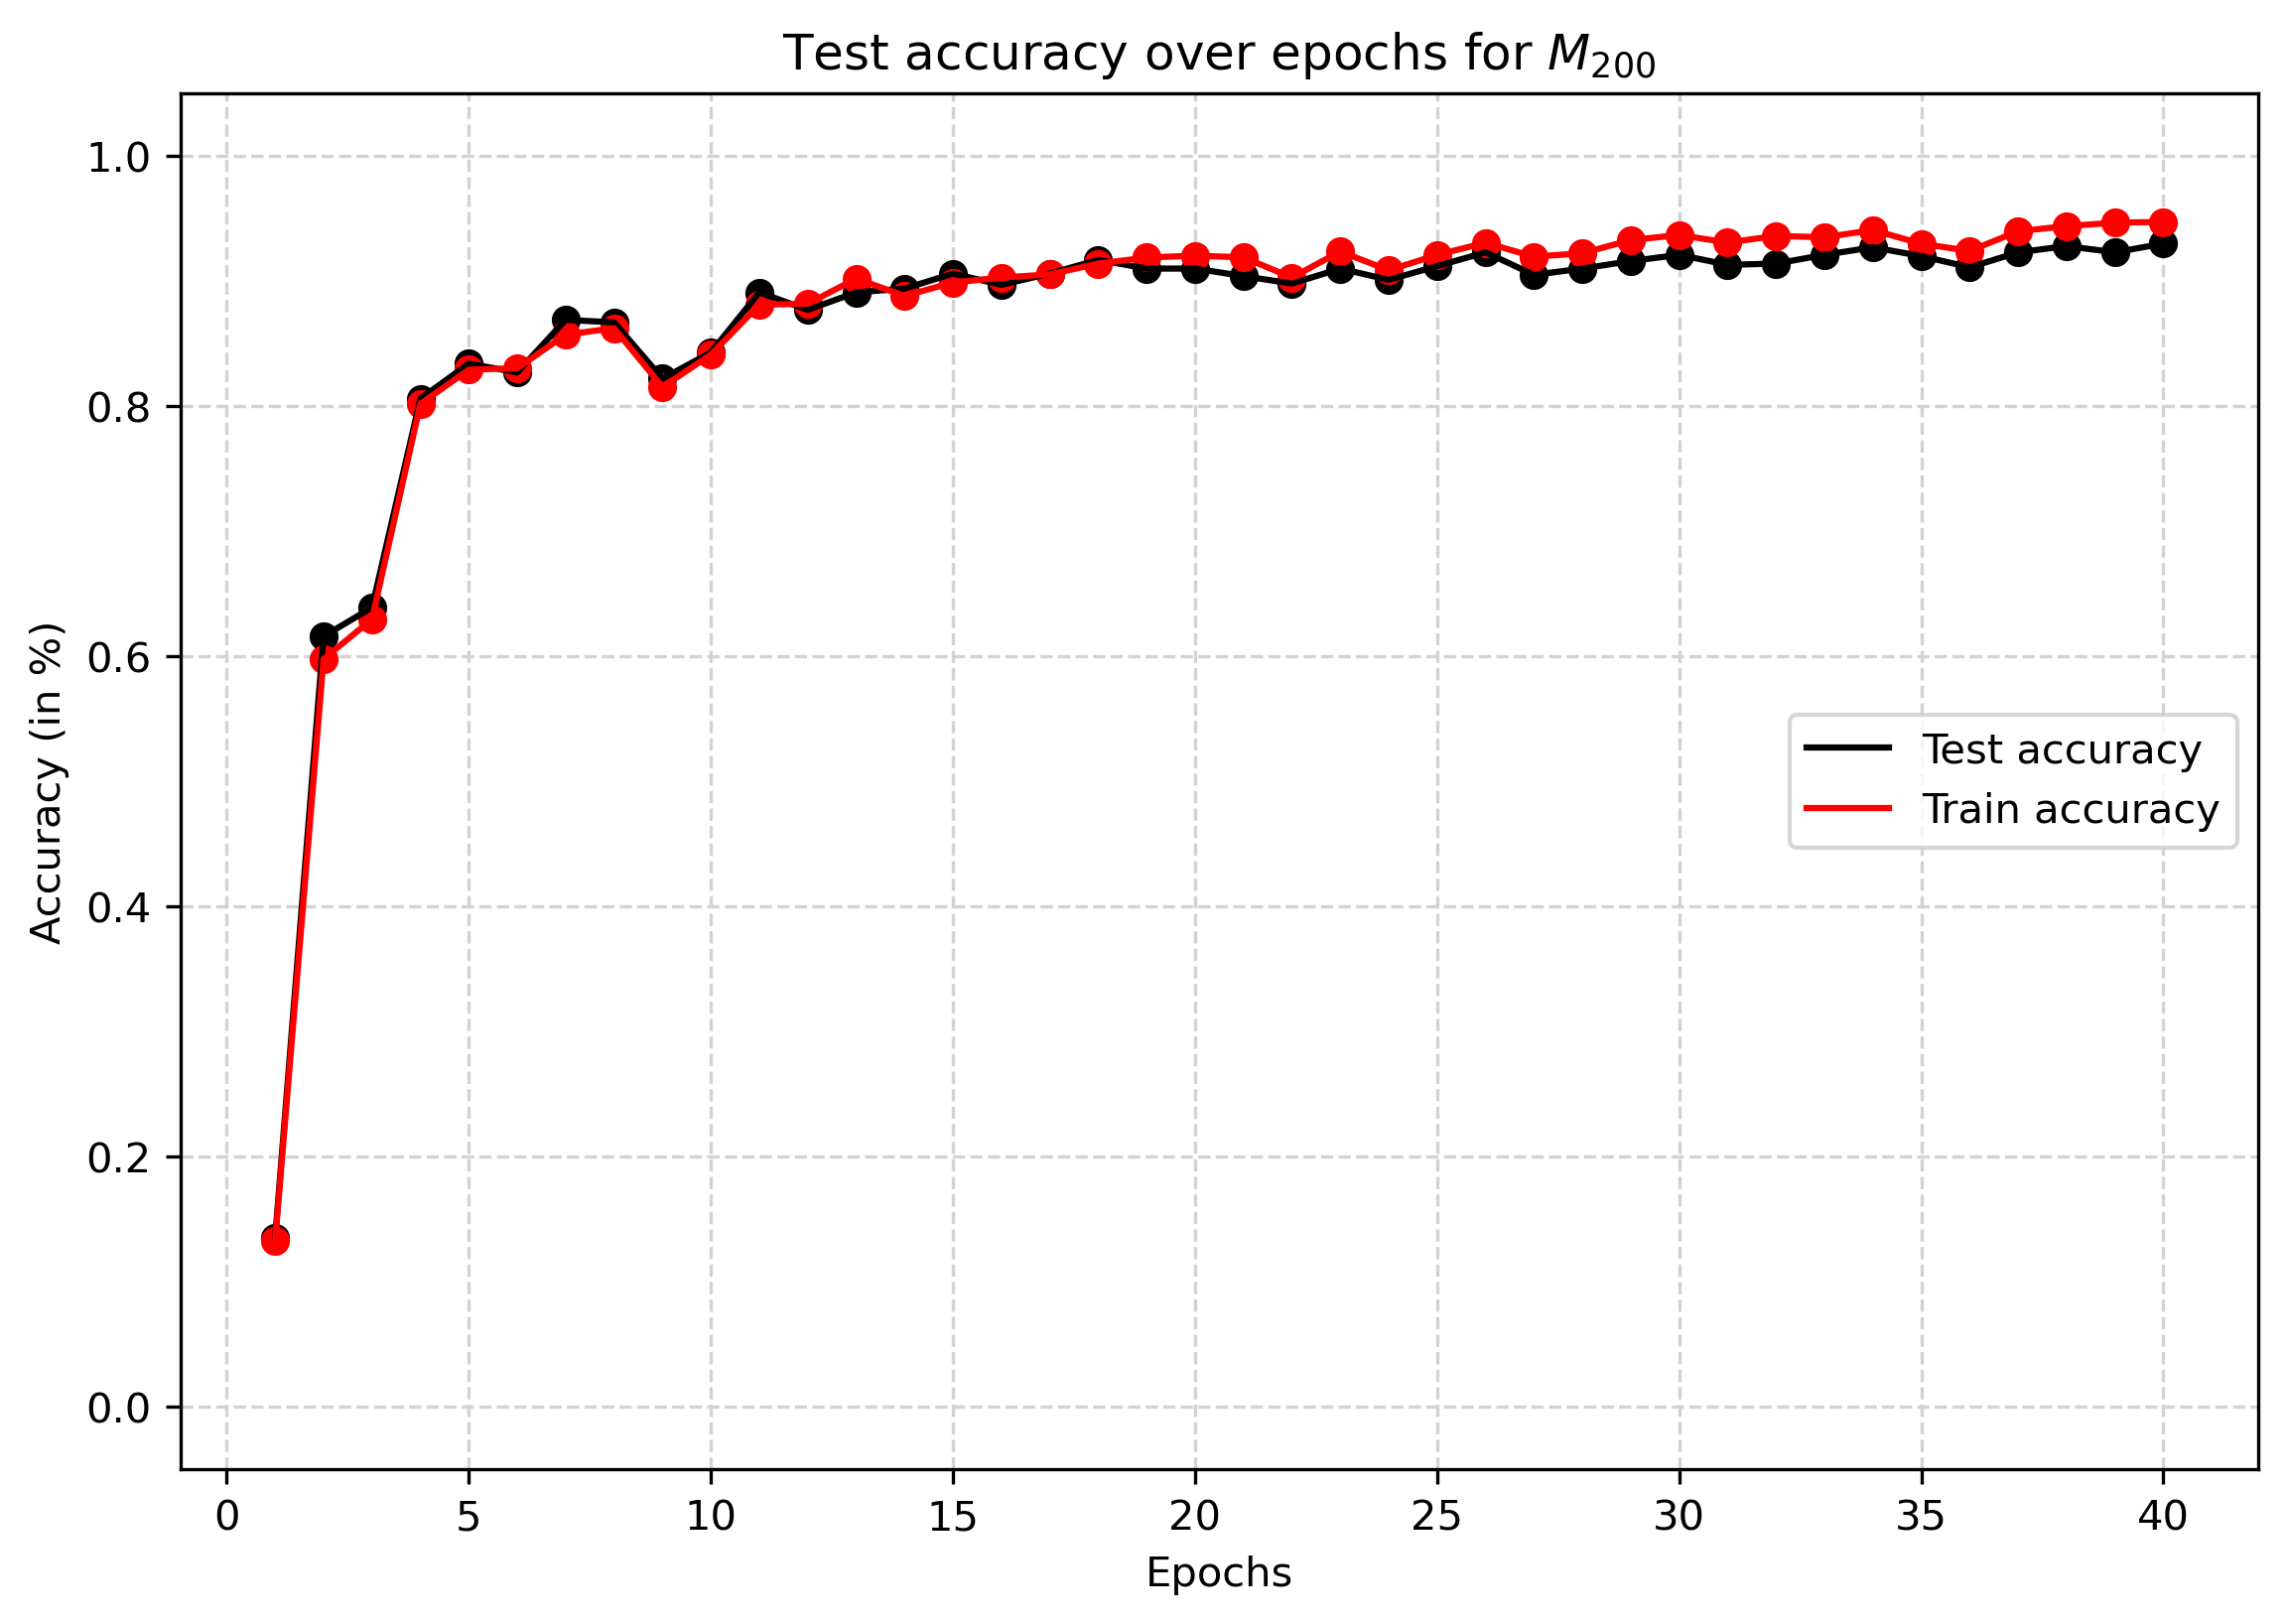

In [511]:
plt.plot([i for i in range(1, len(best_model.test_accuracies) + 1)], best_model.test_accuracies, color="black", label="Test accuracy")
plt.scatter([i for i in range(1, len(best_model.test_accuracies) + 1)], best_model.test_accuracies, color="black")
plt.plot([i for i in range(1, len(best_model.train_accuracies) + 1)], best_model.train_accuracies, color="red", label="Train accuracy")
plt.scatter([i for i in range(1, len(best_model.train_accuracies) + 1)], best_model.train_accuracies, color="red")
plt.title("Test accuracy over epochs for $M_{200}$")
plt.legend(loc="center right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (in %)")
plt.ylim(-0.05, 1.05)
plt.show()

1.1.3

In [512]:
reduced_model = best_model = Network([784, 50, 50, 50, 10])
reduced_model.train(MNIST_train_samples, MNIST_train_labels, MNIST_test_samples, MNIST_test_labels, 40, 128, min_lr, verbose=True, compute_stats=True)

Epoch 1 complete. Test accuracy: 0.243, Test loss: 2.060436581045495
Epoch 2 complete. Test accuracy: 0.565, Test loss: 1.2721877256417706
Epoch 3 complete. Test accuracy: 0.633, Test loss: 0.9676113318752836
Epoch 4 complete. Test accuracy: 0.797, Test loss: 0.6649035736206126
Epoch 5 complete. Test accuracy: 0.826, Test loss: 0.5493793058883358
Epoch 6 complete. Test accuracy: 0.875, Test loss: 0.4511320297817113
Epoch 7 complete. Test accuracy: 0.858, Test loss: 0.4449018181254096
Epoch 8 complete. Test accuracy: 0.874, Test loss: 0.4173726206655078
Epoch 9 complete. Test accuracy: 0.891, Test loss: 0.36723800160751124
Epoch 10 complete. Test accuracy: 0.865, Test loss: 0.43652294168658173
Epoch 11 complete. Test accuracy: 0.902, Test loss: 0.3327887883009189
Epoch 12 complete. Test accuracy: 0.903, Test loss: 0.33059679306475637
Epoch 13 complete. Test accuracy: 0.898, Test loss: 0.332334026393707
Epoch 14 complete. Test accuracy: 0.886, Test loss: 0.345646103500244
Epoch 15 comple

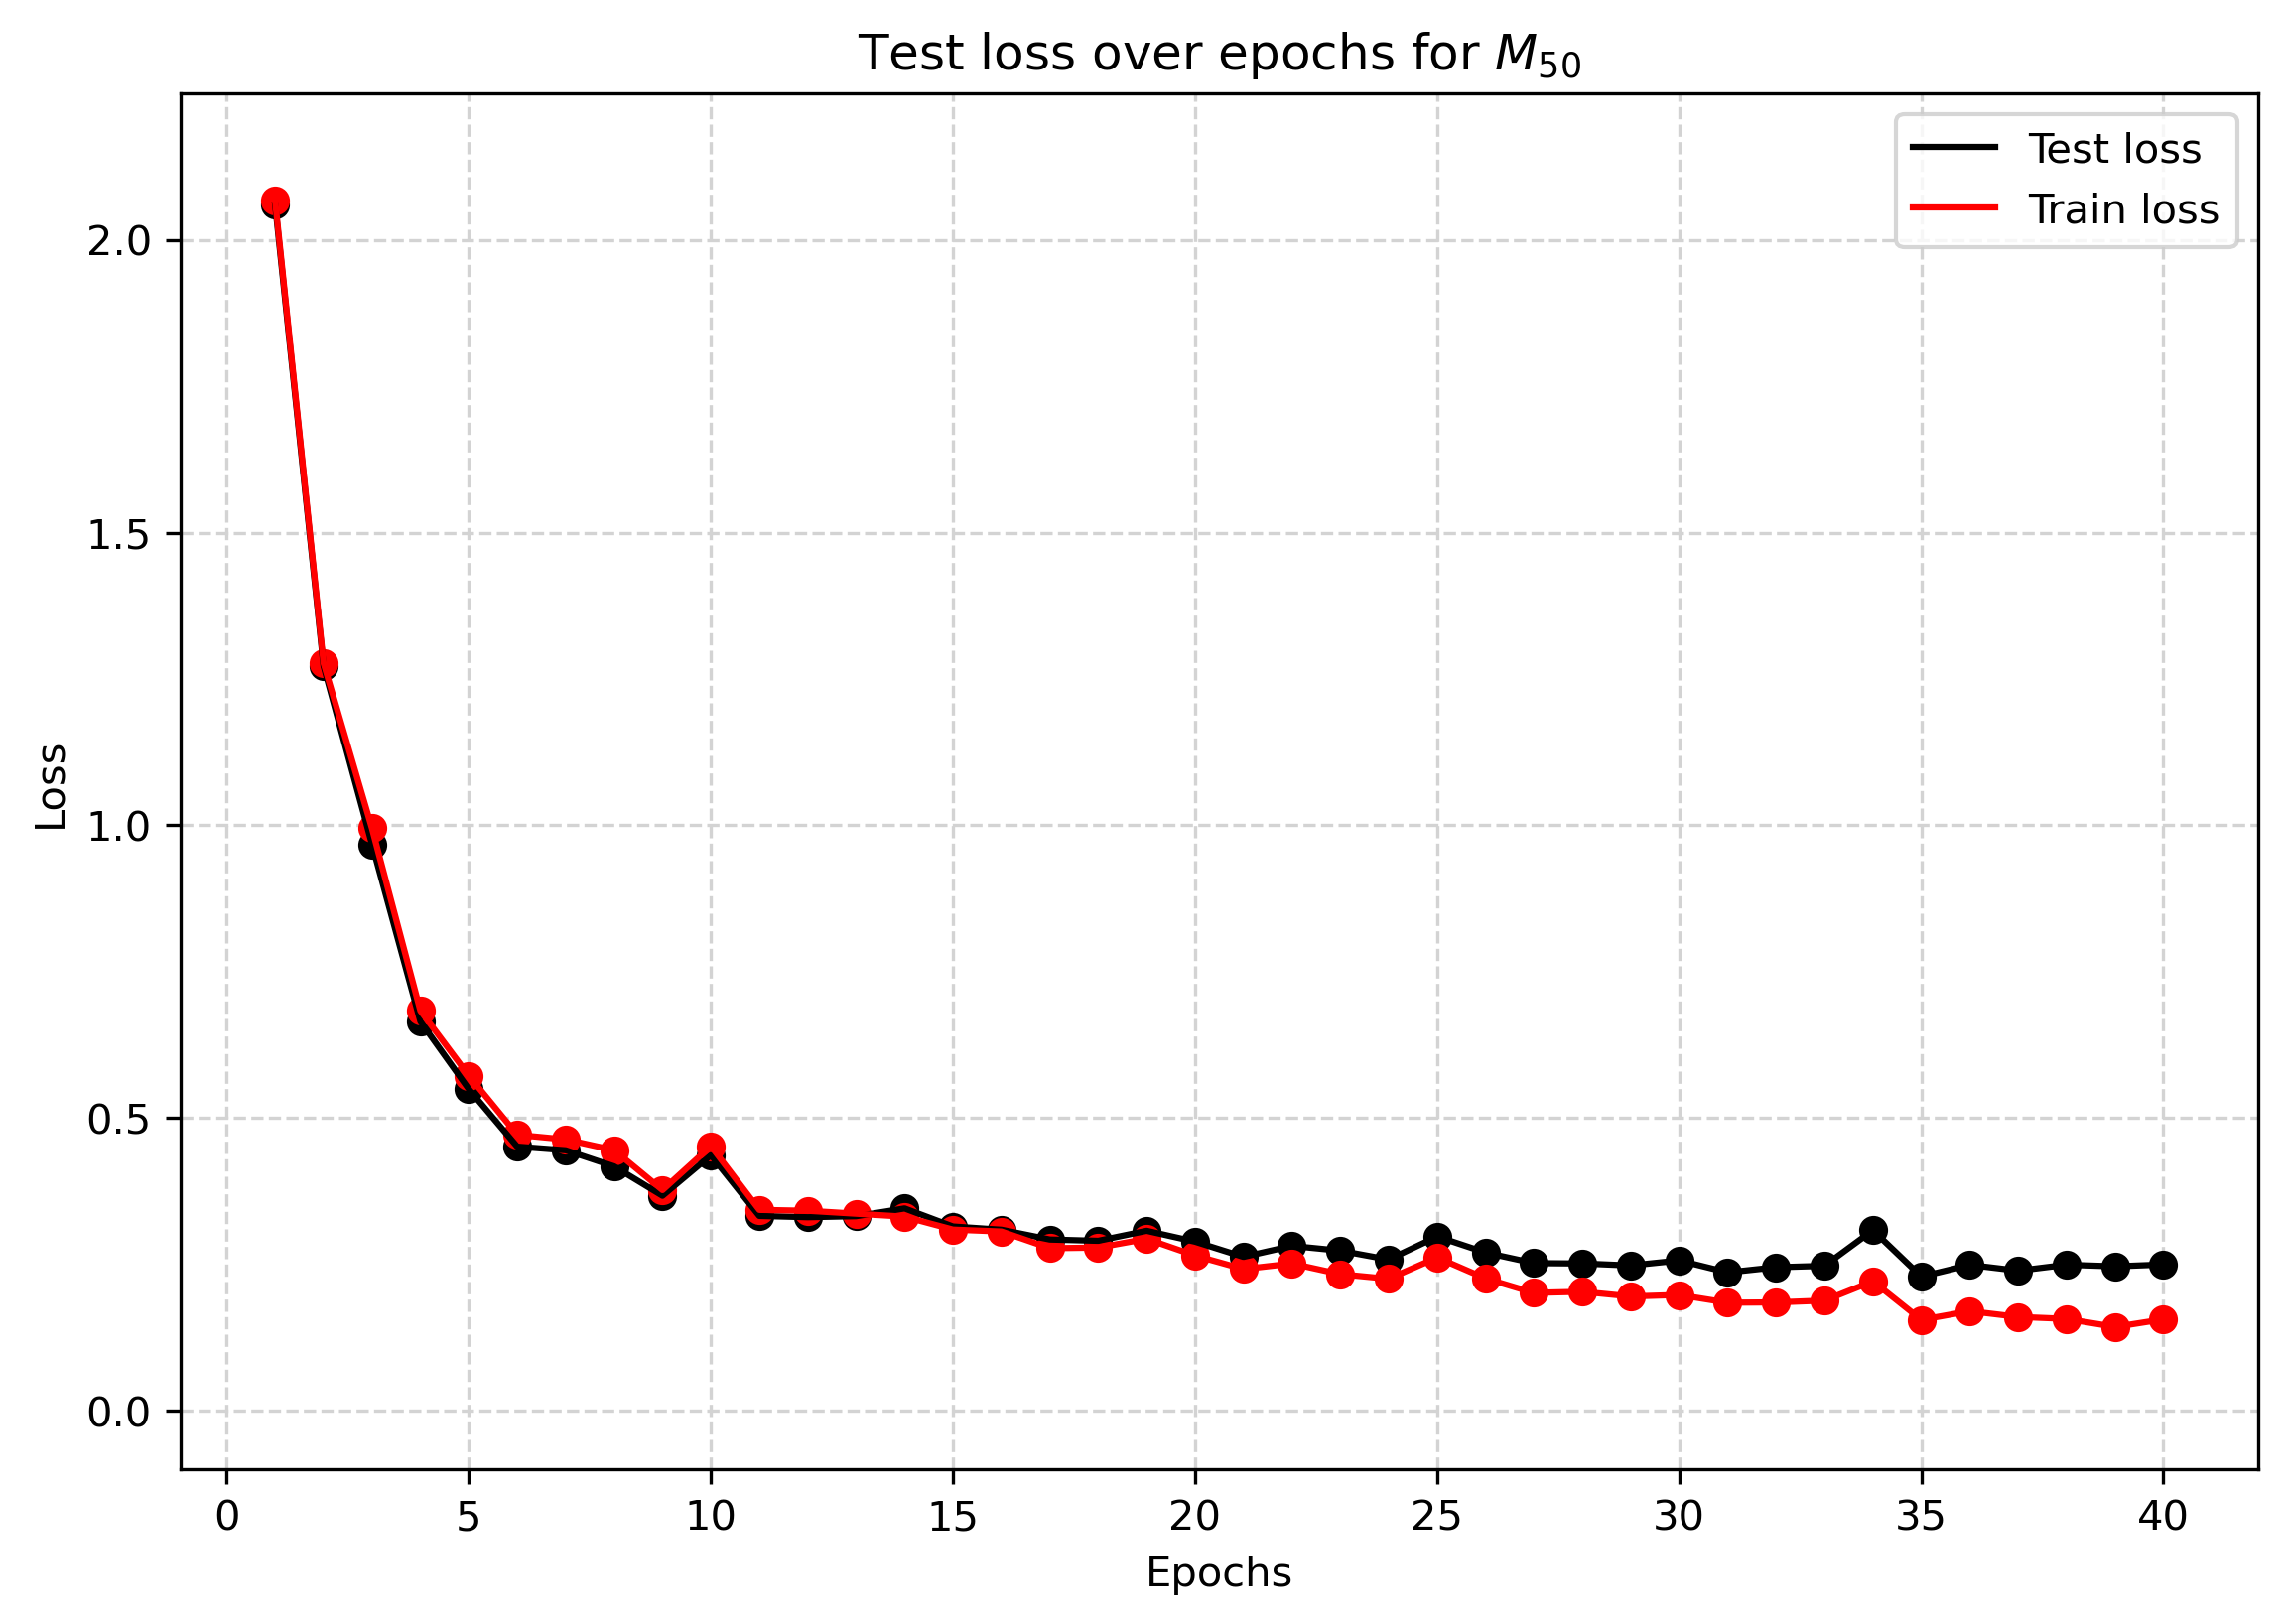

In [513]:
plt.plot([i for i in range(1, len(reduced_model.test_losses) + 1)], reduced_model.test_losses, color="black", label="Test loss")
plt.scatter([i for i in range(1, len(reduced_model.test_losses) + 1)], reduced_model.test_losses, color="black")
plt.plot([i for i in range(1, len(reduced_model.train_losses) + 1)], reduced_model.train_losses, color="red", label="Train loss")
plt.scatter([i for i in range(1, len(reduced_model.train_losses) + 1)], reduced_model.train_losses, color="red")
plt.title("Test loss over epochs for $M_{50}$")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(-0.1,2.25)
plt.show()

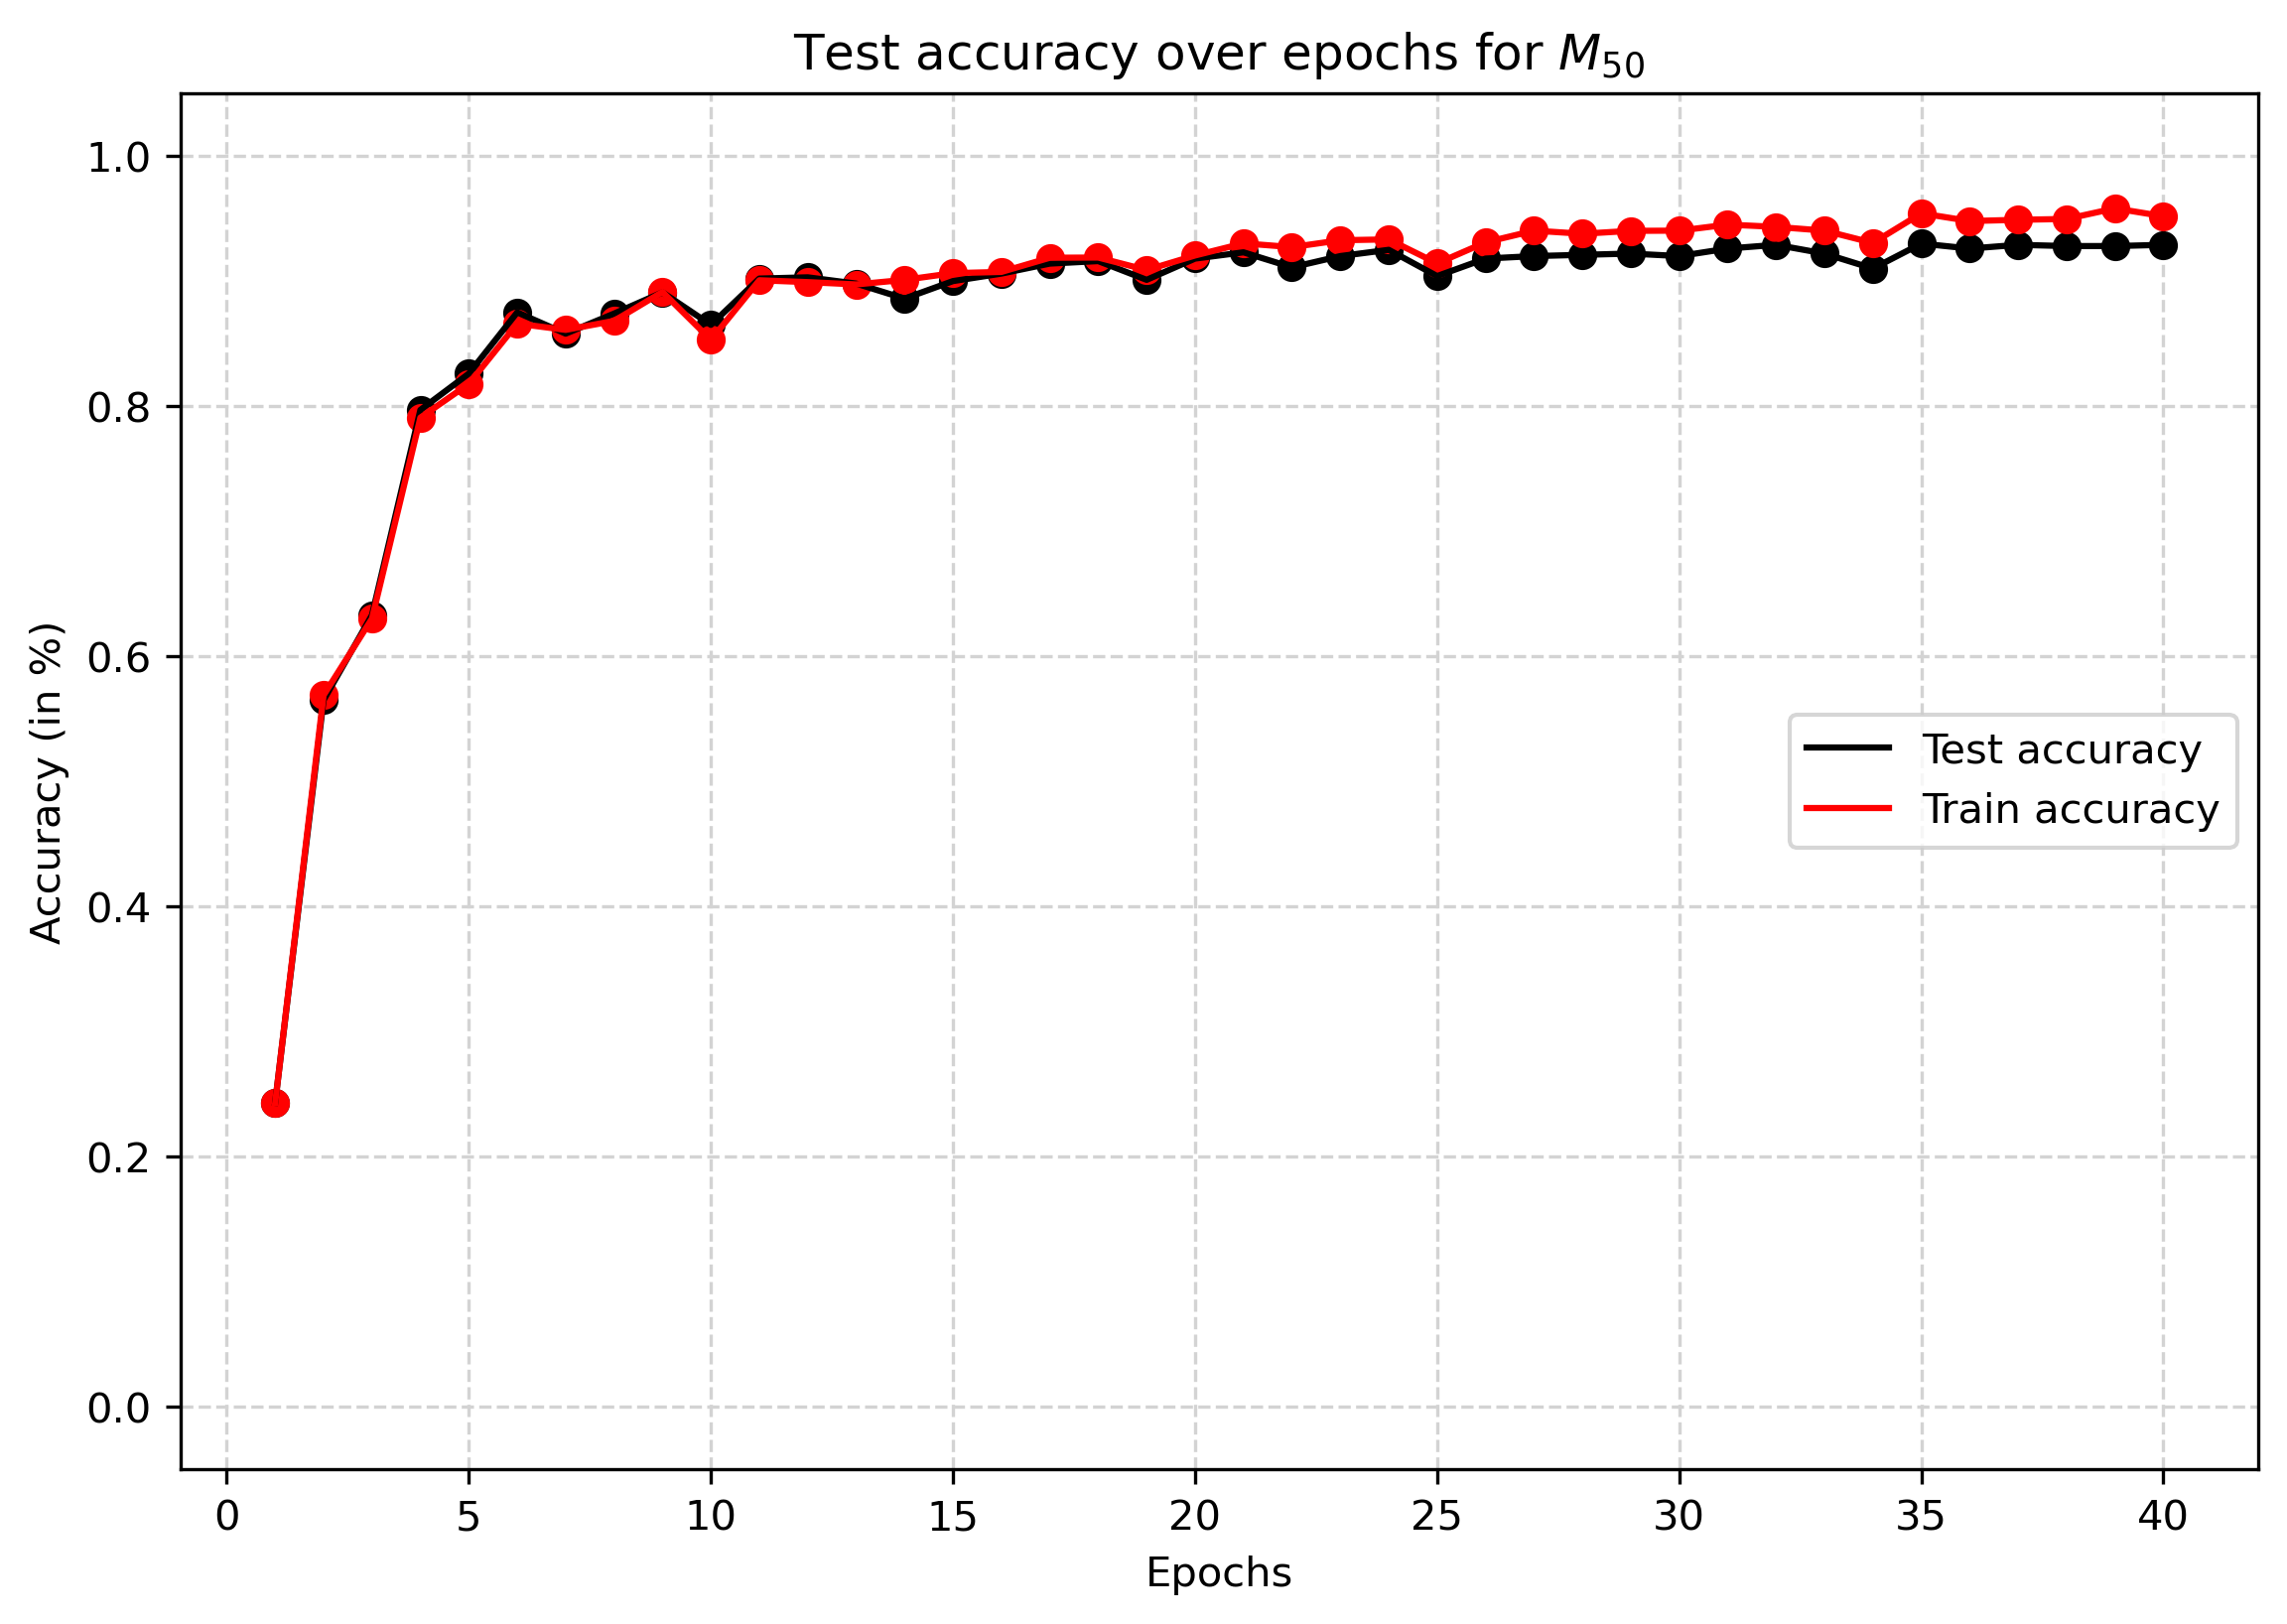

In [514]:
plt.plot([i for i in range(1, len(reduced_model.test_accuracies) + 1)], reduced_model.test_accuracies, color="black", label="Test accuracy")
plt.scatter([i for i in range(1, len(reduced_model.test_accuracies) + 1)], reduced_model.test_accuracies, color="black")
plt.plot([i for i in range(1, len(reduced_model.train_accuracies) + 1)], reduced_model.train_accuracies, color="red", label="Train accuracy")
plt.scatter([i for i in range(1, len(reduced_model.train_accuracies) + 1)], reduced_model.train_accuracies, color="red")
plt.title("Test accuracy over epochs for $M_{50}$")
plt.legend(loc = "center right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (in %)")
plt.ylim(-0.05, 1.05)
plt.show()

1.1.4

In [515]:
model_dropout = Network([784, 200, 200, 200, 10], dropout=0.2)
model_dropout.train(MNIST_train_samples, MNIST_train_labels, MNIST_test_samples, MNIST_test_labels, 40, 128, min_lr, verbose=True, compute_stats=True)

Epoch 1 complete. Test accuracy: 0.329, Test loss: 2.0625714428263198
Epoch 2 complete. Test accuracy: 0.494, Test loss: 1.5822268273443014
Epoch 3 complete. Test accuracy: 0.716, Test loss: 0.9228623473907891
Epoch 4 complete. Test accuracy: 0.716, Test loss: 0.8378835772204595
Epoch 5 complete. Test accuracy: 0.835, Test loss: 0.5298491048360756
Epoch 6 complete. Test accuracy: 0.859, Test loss: 0.4506812293575724
Epoch 7 complete. Test accuracy: 0.815, Test loss: 0.5519872448873779
Epoch 8 complete. Test accuracy: 0.872, Test loss: 0.42397213281182144
Epoch 9 complete. Test accuracy: 0.865, Test loss: 0.42312461610018376
Epoch 10 complete. Test accuracy: 0.874, Test loss: 0.4187486401511423
Epoch 11 complete. Test accuracy: 0.889, Test loss: 0.401960423790191
Epoch 12 complete. Test accuracy: 0.883, Test loss: 0.3937384131954481
Epoch 13 complete. Test accuracy: 0.897, Test loss: 0.36418243651040993
Epoch 14 complete. Test accuracy: 0.908, Test loss: 0.31236501209339834
Epoch 15 com

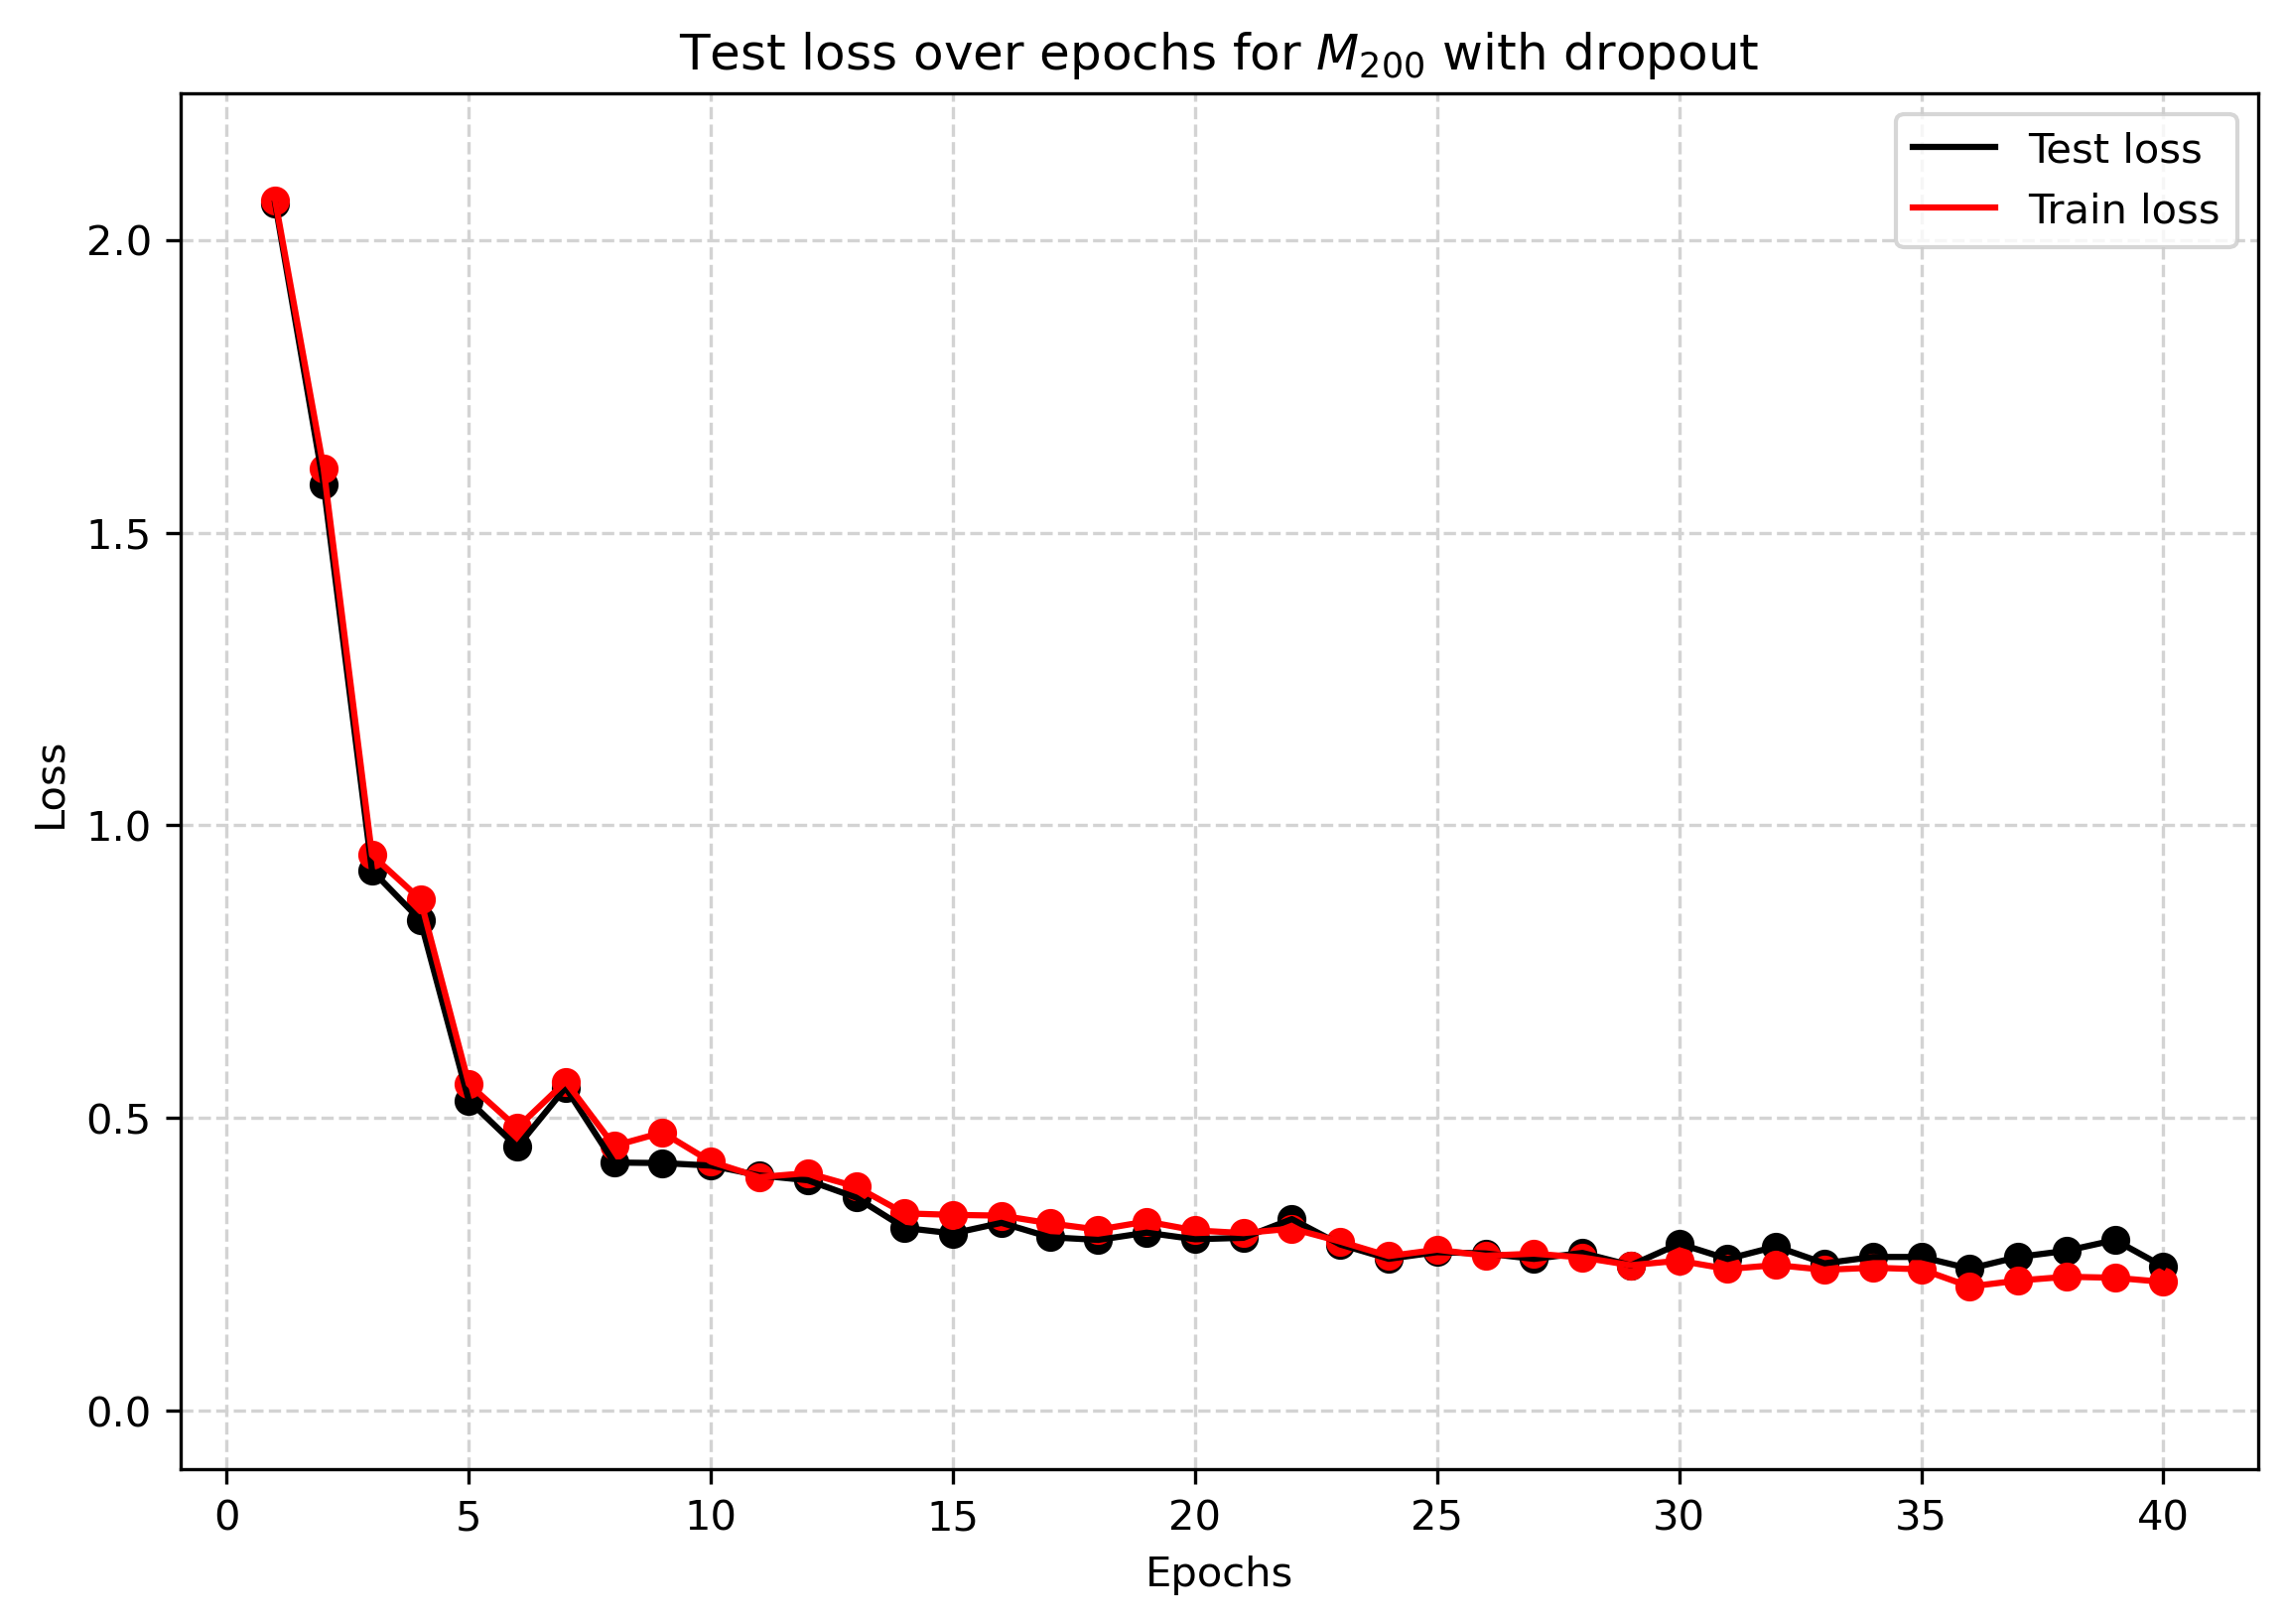

In [516]:
plt.plot([i for i in range(1, len(model_dropout.test_losses) + 1)], model_dropout.test_losses, color="black", label="Test loss")
plt.scatter([i for i in range(1, len(model_dropout.test_losses) + 1)], model_dropout.test_losses, color="black")
plt.plot([i for i in range(1, len(model_dropout.train_losses) + 1)], model_dropout.train_losses, color="red", label="Train loss")
plt.scatter([i for i in range(1, len(model_dropout.train_losses) + 1)], model_dropout.train_losses, color="red")
plt.title("Test loss over epochs for $M_{200}$ with dropout")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(-0.1,2.25)
plt.show()

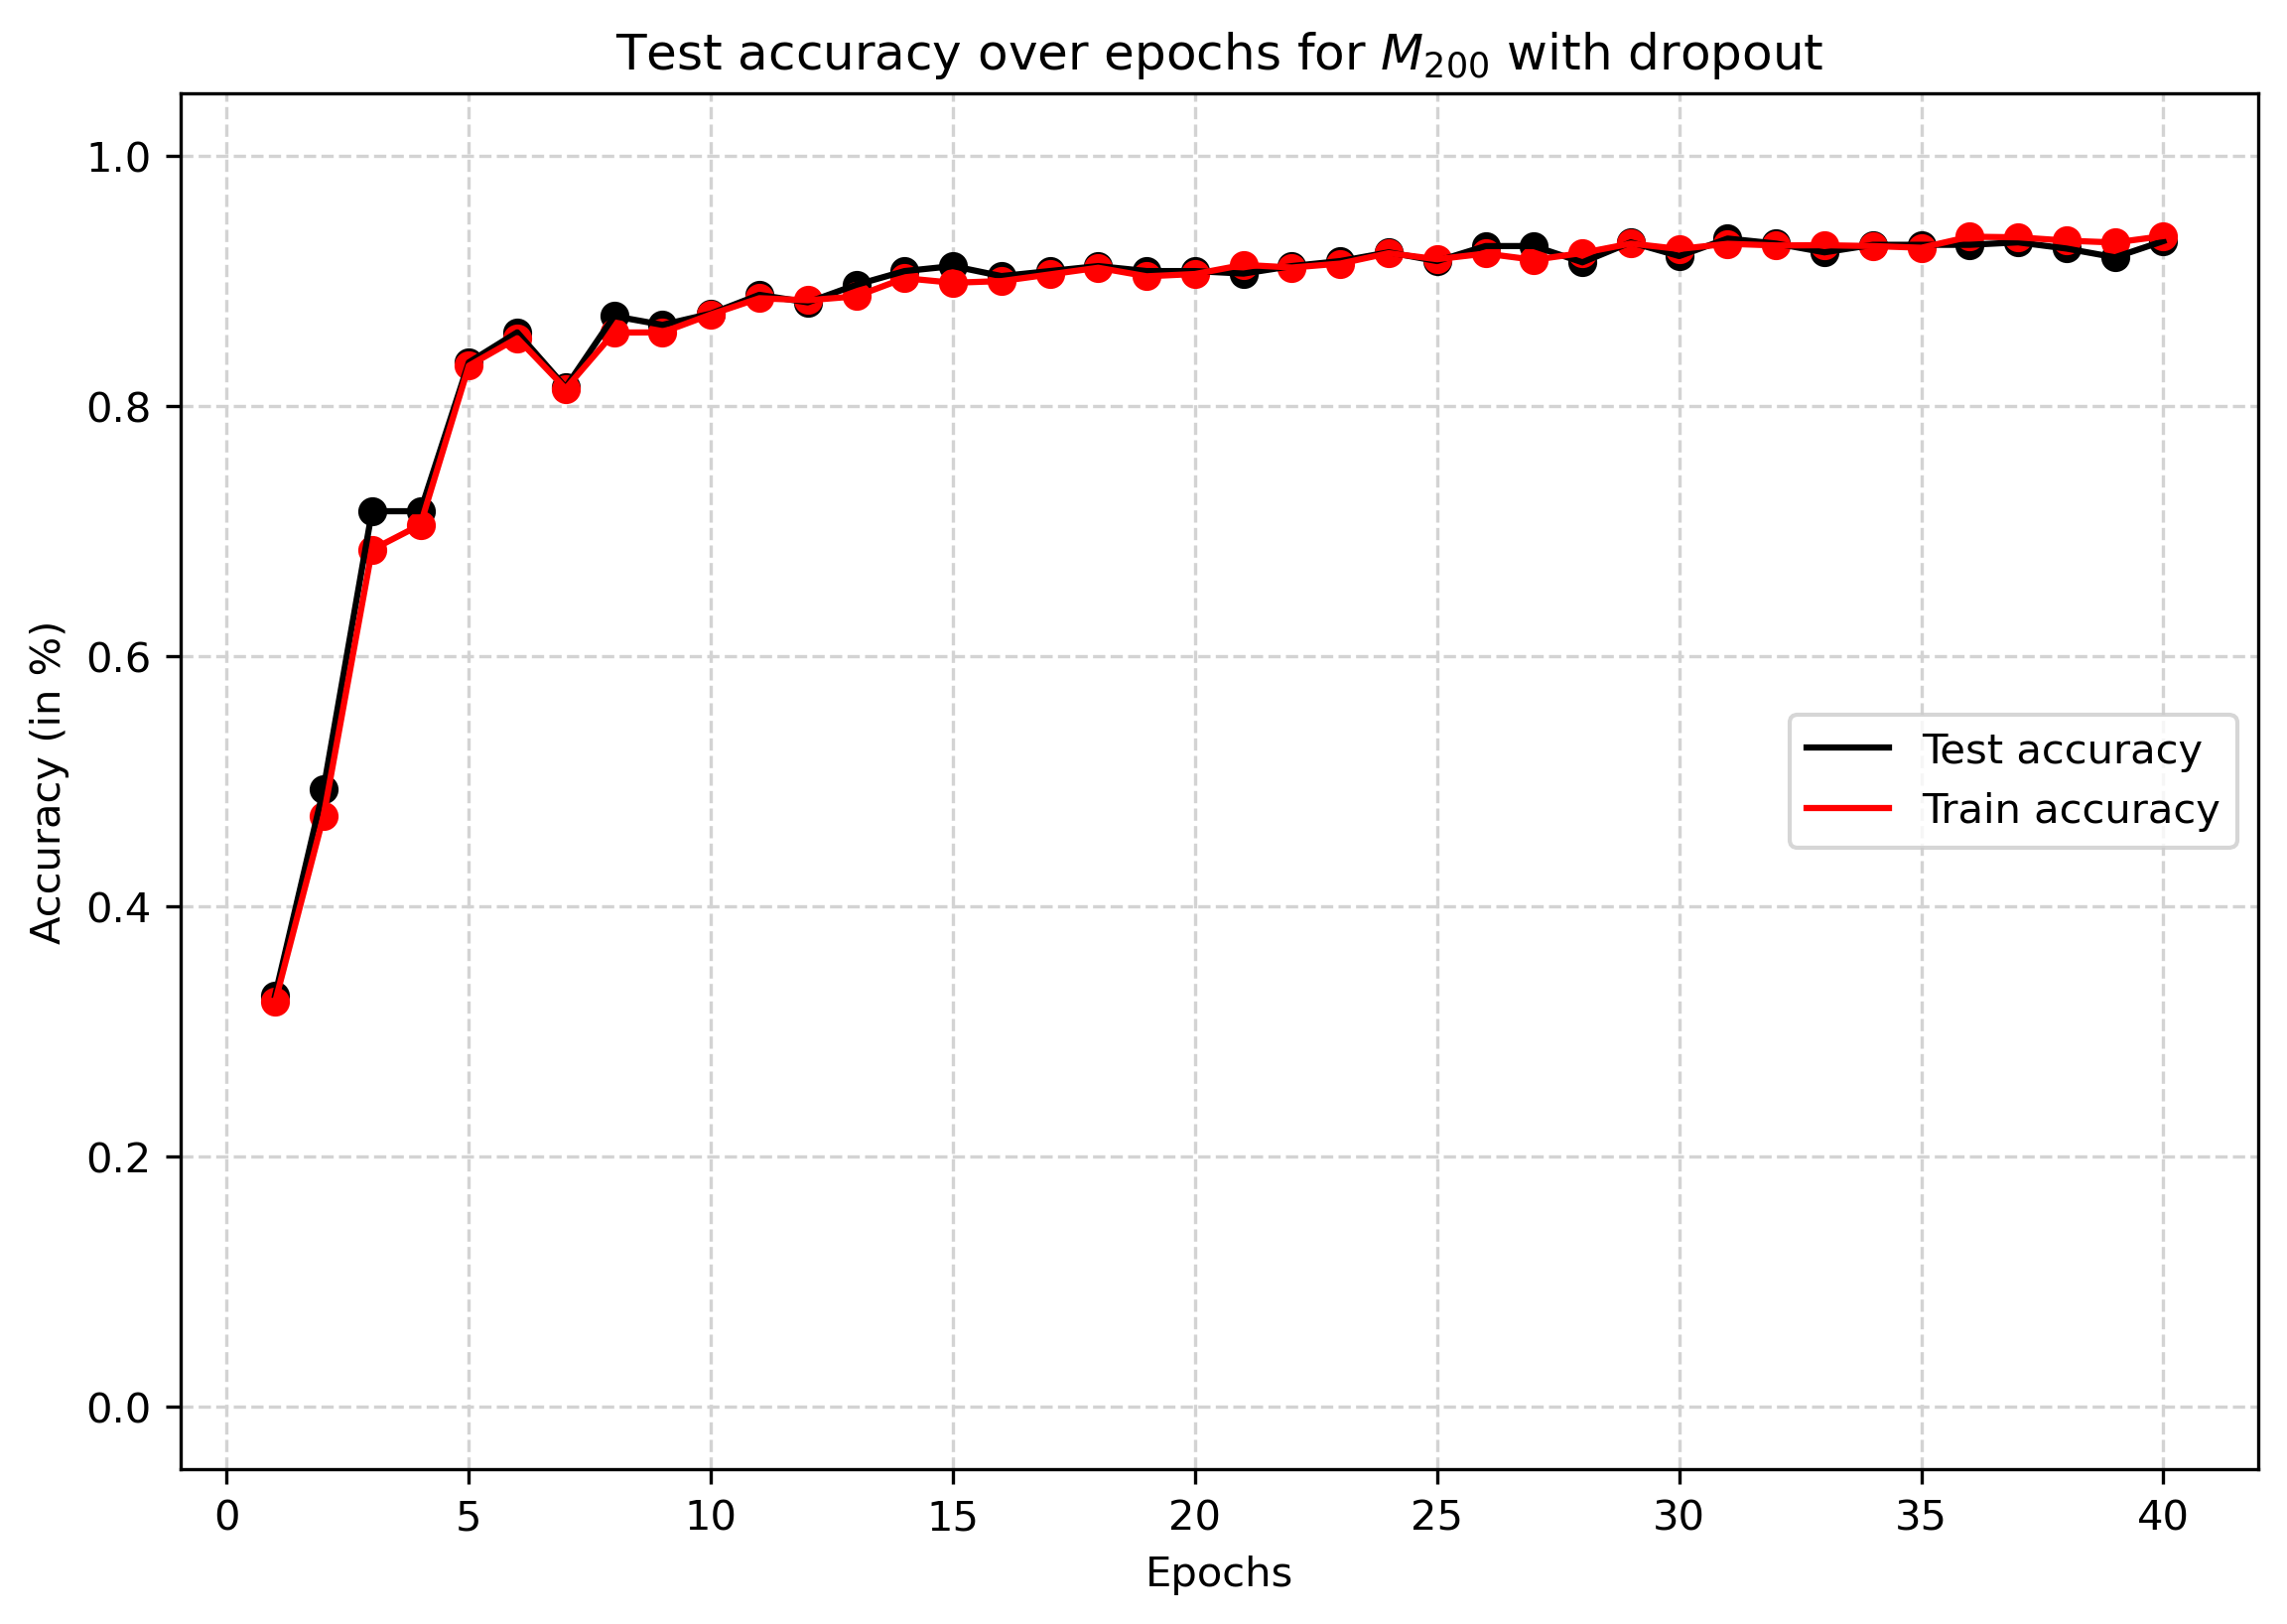

In [517]:
plt.plot([i for i in range(1, len(model_dropout.test_accuracies) + 1)], model_dropout.test_accuracies, color="black", label="Test accuracy")
plt.scatter([i for i in range(1, len(model_dropout.test_accuracies) + 1)], model_dropout.test_accuracies, color="black")
plt.plot([i for i in range(1, len(model_dropout.train_accuracies) + 1)], model_dropout.train_accuracies, color="red", label="Train accuracy")
plt.scatter([i for i in range(1, len(model_dropout.train_accuracies) + 1)], model_dropout.train_accuracies, color="red")
plt.title("Test accuracy over epochs for $M_{200}$ with dropout")
plt.legend(loc = "center right")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (in %)")
plt.ylim(-0.05, 1.05)
plt.show()

#### 1.2 Dimensionality reduction (20 marks)

1.2.1

In [518]:
noisy_MNIST_train = np.loadtxt("data/MNIST_train_noisy.txt")/255
noisy_MNIST_test = np.loadtxt("data/MNIST_test_noisy.txt")/255


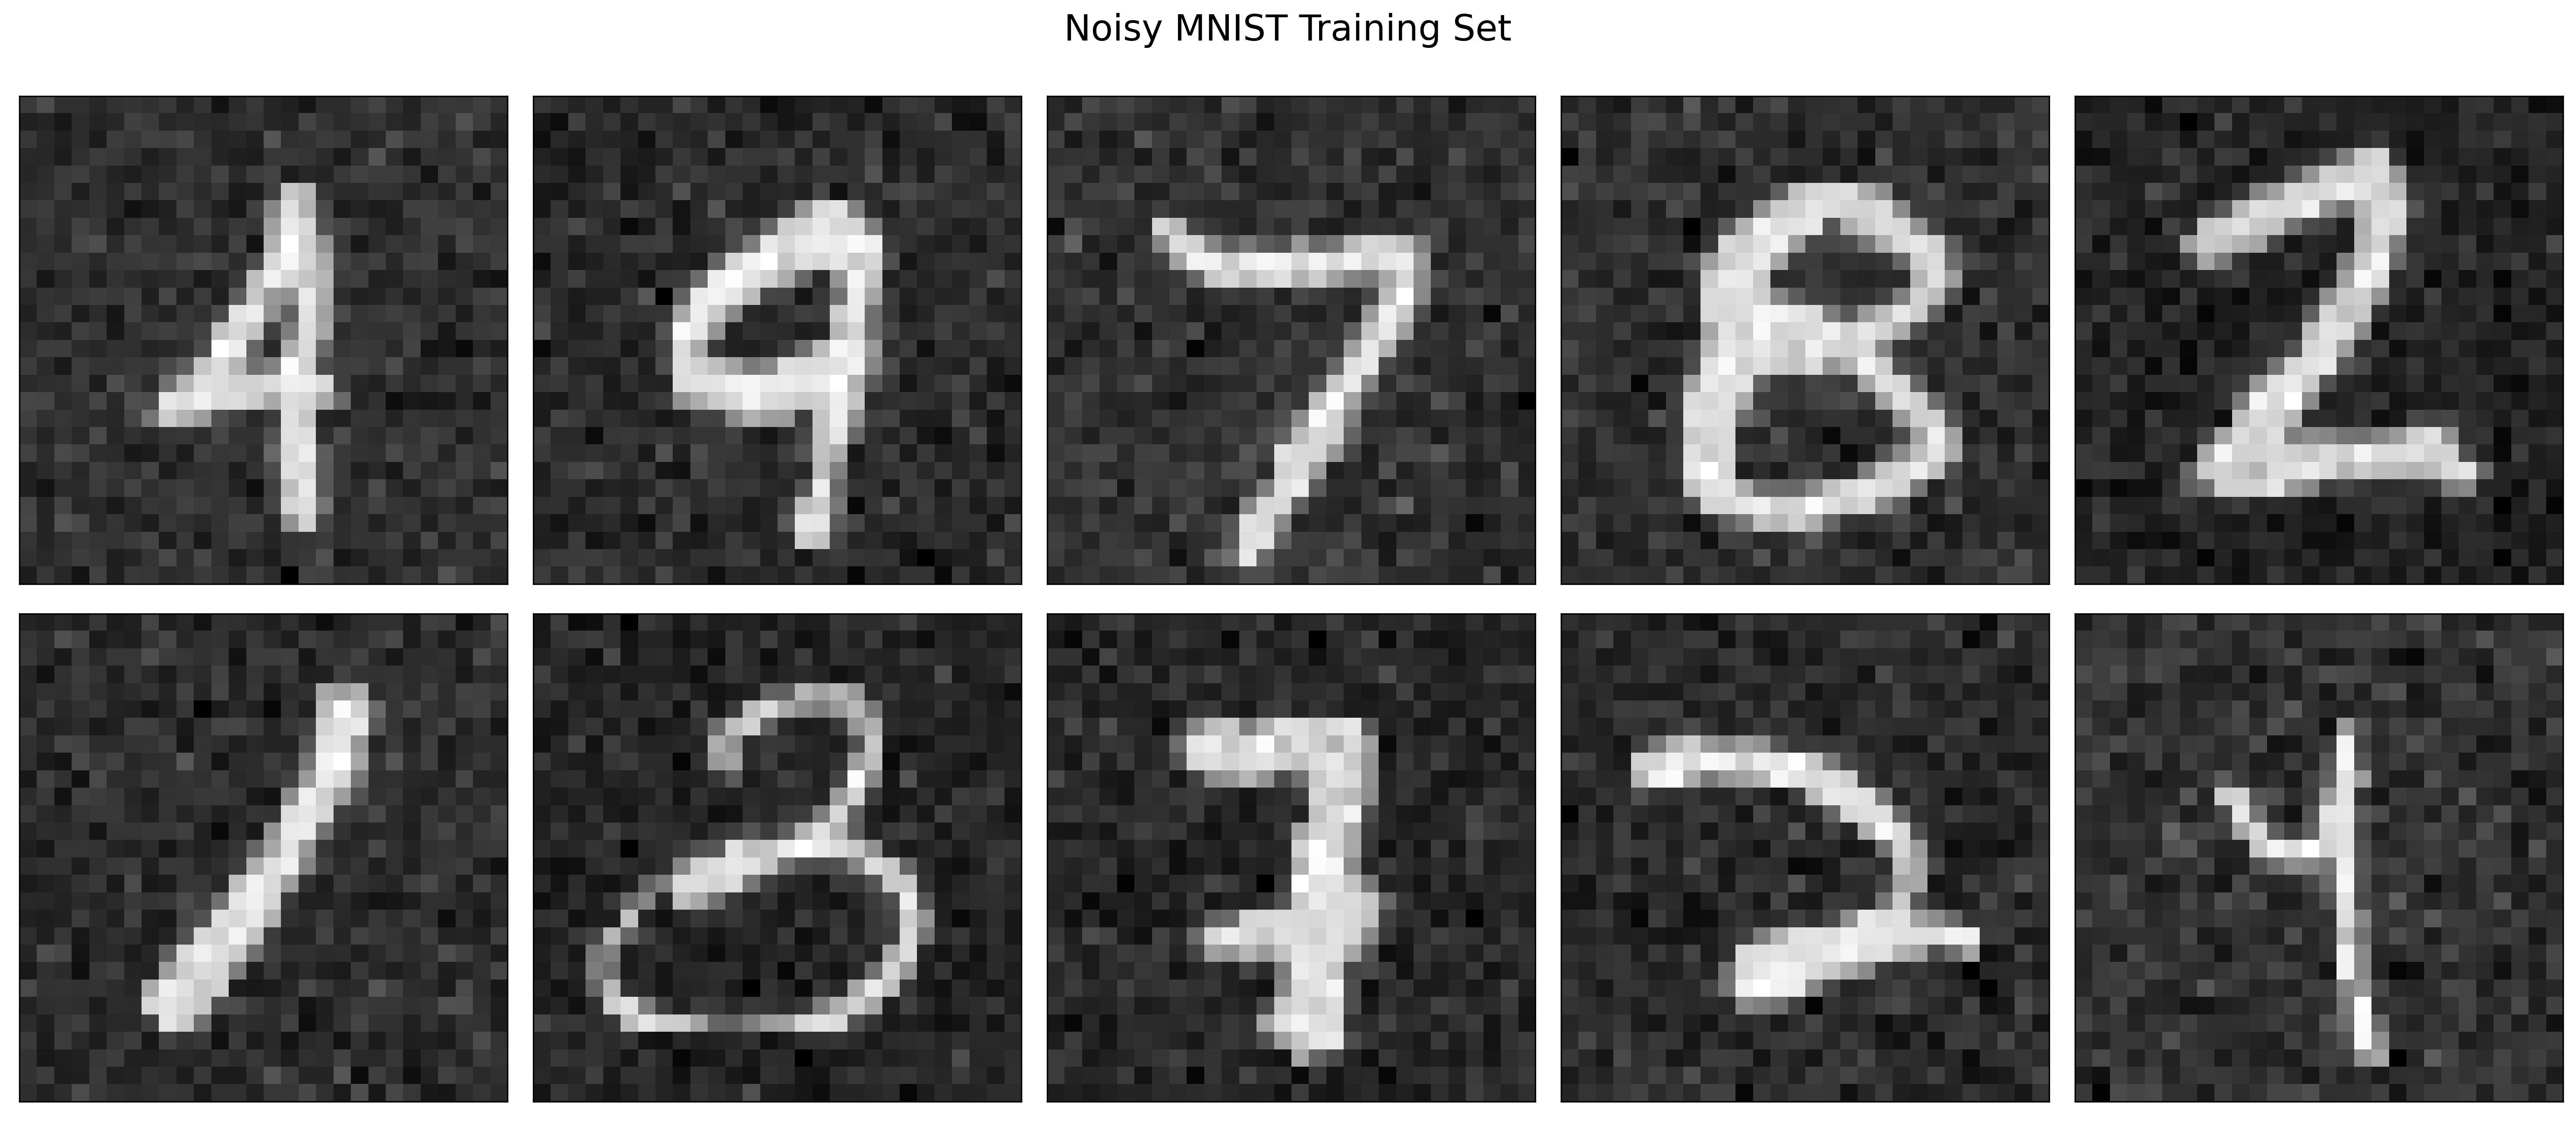

In [633]:

fig, axs = plt.subplots(2, 5, figsize=(20, 9))

for ax in axs:
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        a.grid(False)

for i in range(2):
    for j in range(5):
        axs[i, j].imshow(noisy_MNIST_train[i*5 + j].reshape(28, 28), cmap="gray")


fig.suptitle("Noisy MNIST Training Set", fontsize=20)
fig.tight_layout()
plt.show()

In [520]:
def normalize_pca(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

def unnormalize_pca(Xnorm, X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    return Xnorm*std_filled + mu

In [521]:
def pca_function(X, m):
    Xn = normalize_pca(X)
    n = Xn.shape[0]
    C = (Xn.T@Xn)/(n-1)

    eigenvalues, eigenvectors = sp.sparse.linalg.eigsh(C, m, which="LM", return_eigenvectors=True) 

    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    top_eigenvectors = eigenvectors[:,:m]
    X_pca = X@top_eigenvectors

    return X_pca, eigenvectors, eigenvalues


In [522]:
def min_index(boolean_array):
    for i in range(len(boolean_array)):
        if boolean_array[i]:
            return i
    return -1

In [523]:
_, _ , eigenvalues = pca_function(noisy_MNIST_train, 783)
explained_variances = np.cumsum(eigenvalues)/np.sum(eigenvalues)

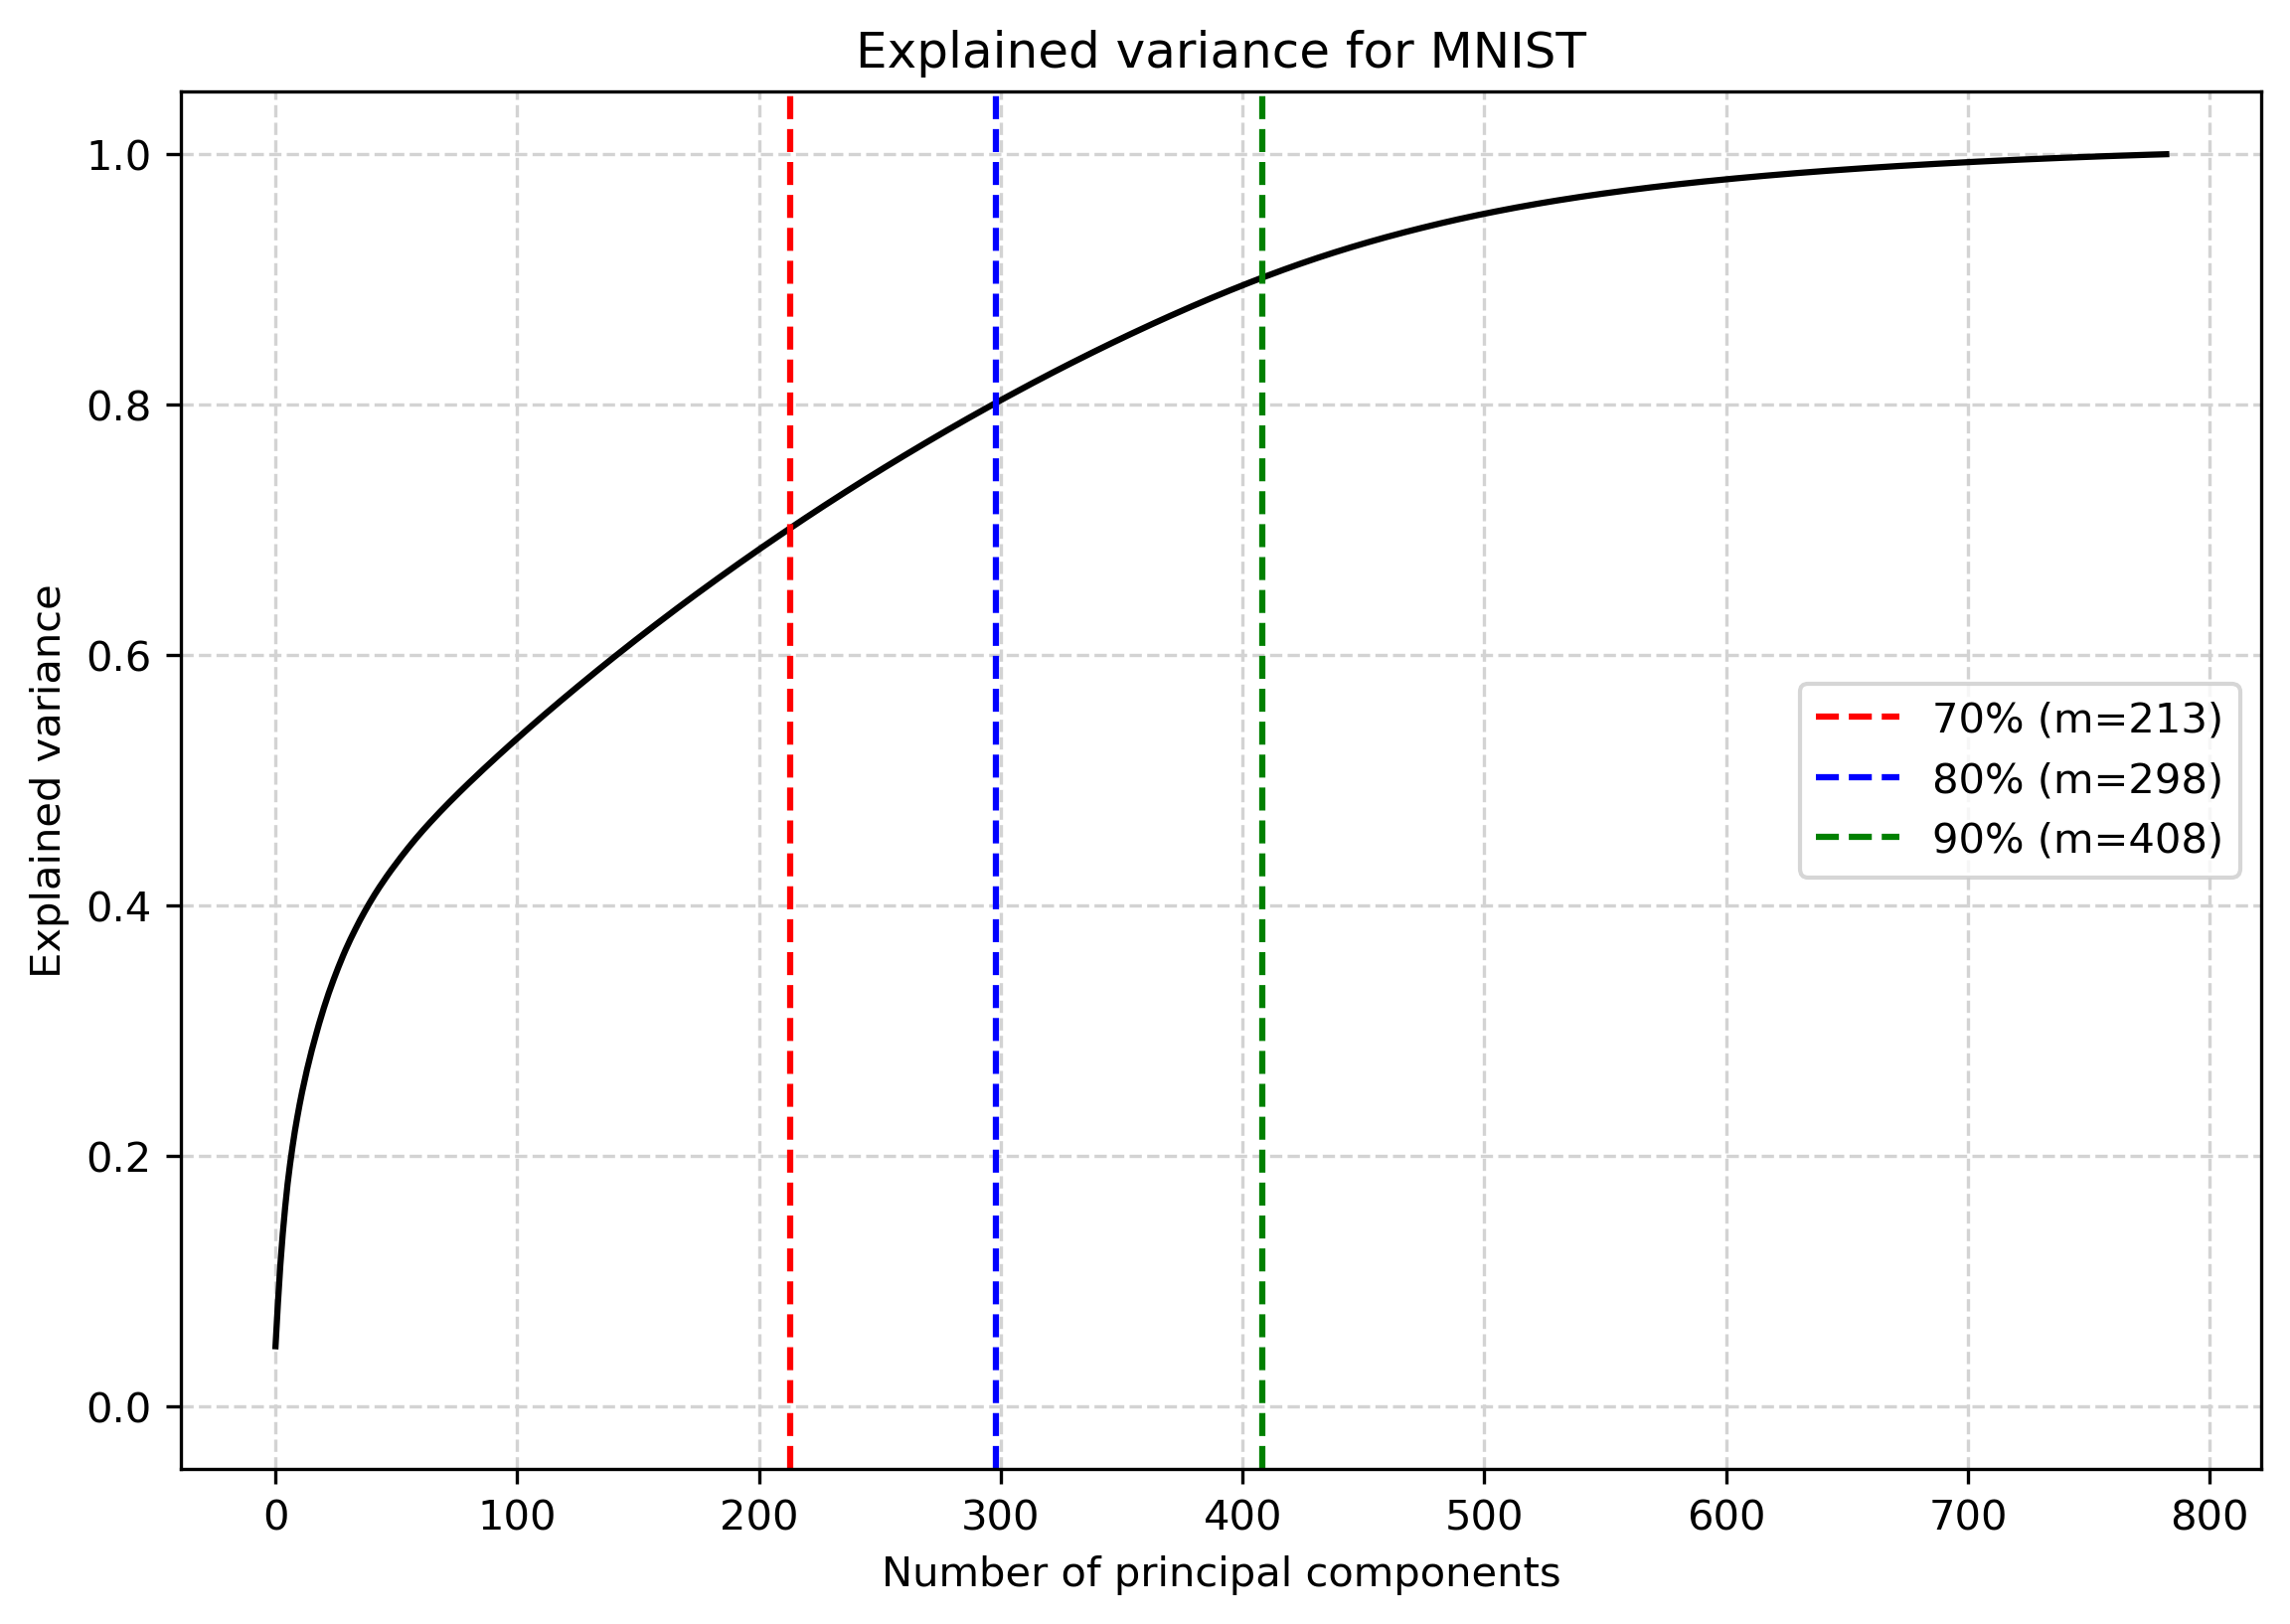

In [524]:
first_70 = min_index(explained_variances>0.7)+1
first_80 = min_index(explained_variances>0.8)+1
first_90 = min_index(explained_variances>0.9)+1
plt.plot(explained_variances, color="black")
plt.ylim(-0.05,1.05)
plt.xlabel("Number of principal components")
plt.ylabel("Explained variance")
plt.title("Explained variance for MNIST")
plt.axvline(x=first_70, color="red", linestyle="--", label=f"70% (m={first_70})")
plt.axvline(x=first_80, color="blue", linestyle="--", label=f"80% (m={first_80})")
plt.axvline(x=first_90, color="green", linestyle="--", label=f"90% (m={first_90})")
plt.legend(loc = "center right")
plt.show()

In [525]:
print(f"70% of the variance is explained by {first_70} principal components")
print(f"80% of the variance is explained by {first_80} principal components")
print(f"90% of the variance is explained by {first_90} principal components")

70% of the variance is explained by 213 principal components
80% of the variance is explained by 298 principal components
90% of the variance is explained by 408 principal components


In [526]:
X_pca, eigenvectors, eigenvalues = pca_function(noisy_MNIST_train, 10)

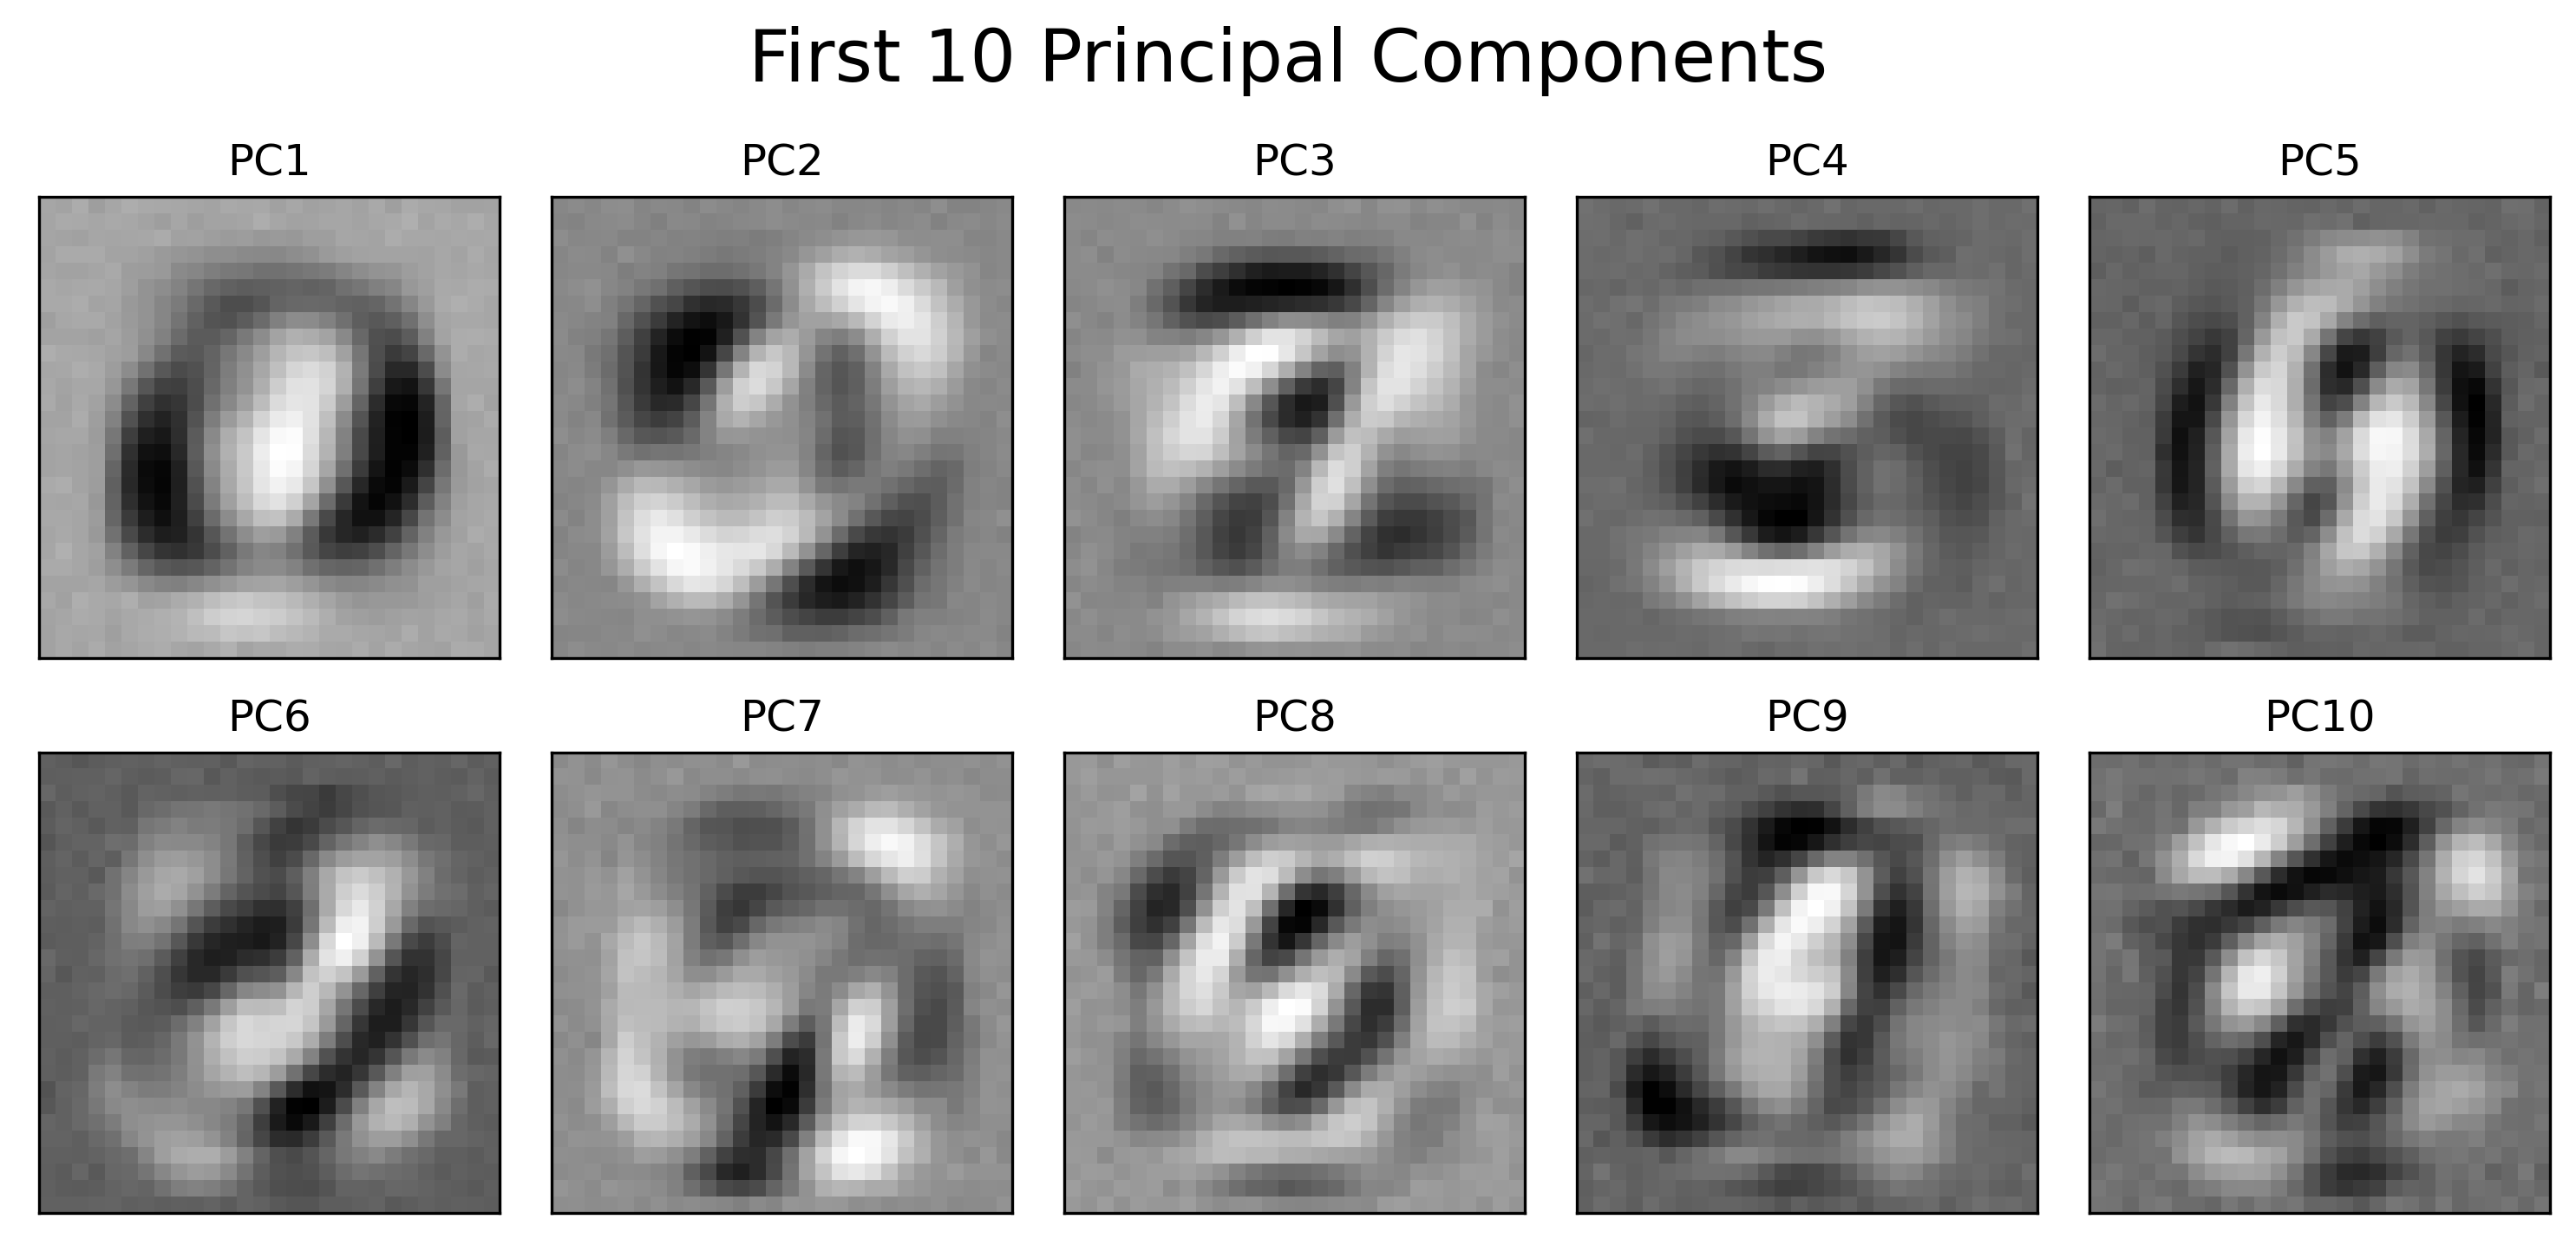

In [624]:
# visualise the first 10 principal components
fig, axs = plt.subplots(2, 5, figsize=(10, 5))

for ax in axs:
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        a.grid(False)

for i in range(10):
    axs[i//5, i%5].imshow(eigenvectors[:,i].reshape(28,28), cmap="gray")
    axs[i//5, i%5].set_title("PC"+str(i+1))
fig.suptitle("First 10 Principal Components", fontsize=20)
fig.tight_layout()
plt.show()

1.2.2

In [528]:
def normalize_nmf(X):
    X_norm = (X - np.min(X)) / (np.max(X) - np.min(X))
    return X_norm


noisy_MNIST_train_nmf = normalize_nmf(noisy_MNIST_train)

In [529]:
def chi2_cost(X,W,H):
    n = X.shape[0] + X.shape[1]
    diff = X-W@H
    chi2 = (np.sum((X * diff * diff)))/n

    return chi2

In [530]:
def nmf(X, m=10, max_iter=2_000):
    X = normalize_nmf(X)
    W = np.random.rand(X.shape[0], m)
    H = np.random.rand(m, X.shape[1])
    chi2 = []

    for _ in tqdm(range(max_iter)):
        # compute the update on H
        H = H * ((W.T @ X) / (W.T @ W @ H))

        # compute the update on W
        W = W * ((X @ H.T) / (W @ H @ H.T))

        chi2.append(chi2_cost(X,W,H))
    return W, H, chi2

In [531]:
W , H, chi2_arr = nmf(noisy_MNIST_train, 10, 1_000)

100%|██████████| 1000/1000 [00:29<00:00, 34.28it/s]


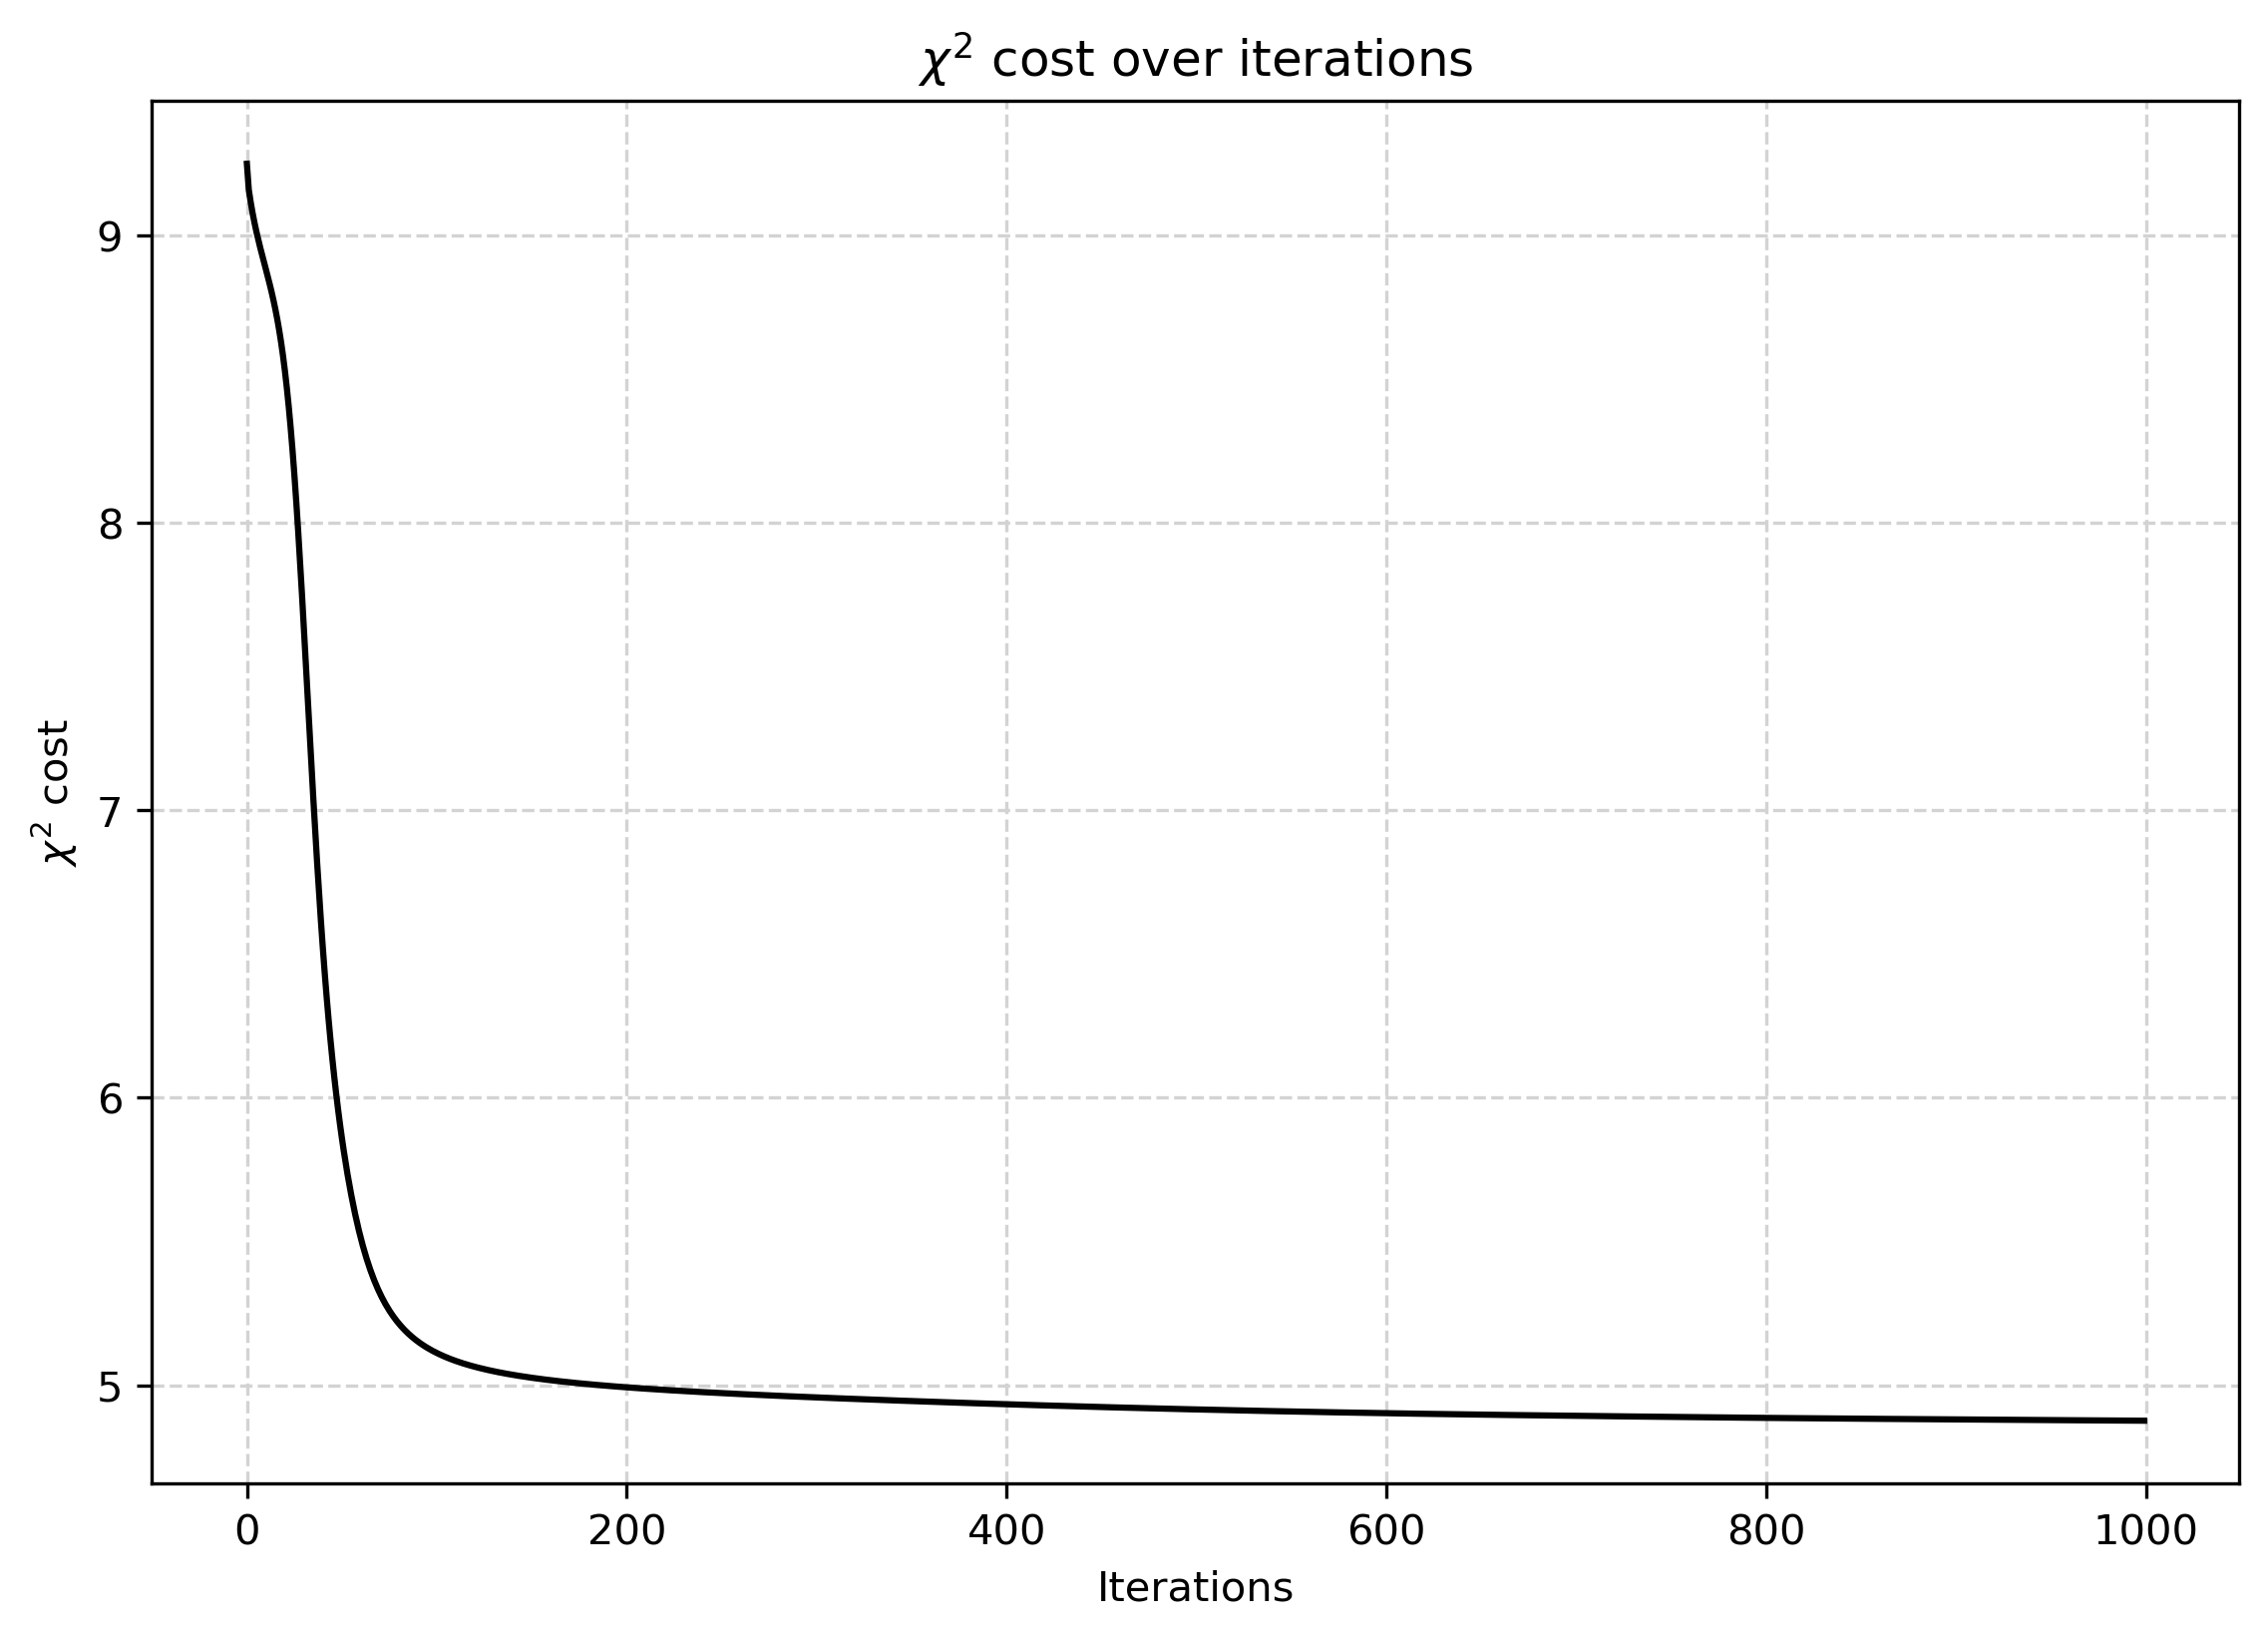

In [532]:
plt.plot(chi2_arr, color="black")
plt.title("$\chi^2$ cost over iterations")
plt.xlabel("Iterations")
plt.ylabel("$\chi^2$ cost")
plt.show()

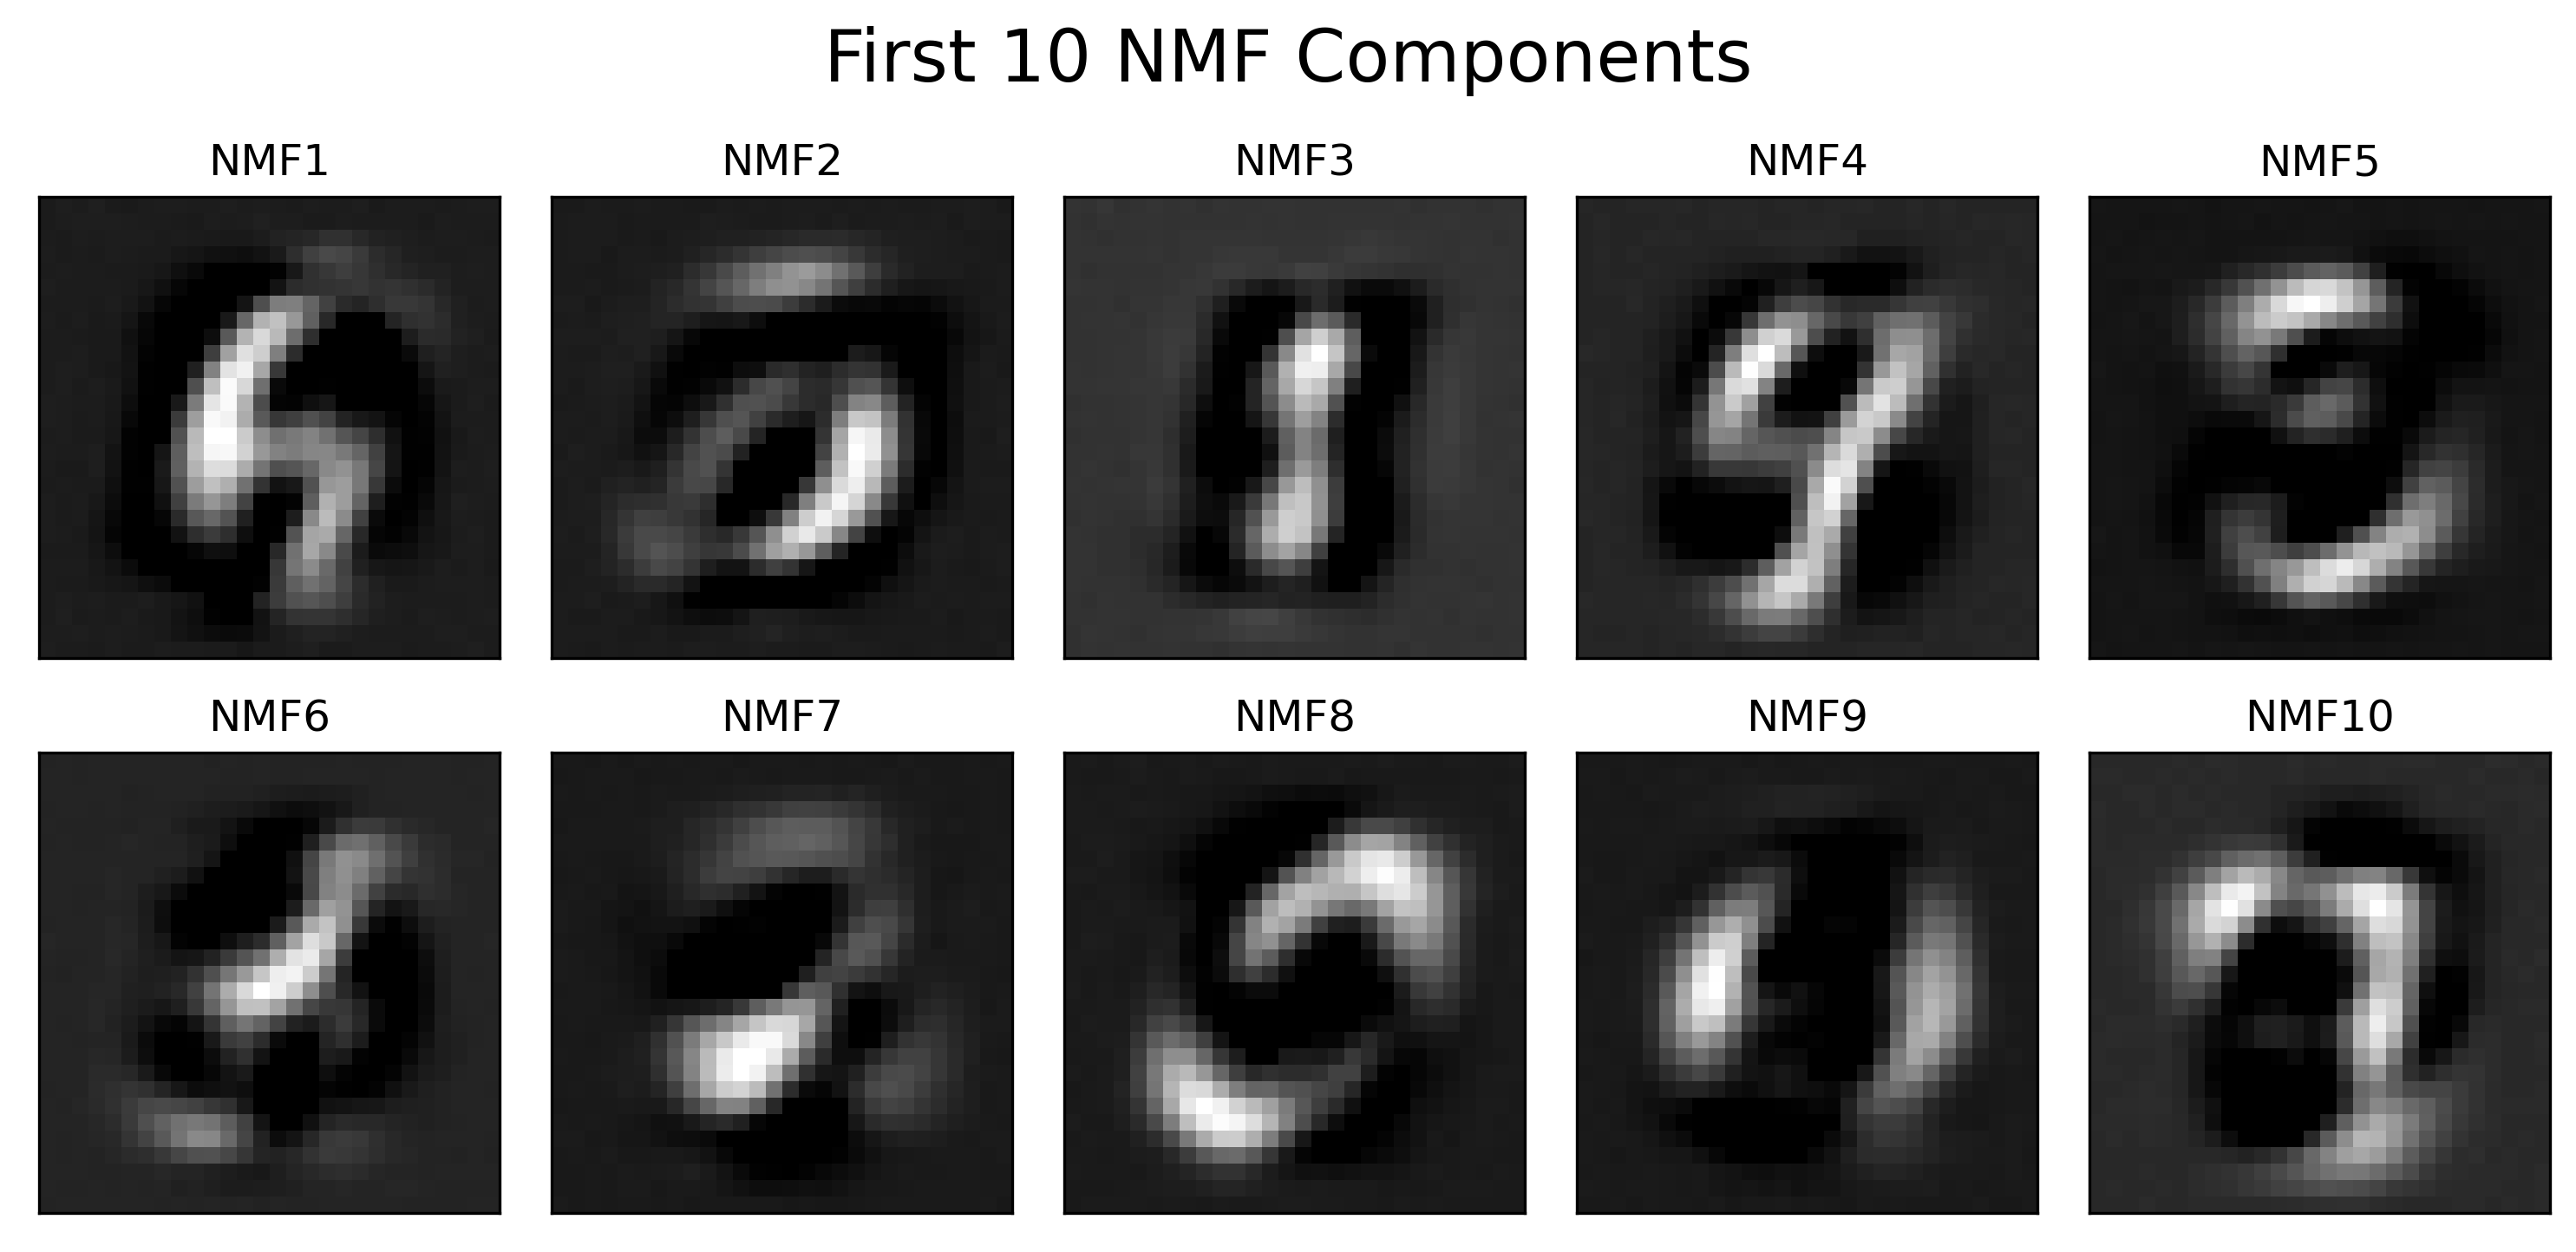

In [623]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))

for ax in axs:
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        a.grid(False)
        
for i in range(10):
    axs[i//5, i%5].imshow(H[i].reshape(28,28), cmap='gray')
    axs[i//5, i%5].set_title("NMF"+str(i+1))
fig.suptitle("First 10 NMF Components", fontsize=20)
fig.tight_layout()
plt.show()

1.2.3

In [588]:
def reconstruct_pca(X_test, train_evectors):
    X_test_norm = normalize_pca(X_test)
    X_test_pca = X_test_norm@train_evectors
    X_test_reconstructed = X_test_pca@train_evectors.T
    return X_test_reconstructed

def reconstruct_nmf(X_test, H_train):
    X_test_norm = normalize_nmf(X_test)
    X_test_nmf = X_test_norm@H_train.T@H_train
    return X_test_nmf


In [589]:
W_trained, H_trained, _ = nmf(noisy_MNIST_train, 100, 2_000)
X_pca_trained, eigenvectors_trained, eigenvalues_trained = pca_function(noisy_MNIST_train, 100)

100%|██████████| 2000/2000 [02:43<00:00, 12.26it/s]


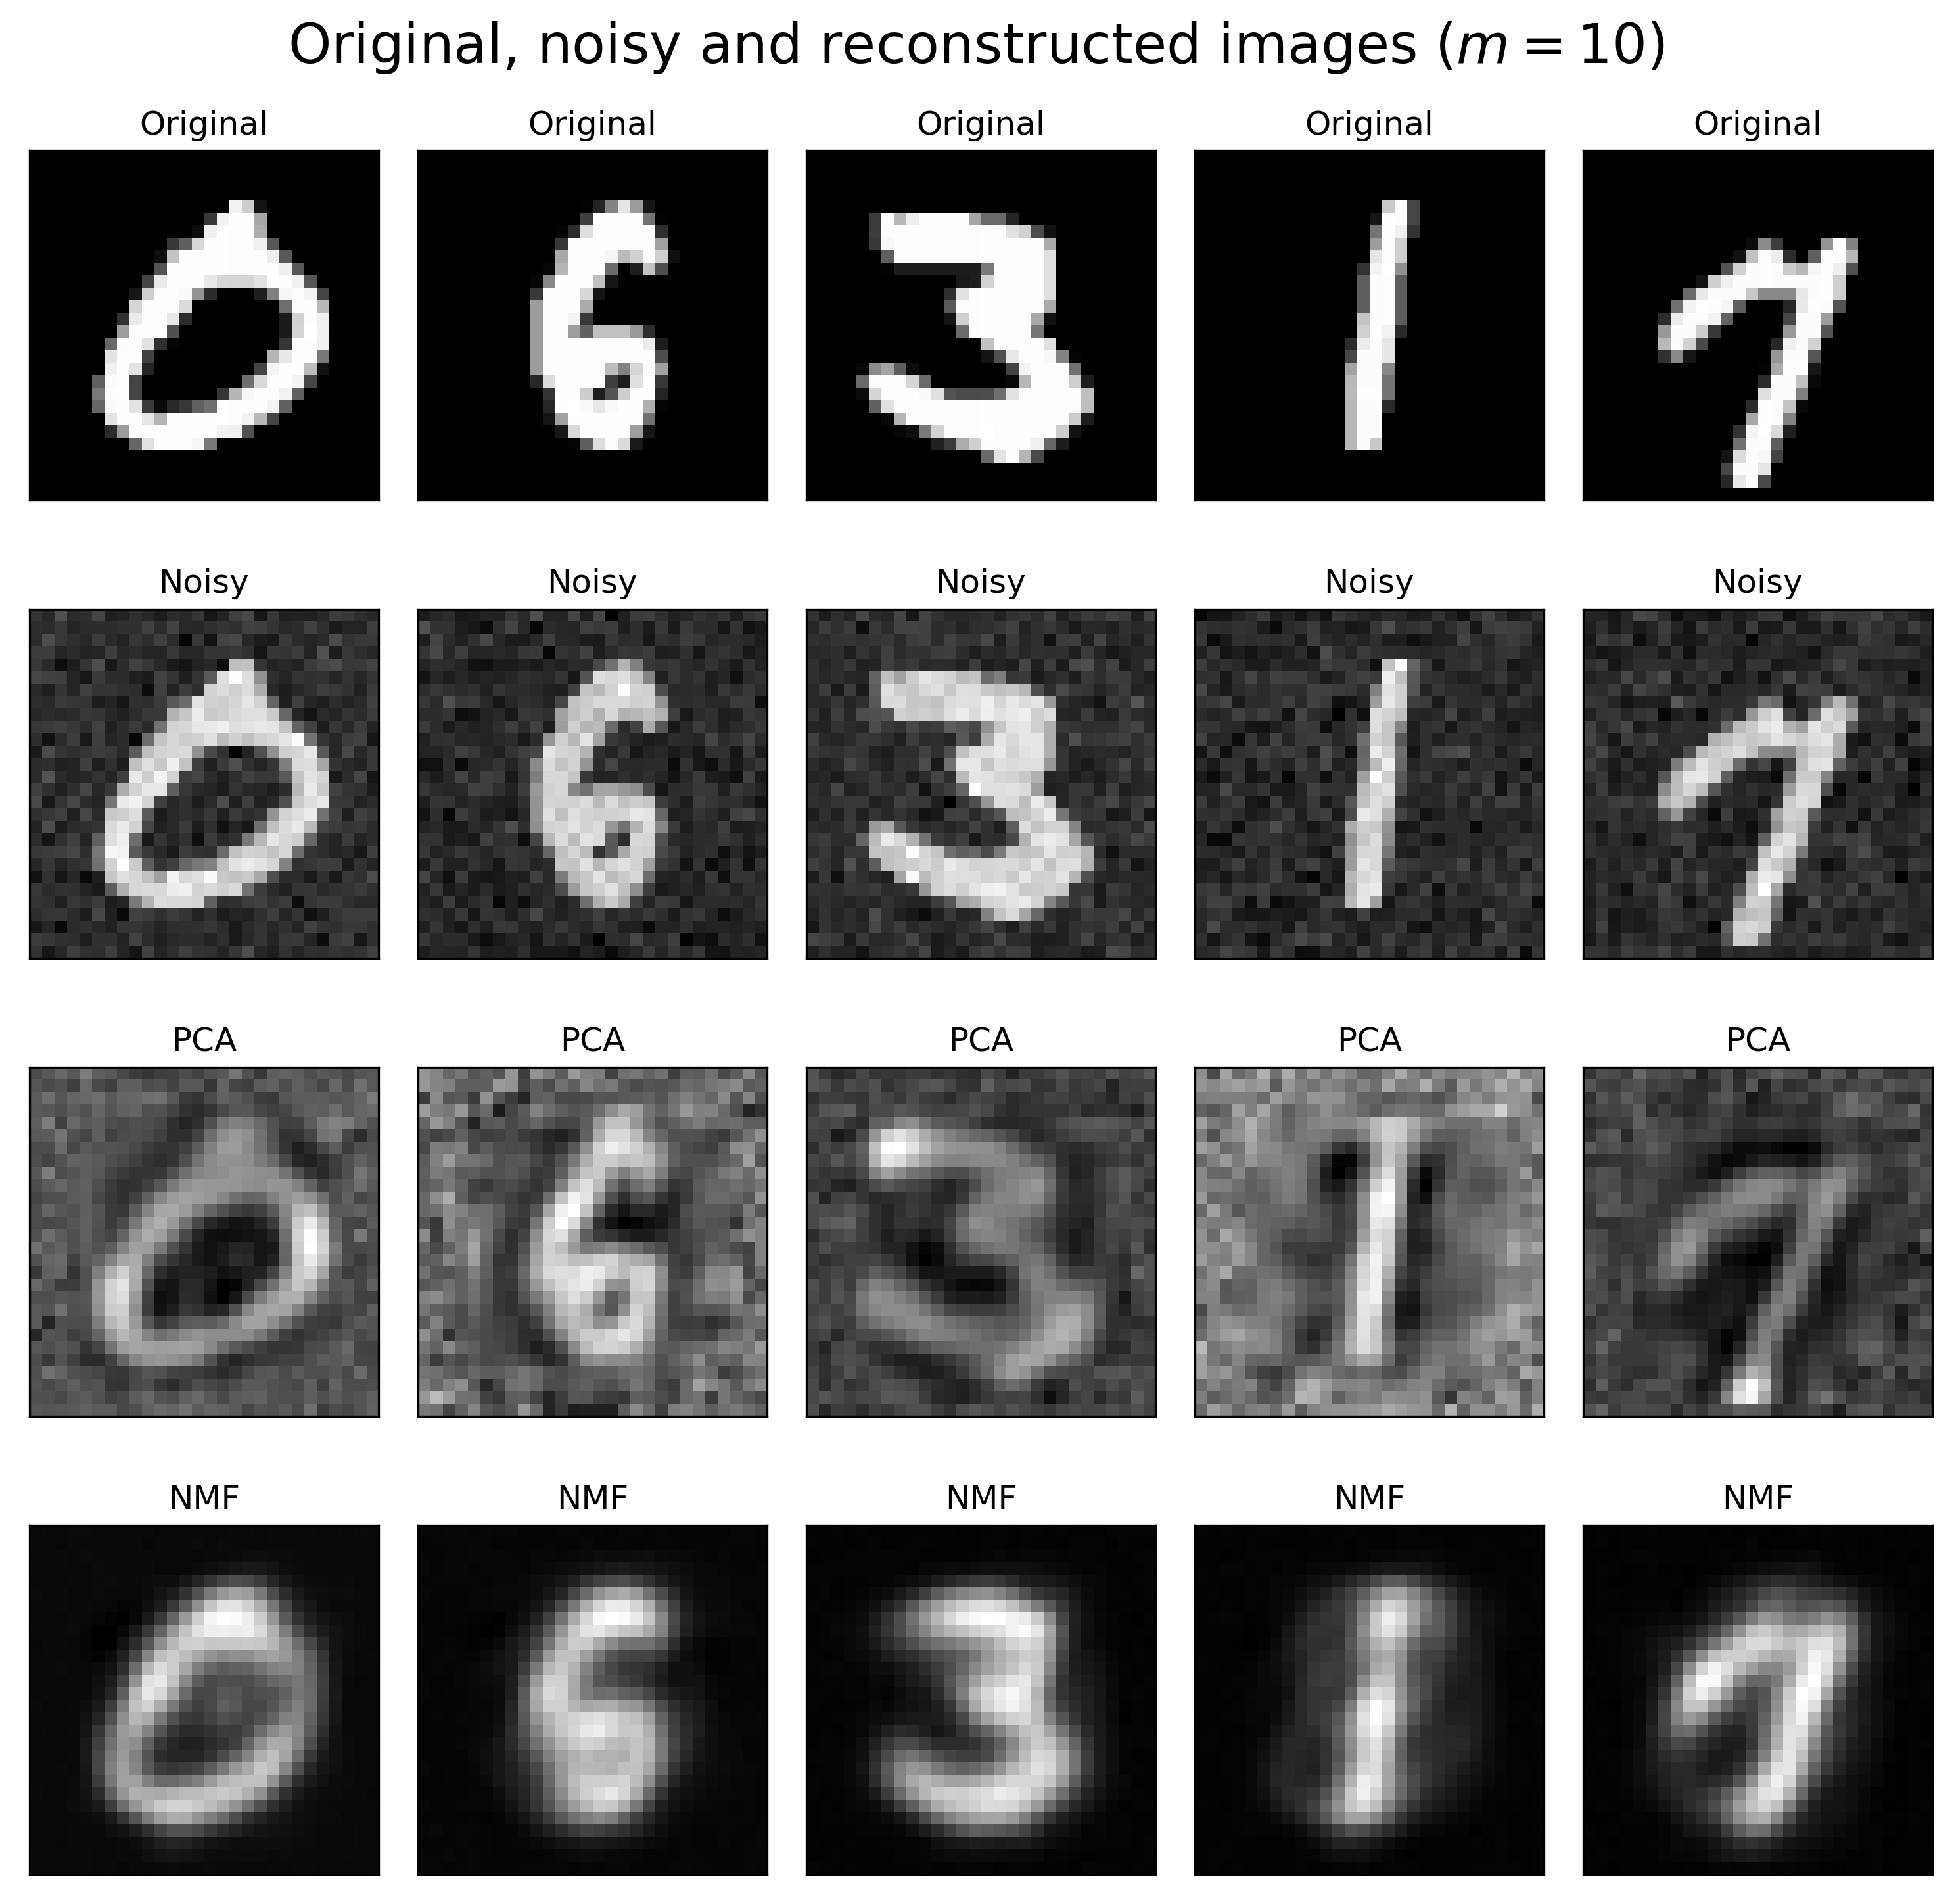

In [640]:
noisy_MNIST_test_pca = normalize_pca(noisy_MNIST_test)
noisy_MNIST_test_nmf = normalize_nmf(noisy_MNIST_test)
# compute image reconstruction using PCA
PCA_reconstructions = reconstruct_pca(noisy_MNIST_test, eigenvectors_trained)
NMF_reconstructions = reconstruct_nmf(noisy_MNIST_test, H_trained)
# plot original, noisy and reconstructed images
fig, axs = plt.subplots(4, 5, figsize=(10, 10))

for ax in axs:
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        a.grid(False)

for i in range(5):
    # turn off grid and ticks
    axs[0, i].imshow(MNIST_test_samples[i].reshape(28,28), cmap='gray')
    axs[0, i].set_title("Original")
    axs[1, i].imshow(noisy_MNIST_test[i].reshape(28,28), cmap='gray')
    axs[1, i].set_title("Noisy")
    axs[2, i].imshow(PCA_reconstructions[i].reshape(28,28), cmap='gray')
    axs[2, i].set_title("PCA")
    axs[3, i].imshow(NMF_reconstructions[i].reshape(28,28), cmap='gray')
    axs[3, i].set_title("NMF")

fig.suptitle("Original, noisy and reconstructed images $(m=10)$", fontsize=20)
fig.tight_layout()
plt.show()


1.2.4

In [592]:
def MSE(X, X_reconstructed):
    return np.mean((X - X_reconstructed)**2)

In [593]:
reconstructions_m = {}
mses_original_m = {}
mses_noisy_m = {}
evectors_m_d = {}
for k in tqdm(range(5,401,5)):
    _, evectors_m, _ = pca_function(noisy_MNIST_train, k)
    PCA_reconstructions_m = reconstruct_pca(noisy_MNIST_test, evectors_m)
    mses_original = MSE(normalize_pca(MNIST_test_samples), PCA_reconstructions_m)
    mses_noisy = MSE(normalize_pca(noisy_MNIST_test), PCA_reconstructions_m)
    reconstructions_m[k] = PCA_reconstructions_m
    mses_original_m[k] = mses_original
    mses_noisy_m[k] = mses_noisy
    evectors_m_d[k] = evectors_m




100%|██████████| 80/80 [01:47<00:00,  1.35s/it]


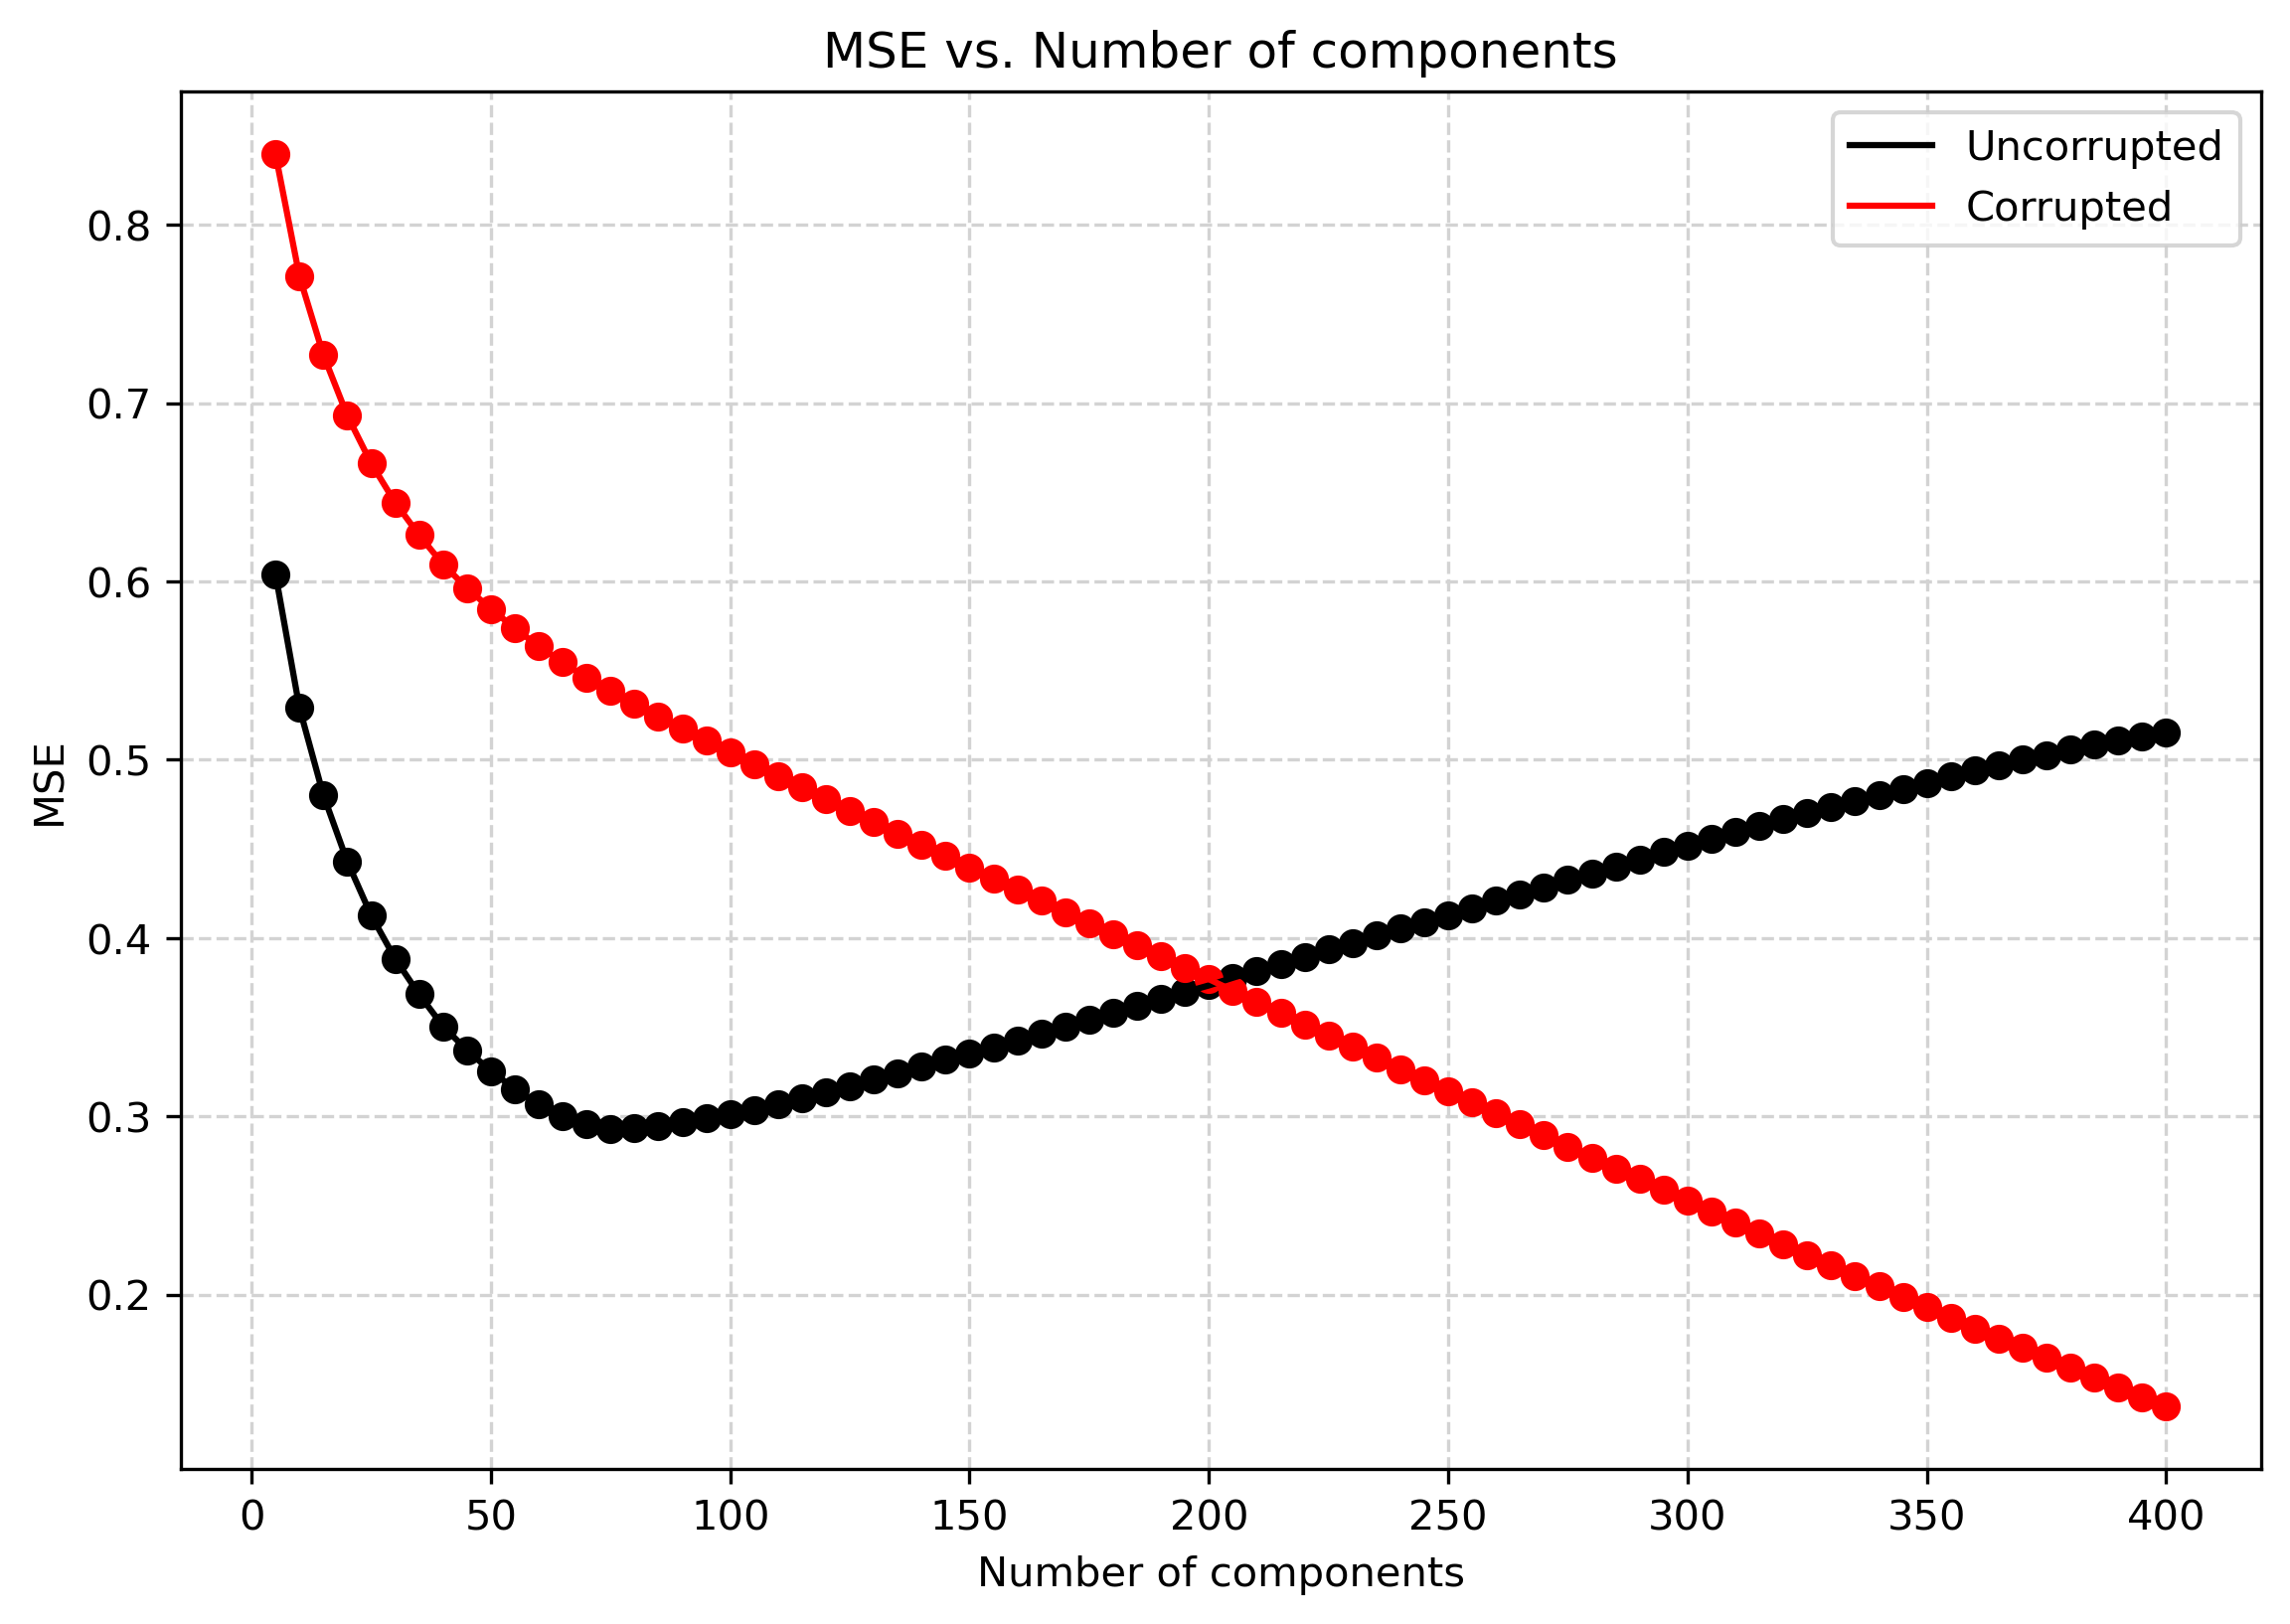

In [595]:
plt.plot(list(mses_original_m.keys()), list(mses_original_m.values()), color="black", label="Uncorrupted")
plt.scatter(list(mses_original_m.keys()), list(mses_original_m.values()), color="black")
plt.plot(list(mses_noisy_m.keys()), list(mses_noisy_m.values()), color="red", label="Corrupted")
plt.scatter(list(mses_noisy_m.keys()), list(mses_noisy_m.values()), color="red")
plt.title("MSE vs. Number of components")
plt.xlabel("Number of components")
plt.ylabel("MSE")
plt.legend()
plt.show()

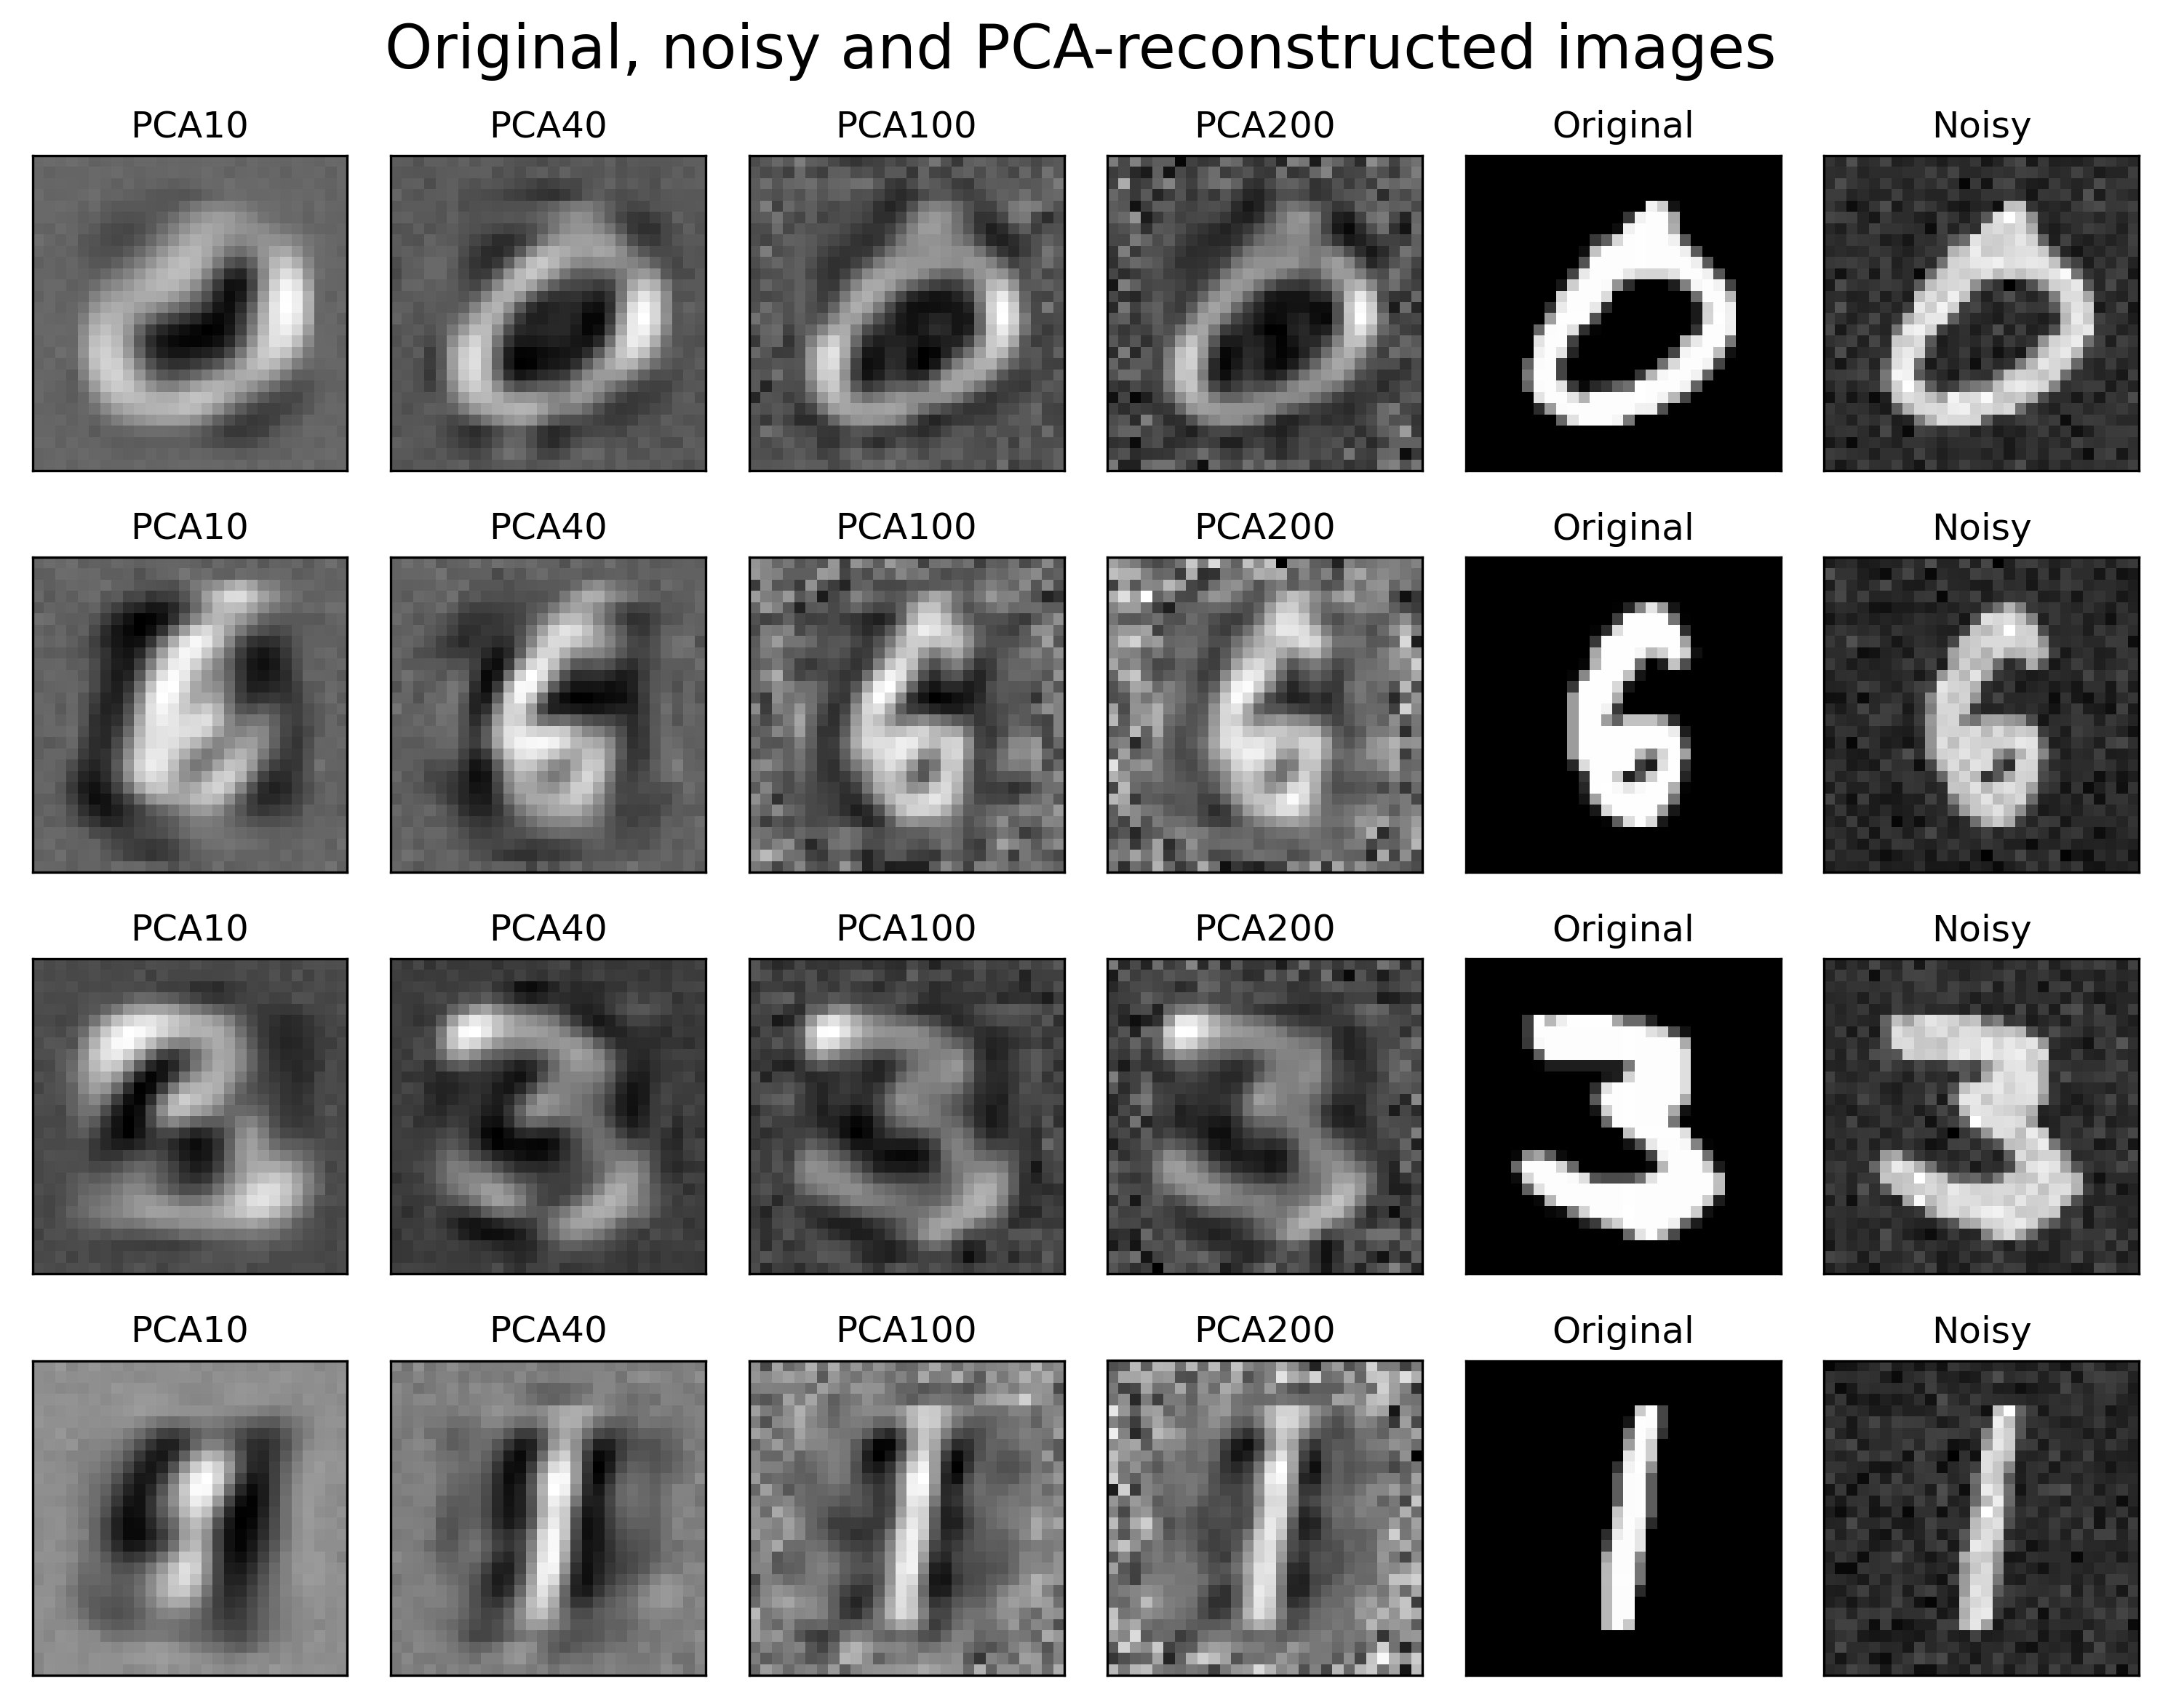

In [642]:
visualised_m = [10, 40, 100, 200]
# visualise the reconstructed images for different number of components
fig, axs = plt.subplots(4, 6, figsize=(10, 8))

for ax in axs:
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        a.grid(False)
        
for j in range(4):
    for i in range(4):
        axs[j,i].imshow(reconstructions_m[visualised_m[i]][j].reshape(28,28), cmap='gray')
        axs[j,i].set_title("PCA"+str(visualised_m[i]))
    axs[j,-2].imshow(MNIST_test_samples[j].reshape(28,28), cmap='gray')
    axs[j,-2].set_title("Original")
    axs[j,-1].imshow(noisy_MNIST_test[j].reshape(28,28), cmap='gray')
    axs[j,-1].set_title("Noisy")

fig.suptitle("Original, noisy and PCA-reconstructed images", fontsize=20)
fig.tight_layout()
plt.show()

#### 1.3 Gaussian Mixture Models (20 marks)
1.3.1

In [679]:
X_pca_gmm, eigenvectors_gmm, eigenvalues_gmm = pca_function(MNIST_train_samples[:1000,:], 5)

In [680]:
class GMModel:
    
    def __init__(self, X, dim):
        """Initialises parameters through random split of the data"""
        
        self.dim = dim

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        n, _ = X.shape 
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.dim)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 

    ## EDIT THIS FUNCTION
def cluster_probabilities(gmm, X):
    """Predicts probability of each data point with respect to each cluster"""
    
    # n has the number of rows while m has the number of columns of dataset X
    n  = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = sp.stats.multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) ### <- fill in
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
    return weights

## EDIT THIS FUNCTION
def predict_gmm(gmm, X):
    """Performs hard clustering"""
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1) ### <- fill in MAP estimate

## EDIT THIS FUNCTION
def fitStep(gmm,X):
    """Performs an EM step by updating all parameters"""
    
    # E-Step: update weights and phi holding mu and sigma constant
    weights = cluster_probabilities(gmm,X) ### <- fill in
    gmm.phi = weights.mean(axis=0)
        
    # M-Step: update mu and sigma holding pi and weights constant
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight 
        gmm.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True) ### <- fill in

In [681]:
gmm = GMModel(X_pca_gmm, 10)
for i in tqdm(range(1_000)):
    fitStep(gmm, X_pca_gmm)

100%|██████████| 1000/1000 [00:08<00:00, 124.60it/s]


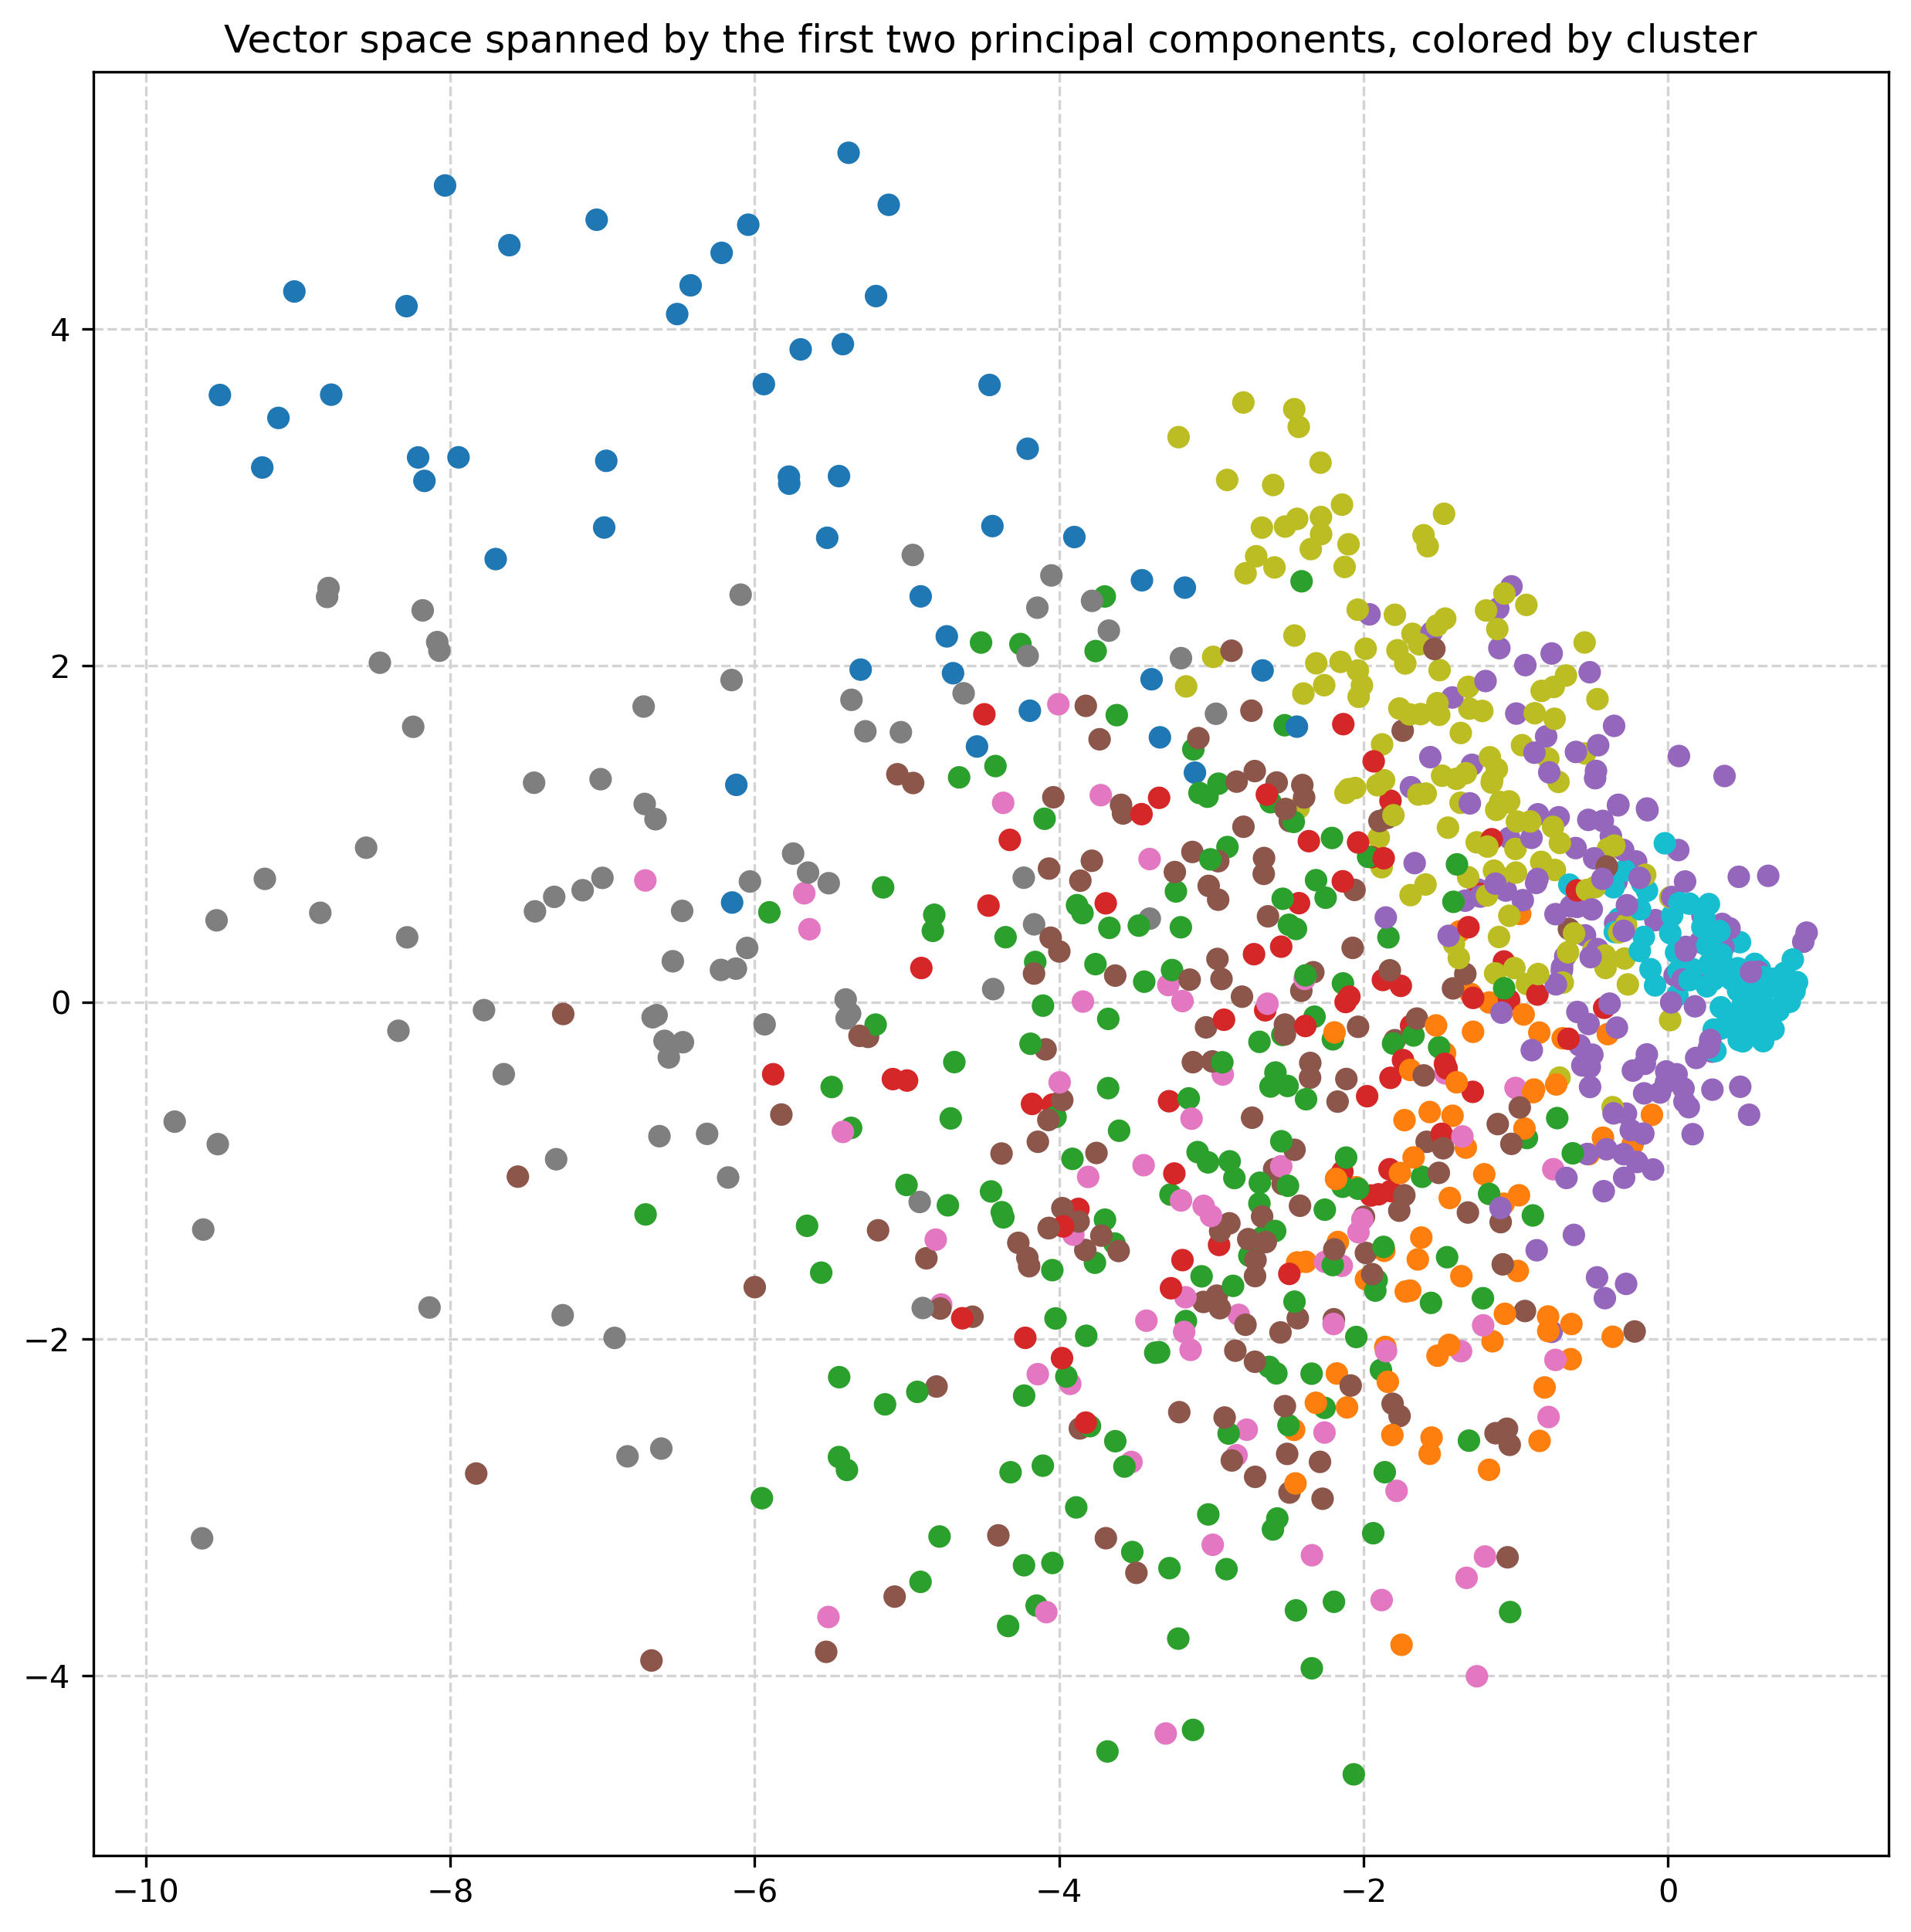

In [698]:
# define cmap for the plots
cmap = plt.cm.get_cmap('tab10')
# set colors for the clusters
colors = [cmap(i) for i in range(10)]
# visualise vector space spanned by the first two principal components, colored by cluster
predicted_labels_gmm = predict_gmm(gmm, X_pca_gmm)
plt.figure(figsize=(10,10))
plt.scatter(X_pca_gmm[:,0], X_pca_gmm[:,1], c=predicted_labels_gmm, cmap="tab10")
plt.title("Vector space spanned by the first two principal components, colored by cluster")
plt.show()


1.3.2

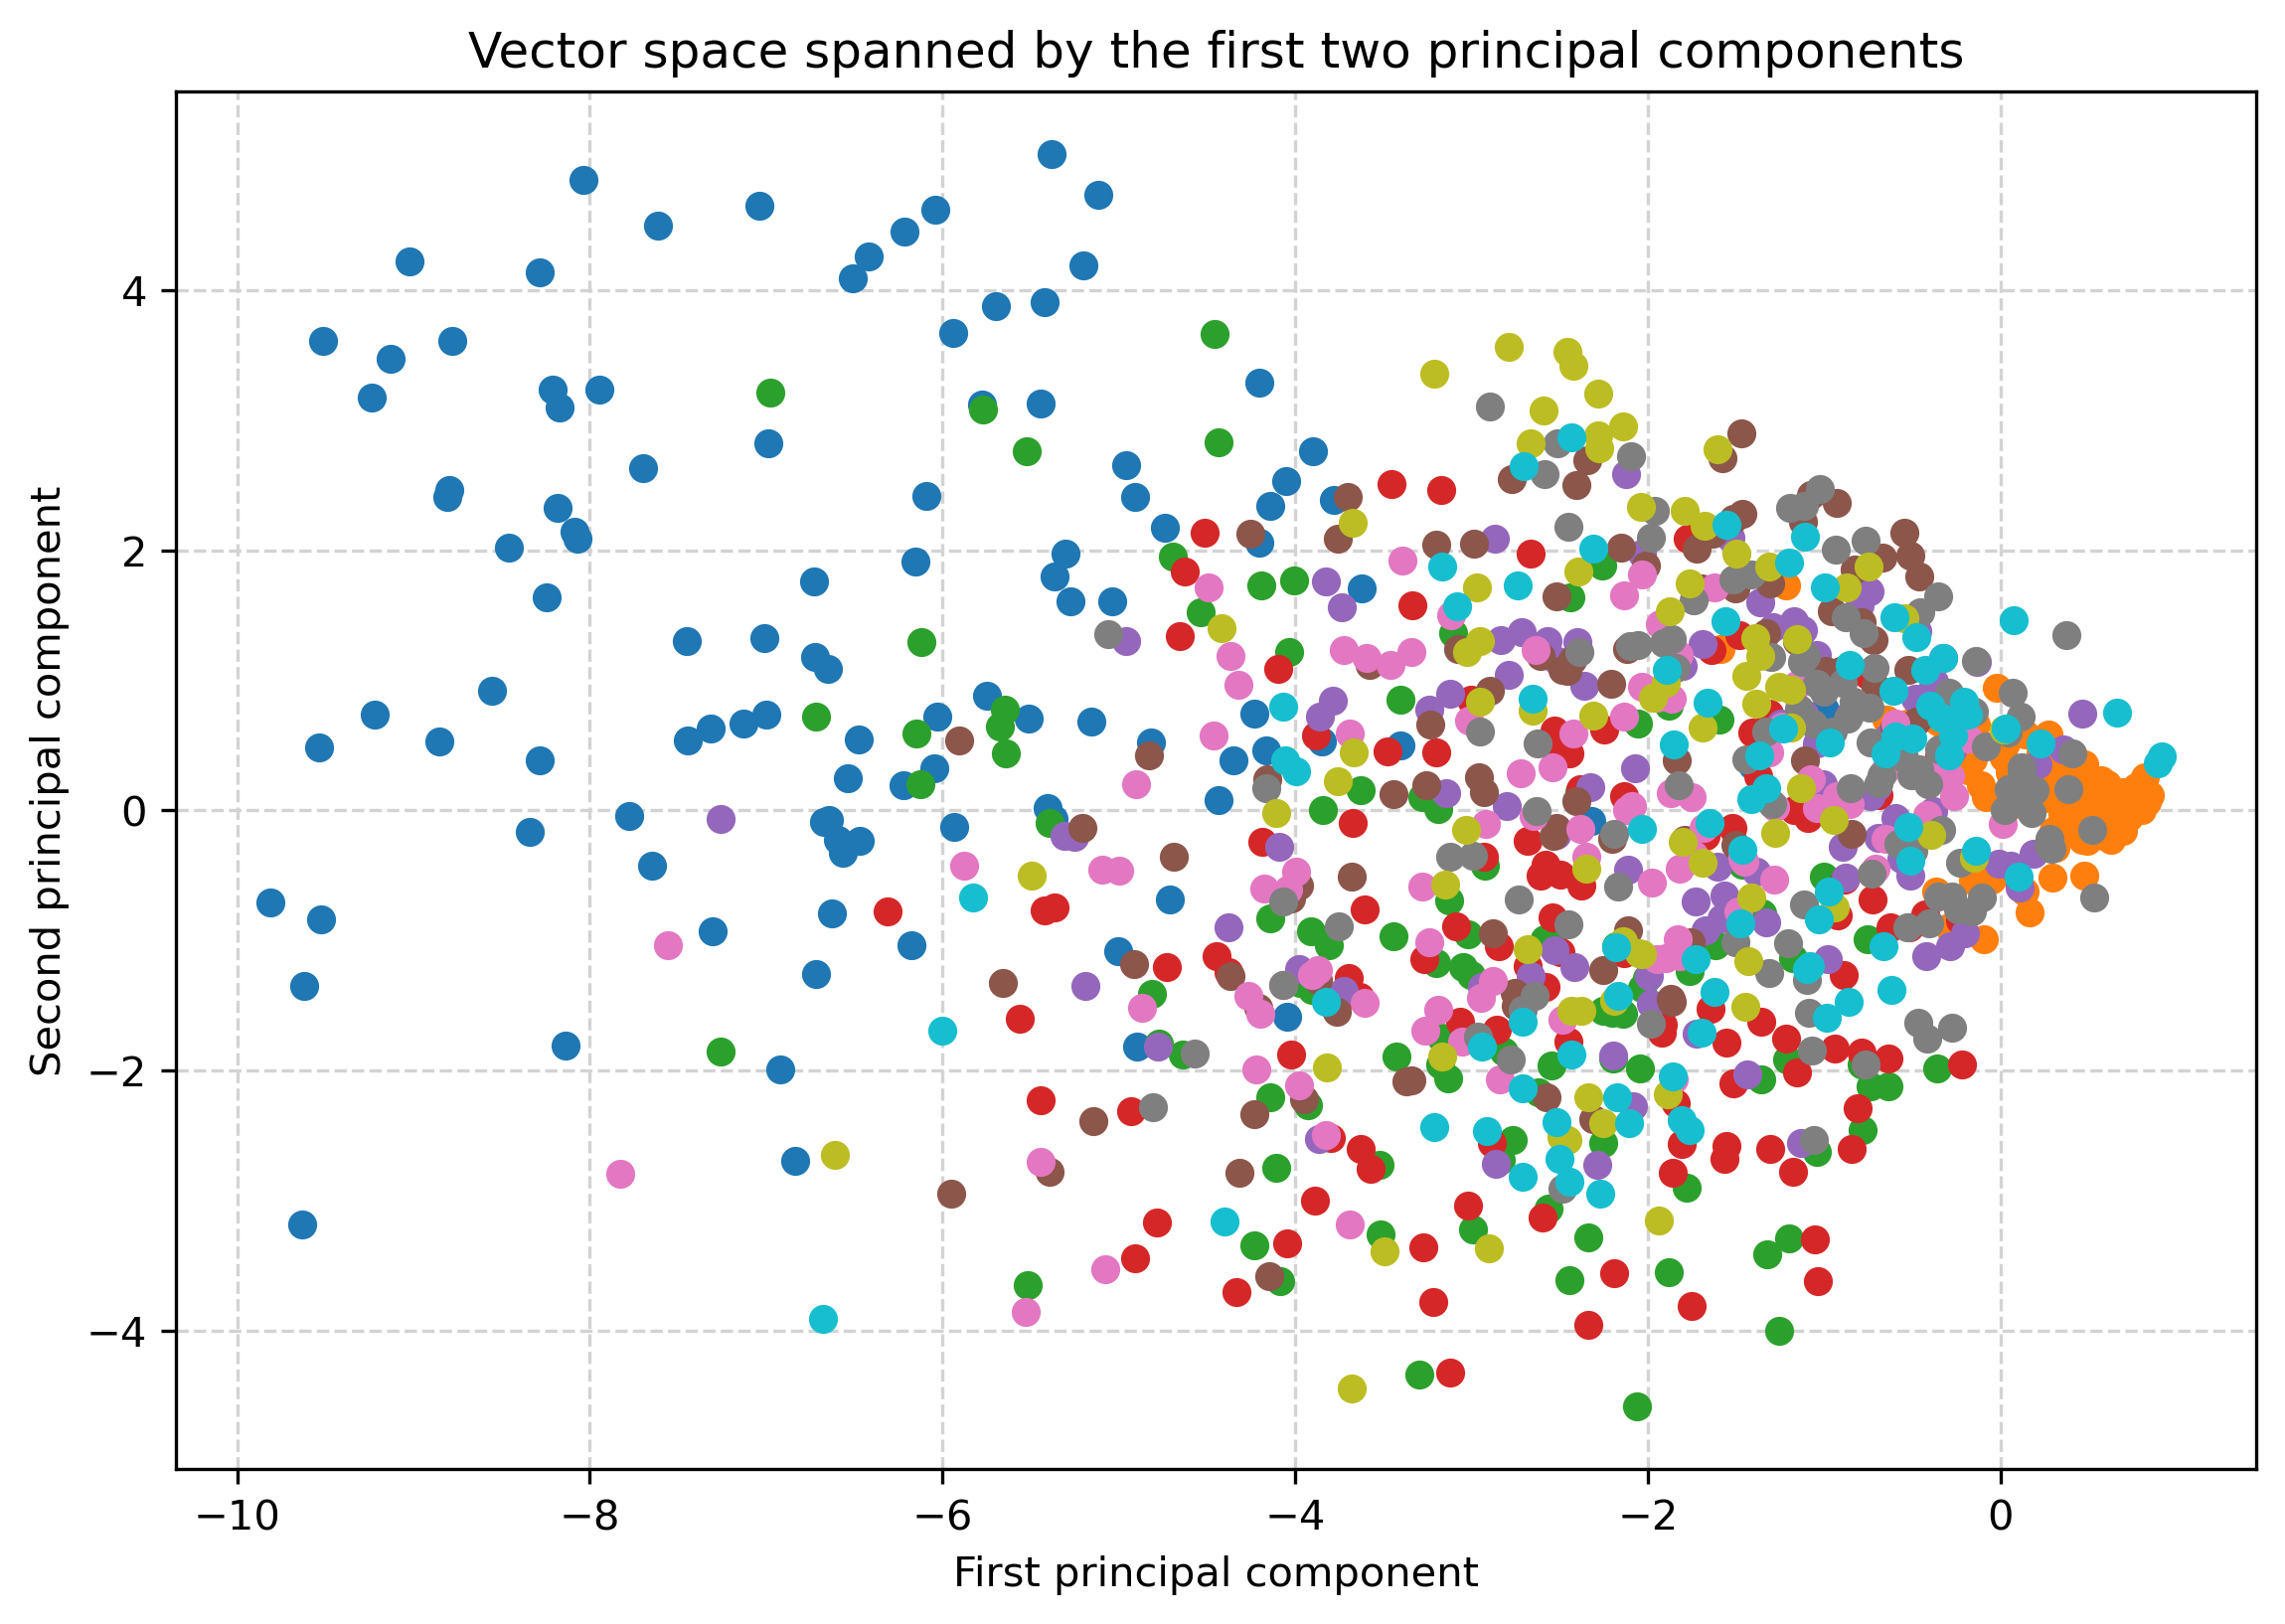

In [699]:
for label in range(10):
    plt.scatter(X_pca_gmm[MNIST_train_labels[:1000] == label, 0], X_pca_gmm[MNIST_train_labels[:1000] == label, 1], color=colors[label])
plt.title("Vector space spanned by the first two principal components")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

In [707]:
# Map the class labels to the best-fitting cluster index
class_to_cluster = {}
for label in range(10):
    class_to_cluster[label] = np.argmax(np.bincount(predicted_labels_gmm[MNIST_train_labels[:1000] == label]))

for label in range(10):
    print(f"Class {label}: Cluster {class_to_cluster[label]}, Log-likelihood: {np.log(cluster_probabilities(gmm, X_pca_gmm[MNIST_train_labels[:1000] == label])[:, class_to_cluster[label]]).mean()}")
    print()

Class 0: Cluster 7, Log-likelihood: -2.2838505020694027

Class 1: Cluster 9, Log-likelihood: -2.7681674912305057

Class 2: Cluster 6, Log-likelihood: -3.062155556224218

Class 3: Cluster 2, Log-likelihood: -1.0997221763040477

Class 4: Cluster 5, Log-likelihood: -1.6656261458121115

Class 5: Cluster 2, Log-likelihood: -3.4443750543291327

Class 6: Cluster 3, Log-likelihood: -2.59456877524171

Class 7: Cluster 4, Log-likelihood: -9.788498315643244

Class 8: Cluster 8, Log-likelihood: -12.499496574141938

Class 9: Cluster 4, Log-likelihood: -17.81751634791852



1.3.3

In [715]:
# Use the label-cluster index map to compute the cluster probabilities for each digit.

cluster_p = {}
for label in range(10):
    # compute the cluster probabilities for each digit
    cluster_p[label] = cluster_probabilities(gmm, X_pca_gmm[MNIST_train_labels[:1000] == label])[:, class_to_cluster[label]]

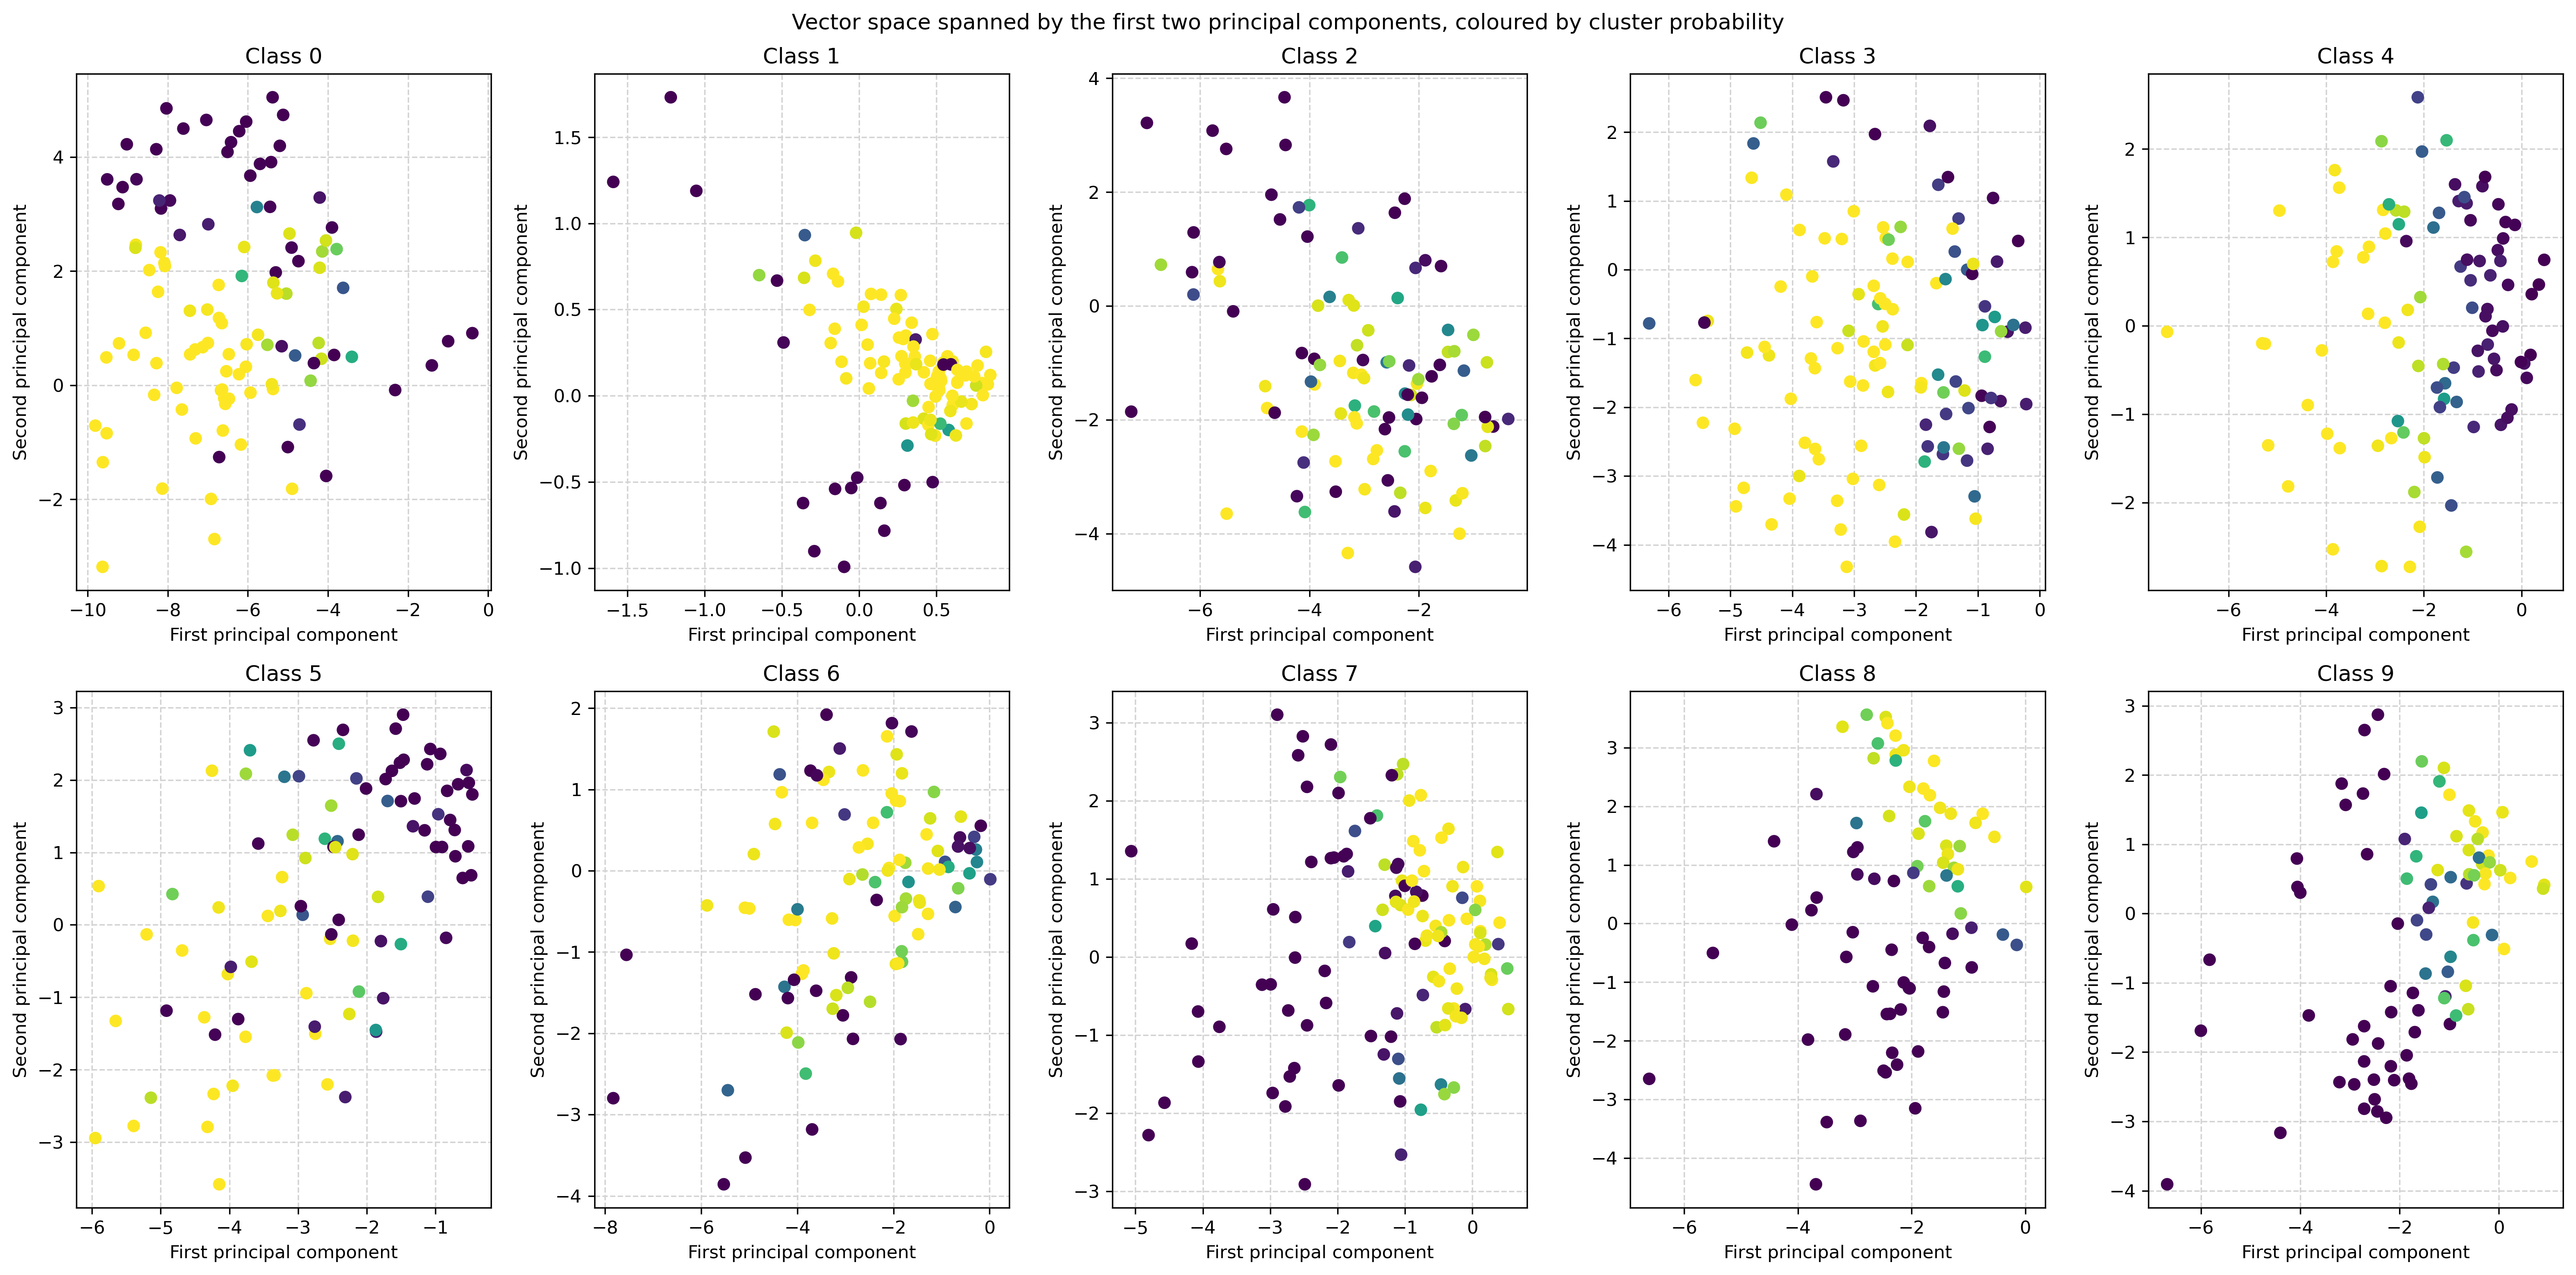

In [719]:
# for each class, visualise the space spanned by the top two components by colouring each point according to the cluster probability of the best-fitting cluster.
# use subfigures to visualise the 10 classes in a single figure

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(5):
    for j in range(2):
        label = i + j*5
        axs[j,i].scatter(X_pca_gmm[MNIST_train_labels[:1000] == label, 0], X_pca_gmm[MNIST_train_labels[:1000] == label, 1], c=cluster_p[label], cmap="viridis")
        axs[j,i].set_title(f"Class {label}")
        axs[j,i].set_xlabel("First principal component")
        axs[j,i].set_ylabel("Second principal component")

fig.suptitle("Vector space spanned by the first two principal components, coloured by cluster probability")
fig.tight_layout()
plt.show()

1.3.4

In [720]:
gmm_5 = GMModel(X_pca_gmm, 5)
for i in tqdm(range(1_000)):
    fitStep(gmm_5, X_pca_gmm)
gmm_8 = GMModel(X_pca_gmm, 8)
for i in tqdm(range(1_000)):
    fitStep(gmm_8, X_pca_gmm)

predicted_labels_gmm_5 = predict_gmm(gmm_5, X_pca_gmm)
predicted_labels_gmm_8 = predict_gmm(gmm_8, X_pca_gmm)

100%|██████████| 1000/1000 [00:06<00:00, 151.36it/s]


In [721]:
class_to_cluster_5 = {}
for label in range(10):
    class_to_cluster_5[label] = np.argmax(np.bincount(predicted_labels_gmm_5[MNIST_train_labels[:1000] == label]))

class_to_cluster_8 = {}
for label in range(10):
    class_to_cluster_8[label] = np.argmax(np.bincount(predicted_labels_gmm_8[MNIST_train_labels[:1000] == label]))

In [724]:
print("Reduced GMM model with 5 clusters")
print()
for label in range(10):
    print(f"Class {label}: Cluster {class_to_cluster_5[label]}, Log-likelihood: {np.log(cluster_probabilities(gmm_5, X_pca_gmm[MNIST_train_labels[:1000] == label])[:, class_to_cluster_5[label]]).mean()}")
    print()

Reduced GMM model with 5 clusters

Class 0: Cluster 2, Log-likelihood: -0.1518048382213749

Class 1: Cluster 4, Log-likelihood: -2.450273269554611

Class 2: Cluster 2, Log-likelihood: -0.6423529905464607

Class 3: Cluster 3, Log-likelihood: -1.0181186308872747

Class 4: Cluster 1, Log-likelihood: -0.49980385745130224

Class 5: Cluster 3, Log-likelihood: -1.9868079841592978

Class 6: Cluster 0, Log-likelihood: -4.496312448888284

Class 7: Cluster 1, Log-likelihood: -0.33496654231038037

Class 8: Cluster 3, Log-likelihood: -1.3127789526580838

Class 9: Cluster 1, Log-likelihood: -0.3305622912767631



In [726]:
print("Reduced GMM model with 8 clusters")
print()
for label in range(10):
    print(f"Class {label}: Cluster {class_to_cluster_8[label]}, Log-likelihood: {np.log(cluster_probabilities(gmm_8, X_pca_gmm[MNIST_train_labels[:1000] == label])[:, class_to_cluster_8[label]]).mean()}")
    print()

Reduced GMM model with 8 clusters

Class 0: Cluster 1, Log-likelihood: -0.4080539075128545

Class 1: Cluster 3, Log-likelihood: -2.7173566361397494

Class 2: Cluster 2, Log-likelihood: -2.050132249766029

Class 3: Cluster 0, Log-likelihood: -1.4984531550979707

Class 4: Cluster 5, Log-likelihood: -1.4198608352729718

Class 5: Cluster 0, Log-likelihood: -5.722645108976424

Class 6: Cluster 4, Log-likelihood: -16.232292303136678

Class 7: Cluster 7, Log-likelihood: -10.584032969879104

Class 8: Cluster 0, Log-likelihood: -4.364024353938239

Class 9: Cluster 5, Log-likelihood: -1.1236271176035029



### Task 2: Clustering and graph-based analysis (35 marks)

In [728]:
gene_expression_raw = pd.read_csv("data/gene_expression_data.csv")

gene_expression_raw.head()

Gene 0    Gene 1    Gene 2    Gene 3     Gene 4     Gene 5     Gene 6  \
0   9.796088  0.591871  0.591871  0.000000  11.420571  13.453759   4.411847   
1  10.070470  0.000000  0.000000  0.000000  13.085672  14.531863  10.462298   
2   8.970920  0.000000  0.452595  0.000000   8.263119   9.754908   8.964549   
3   8.524616  1.039419  0.434882  0.000000  10.798520  12.263020   7.440695   
4   8.047238  0.000000  0.000000  0.360982  12.283010  14.033759   8.719180   

     Gene 7     Gene 8     Gene 9  ...   Gene 86   Gene 87    Gene 88  \
0  5.412334  10.771613  10.225665  ...  5.974369  8.086513  12.727750   
1  9.832926  13.520312  13.968046  ...  0.000000  0.000000  11.197204   
2  9.948113   8.693773   8.776111  ...  3.907160  5.324101  11.487066   
3  8.062343   8.802083   9.237487  ...  4.296083  6.959747  12.974639   
4  8.831472   8.462073   8.211202  ...  0.000000  0.000000  11.337237   

     Gene 89    Gene 90    Gene 91   Gene 92    Gene 93    Gene 94  Type  
0  15.205717   6.438116   6.412577  0.000000   6.814730  13.618145  PRAD  
1  12.993933  10.800746  10.749811  0.000000  11.445610   0.000000  LUAD  
2  13.380596   6.656236  10.209734  0.000000   7.748830  12.759976  PRAD  
3  14.891812   6.030725   7.315648  0.434882   7.117924  12.353276  PRAD  
4  13.390061   5.989593   8.359671  0.000000   6.327545   0.000000  BRCA  

[5 rows x 96 columns]

In [837]:
mapping_dict= {}
for i, gene in enumerate(gene_expression_raw["Type"].unique()):
    mapping_dict[gene] = i

In [1069]:
types = gene_expression_raw["Type"].map(mapping_dict).to_numpy()
gene_expressions = gene_expression_raw.drop(columns=["Type"]).to_numpy()
gene_expressions = (gene_expressions - gene_expressions.mean(axis=0)) / gene_expressions.std(axis=0)


#### 2.1 Clustering (15 marks)
2.1.1

In [1070]:
# implement k-means clustering
def kmeans(X, k, max_iter=100):
    # initialise centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    for i in range(max_iter):
        # assign each data point to the closest centroid
        labels = np.argmin(np.linalg.norm(X[:,np.newaxis] - centroids[np.newaxis], axis=-1), axis=-1)
        # update centroids
        for j in range(k):
            # handle case where a cluster is empty
            if np.sum(labels == j) == 0:
                centroids[j] = X[np.random.choice(X.shape[0])]
            else:
                centroids[j] = X[labels == j].mean(axis=0)
    return labels, centroids

def calinski_harabasz(X, labels, centroids):
    # compute caliski-harabasz score for a given clustering
    # compute the within-cluster sum of squares
    WSS = 0
    for i in range(centroids.shape[0]):
        WSS += np.sum(np.linalg.norm(X[labels == i] - centroids[i], axis=-1)**2)
    # compute the between-cluster sum of squares
    BSS = 0
    for i in range(centroids.shape[0]):
        BSS += np.sum(np.linalg.norm(centroids[i] - centroids.mean(axis=0))**2) * X[labels == i].shape[0]
    # compute the calinski-harabasz score
    return (BSS / (centroids.shape[0] - 1)) / (WSS / (X.shape[0] - centroids.shape[0]))

def score_k(X, k, score_fn, max_iter=100, n=5, **score_kwargs):
    scores = []
    for _ in range(n):
        labels, centroids = kmeans(X, k, max_iter)
        score = score_fn(X, labels, centroids, **score_kwargs)
        scores.append(score)
    return np.mean(scores)


In [1071]:
# scan the number of clusters from 2 to 20
k_range = [i for i in range(2, 21)]
k_scores = []
for k in k_range:
    score = score_k(gene_expressions, k, calinski_harabasz, max_iter=100, n=5)
    print(f"Score for k={k}: {score}")
    k_scores.append(score)

Score for k=2: 250.85467614960484
Score for k=3: 671.6550979562465
Score for k=4: 244.5540260034714
Score for k=5: 209.8710911680424
Score for k=6: 184.6599965885126
Score for k=7: 163.72157976767562
Score for k=8: 179.26275019527367
Score for k=9: 132.0305023902785
Score for k=10: 153.25735863317547
Score for k=11: 135.12400903773798
Score for k=12: 139.39557560515863
Score for k=13: 111.27100802784878
Score for k=14: 108.16663916293737
Score for k=15: 100.5219383347201
Score for k=16: 111.31355157681006
Score for k=17: 94.09000060723822
Score for k=18: 102.02567942675378
Score for k=19: 95.59472970766367
Score for k=20: 92.75333398309826


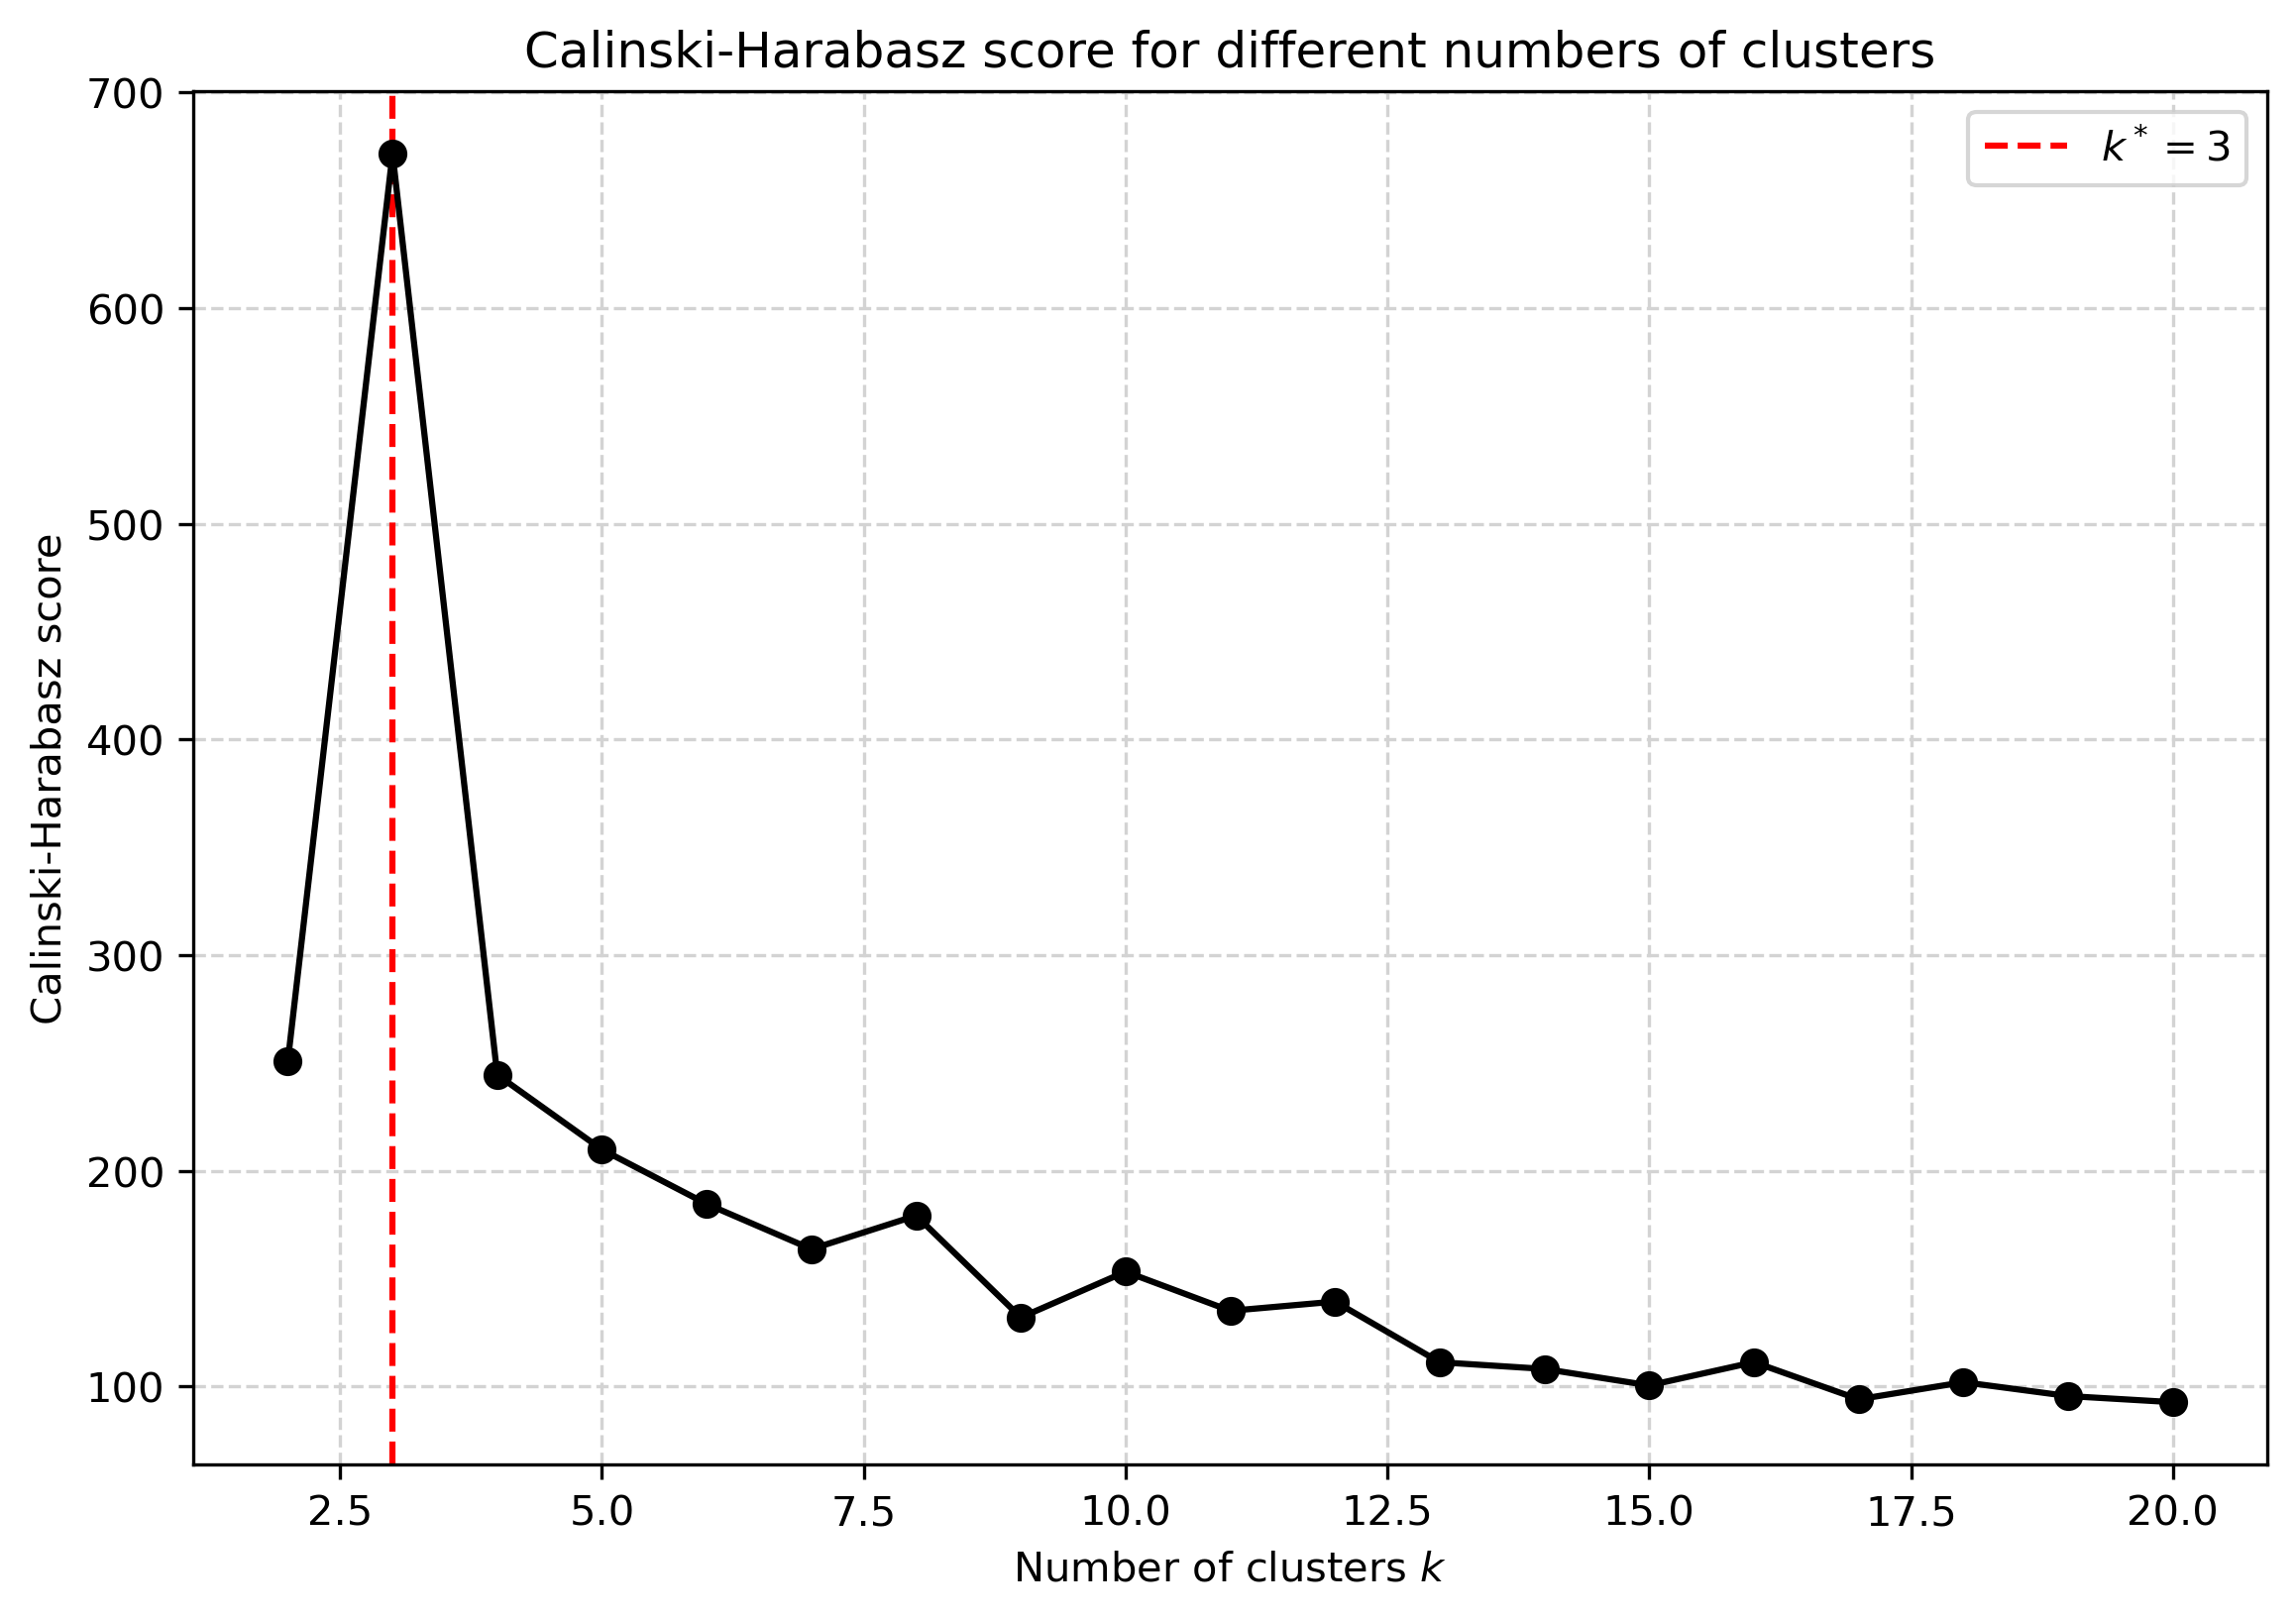

In [1073]:
max_k = k_range[np.argmax(k_scores)]


plt.axvline(max_k, color="red", linestyle="--", label=f"$k^* = {max_k}$")
plt.plot(k_range, k_scores, color="black")
plt.scatter(k_range, k_scores, color="black", zorder=10)
plt.xlabel("Number of clusters $k$")
plt.ylabel("Calinski-Harabasz score")
plt.title("Calinski-Harabasz score for different numbers of clusters")
plt.legend()
plt.show()

In [1074]:
optimal_clustering = kmeans(gene_expressions, max_k, max_iter=100)[0]

In [1075]:
# compute size of each cluster
cluster_sizes = np.bincount(optimal_clustering)
# print the size of each cluster
for i in range(max_k):
    print(f"Cluster {i}: {cluster_sizes[i]}")

Cluster 0: 151
Cluster 1: 507
Cluster 2: 142


2.1.2

In [1076]:
def homogeneity_score(C, K):
    # C is the set of classes
    # K is the set of clusters
    N = len(C)
    unique_labels = set(C)
    unique_clusters = set(K)
    a = np.zeros((len(unique_labels), len(unique_clusters)))
    for label in unique_labels:
        for cluster in unique_clusters:
            a[label, cluster] = np.sum((C == label) & (K == cluster))

    relative_entropy = 0
    for cluster in unique_clusters:
        for label in unique_labels:
            if a[label, cluster] != 0:
                relative_entropy += (a[label, cluster] / N) * np.log(a[label, cluster] / np.sum(a[:, cluster]))
    
    entropy_classes = 0
    for label in unique_labels:
        if np.sum(a[label]) != 0:
            entropy_classes += (np.sum(a[label]) / N) * np.log(np.sum(a[label]) / N)

    return 1 - relative_entropy / entropy_classes

In [1077]:
h_score = homogeneity_score(types, optimal_clustering)
print(f"Homogeneity score for the optimal clustering with {max_k} clusters: {h_score}")

Homogeneity score for the optimal clustering with 3 clusters: 0.5244182077516244


#### 2.2 Graph-based analysis (20 marks)
2.2.1

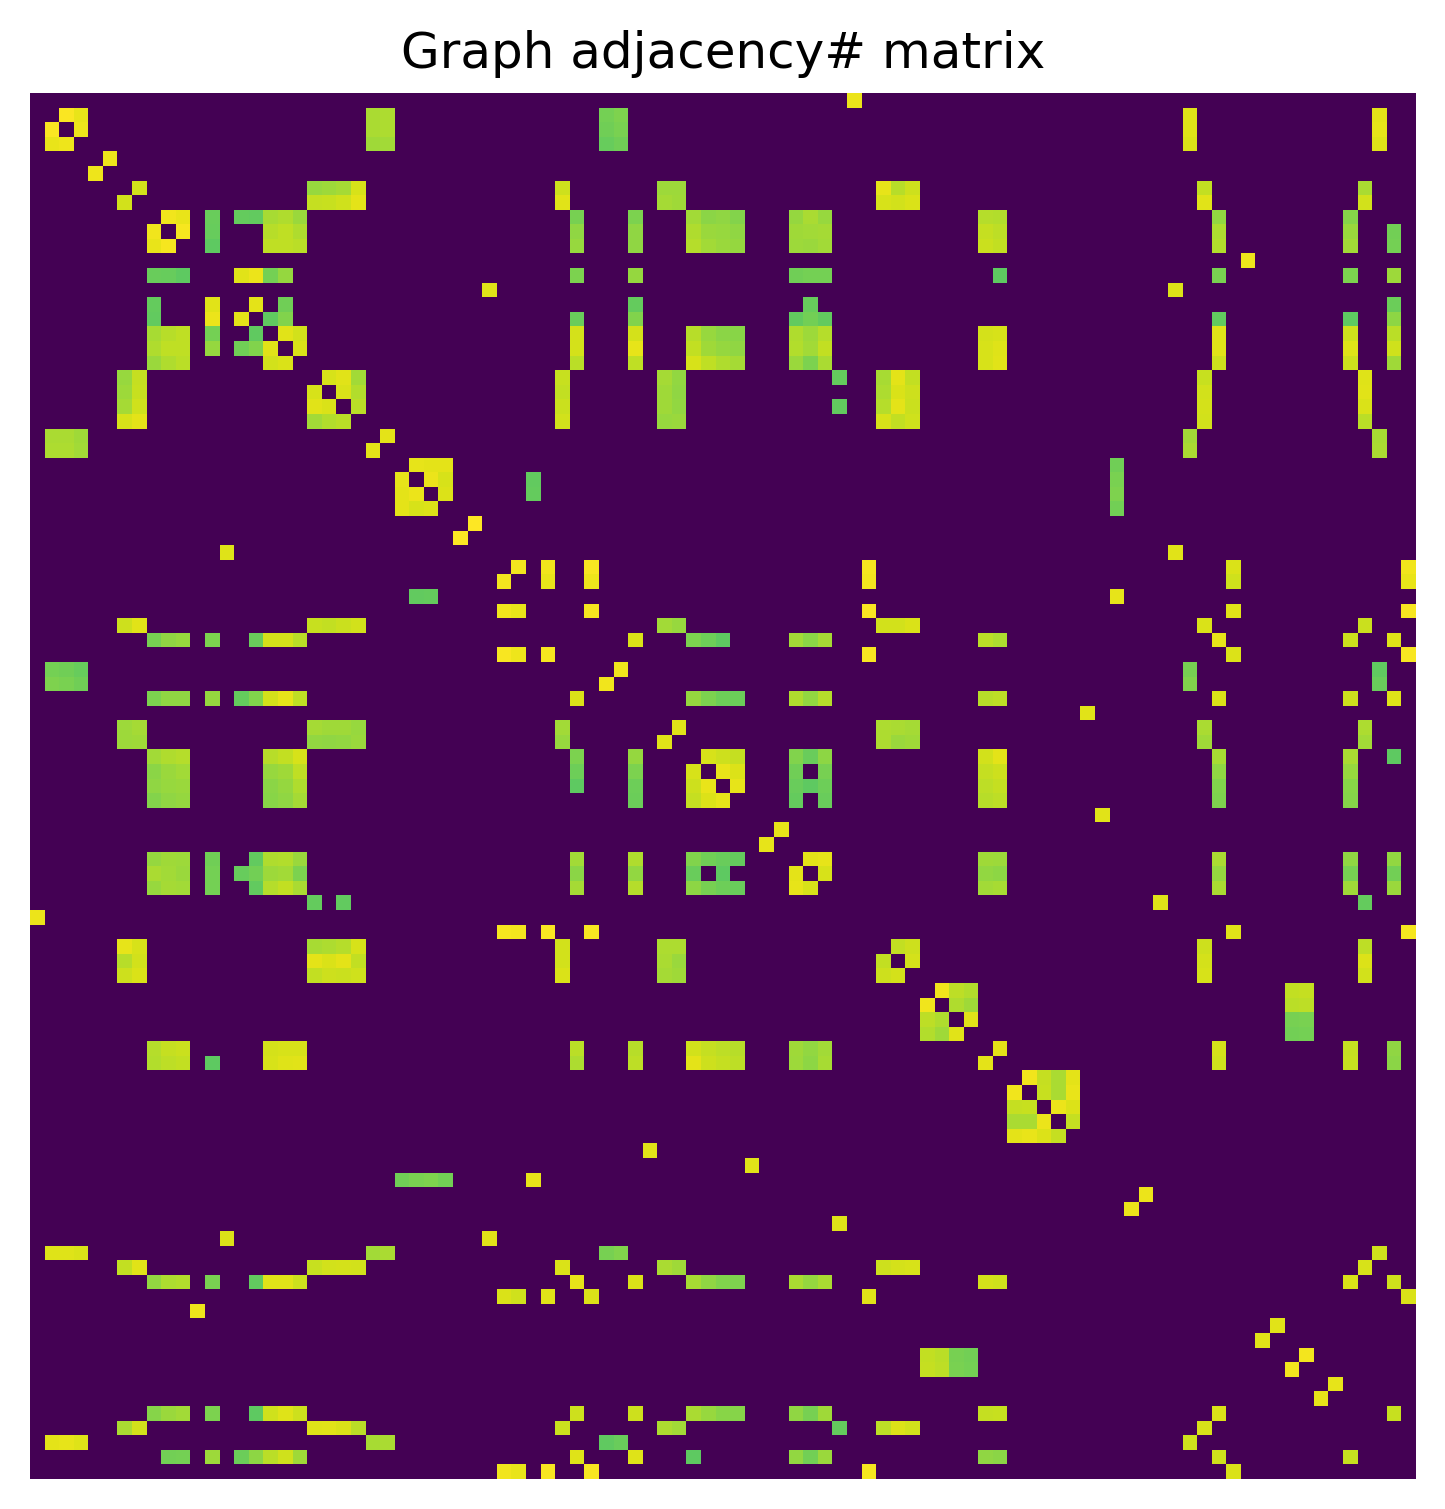

In [1078]:
# matrix of connected correlations between genes (columns)
A = np.corrcoef(gene_expressions.T)
# set to zero diagonal terms
A[np.diag_indices_from(A)] = 0
A[np.abs(A)<0.75] = 0

plt.imshow(A)
plt.title("Graph adjacency matrix")
# turn off axis and grid
plt.axis("off")
plt.grid(False)
plt.show()

2.2.2

In [1079]:
# compute degree centrality of each node
degree_centrality = np.sum(A, axis=0)
# sort genes in descending order of degree centrality
sorted_genes = np.argsort(degree_centrality)[::-1]
# print index of top 5 ranking genes
print(sorted_genes[:5])


[17 41 16 81 90]


2.2.3

In [1080]:
# compute laplacian matrix
D = np.diag(np.sum(A, axis=0))
L = D - A
# compute symmetric normalized laplacian
L_sym = np.linalg.inv(np.sqrt(D)) @ L @ np.linalg.inv(np.sqrt(D))
# compute eigenvalues and eigenvectors
eigs, eigvecs = np.linalg.eigh(L_sym)


In [1081]:
# find numerically zero eigenvalues
thresh= 1e-6
zero_eigs = np.where(np.abs(eigs) < thresh)[0]
# find the smallest nonzero eigenvalue
most_zero = max(zero_eigs)

In [1082]:
eigs_first = eigs[:most_zero]
eigs_second = eigs[most_zero+1:]

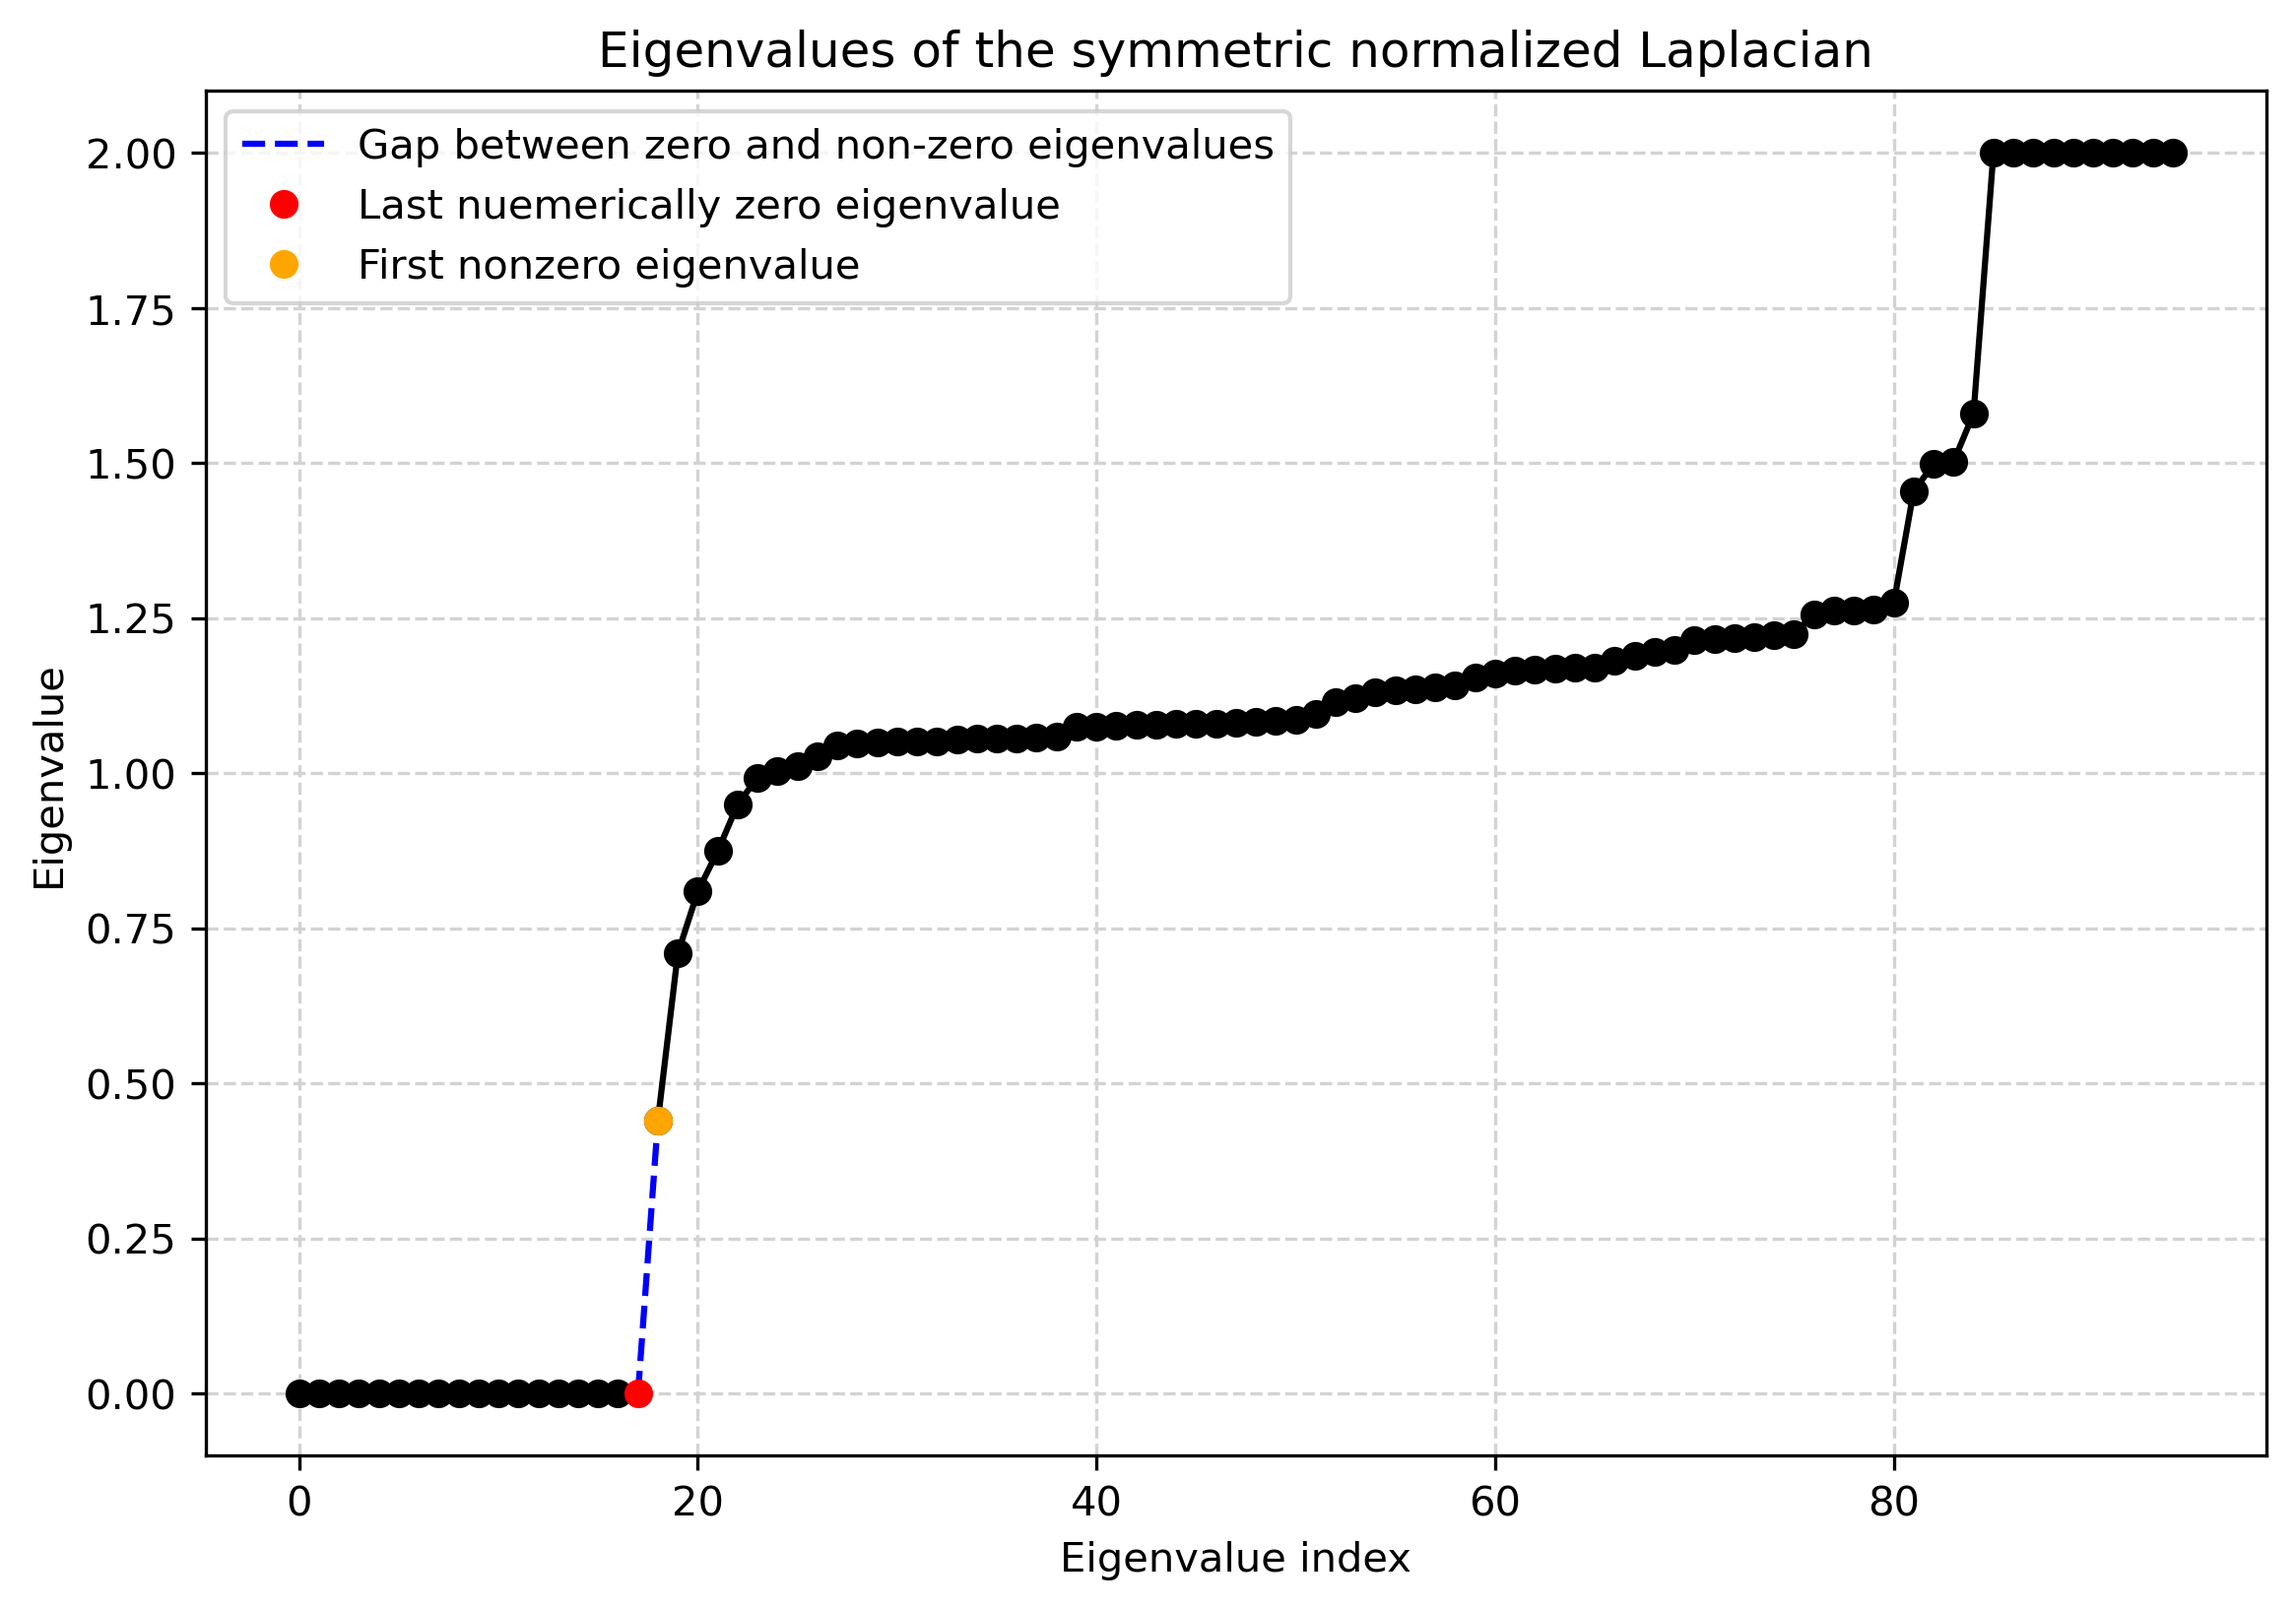

In [1083]:
plt.plot(eigs_first, color="black")
plt.plot([i+most_zero+1 for i in range(len(eigs_second))], eigs_second, color="black")
plt.scatter([i for i in range(len(eigs_first))], eigs_first, color="black")
plt.scatter([i+most_zero+1 for i in range(len(eigs_second))], eigs_second, color="black")
plt.plot([most_zero, most_zero+1], [eigs[most_zero], eigs[most_zero+1]], color="blue", label = "Gap between zero and non-zero eigenvalues", linestyle="--")
plt.plot(most_zero, eigs[most_zero], "o", color="r", label="Last nuemerically zero eigenvalue")
plt.plot(most_zero+1, eigs[most_zero+1], "o", color="orange", label="First nonzero eigenvalue")
plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of the symmetric normalized Laplacian")
plt.legend()
plt.show()



In [1084]:
r = most_zero + 1
print("Number numerically zero eigenvalues:", r)

Number numerically zero eigenvalues: 18


2.2.4

In [1085]:
U = eigvecs[:, :r]
T = U / np.linalg.norm(U, axis=1)[:, np.newaxis]
U.shape

(95, 18)

In [1086]:
kmeans(T, 3, max_iter=100)

(array([2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 2, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 2, 2, 2,
        2, 2, 1, 0, 0, 1, 2]),
 array([[ 2.93051117e-02,  7.51086793e-02, -4.65758488e-03,
          2.87618053e-02,  5.94064681e-02,  9.17943575e-02,
          1.13161172e-01, -1.72458697e-01, -1.28535509e-01,
          2.28376676e-02,  7.92088920e-02,  0.00000000e+00,
          1.94498018e-02, -8.38936452e-02,  4.63430695e-02,
         -2.44760251e-01, -1.17650921e-02, -8.96974821e-03],
        [ 3.93296343e-02,  7.95218489e-02, -3.22390496e-03,
         -7.16627029e-03,  8.47828935e-02, -9.52899151e-01,
          8.91531380e-02, -8.76743635e-09, -1.71410408e-01,
          1.00190718e-07,  1.10729960e-01,  0.00000000e+00,
         -4.03436037e-02,  1.80088397e-02, -1.51388749e-02,
         -1.

In [1087]:
# define function to compute normalised within cluster distance
def within_cluster_distance(X, labels, centroids):
    # compute distance of each point to its centroid
    clusters = []
    for i in set(labels):
        clusters.append(np.where((labels==i).astype(int)==1))
    nclusters = len(clusters)
    total_dist = 0
    for k in range(nclusters):
        for i in clusters[k][0]:
            for j in clusters[k][0]:
                dist = (np.linalg.norm(X[i] - X[j])**2)/len(clusters[k])
                total_dist += dist
    total_dist = total_dist/2
    return total_dist

test_c, test_m = kmeans(T, 5, max_iter=100)
within_cluster_distance(T, test_c, test_m)


2436.0

In [1116]:

# apply k means to T
T_k = []
k_range_T = [i for i in range(2, T.shape[0]//2)]
for k in k_range_T:
    score = score_k(T, k, within_cluster_distance, max_iter=100, n=10)
    T_k.append(score)
    print(f"Score for k={k}: {score}")

Score for k=2: 3975.2
Score for k=3: 2927.2
Score for k=4: 1963.2
Score for k=5: 1317.2
Score for k=6: 943.6
Score for k=7: 699.4
Score for k=8: 556.0
Score for k=9: 423.0
Score for k=10: 326.4
Score for k=11: 338.2
Score for k=12: 191.8
Score for k=13: 202.2
Score for k=14: 178.0
Score for k=15: 117.6
Score for k=16: 95.2
Score for k=17: 107.8
Score for k=18: 72.2
Score for k=19: 75.6
Score for k=20: 57.6
Score for k=21: 65.4
Score for k=22: 54.8
Score for k=23: 44.4
Score for k=24: 36.2
Score for k=25: 30.399999999999995
Score for k=26: 30.0
Score for k=27: 38.99999999999999
Score for k=28: 24.39999999999999
Score for k=29: 16.4
Score for k=30: 26.799999999999994
Score for k=31: 13.2
Score for k=32: 20.2
Score for k=33: 11.6
Score for k=34: 22.4
Score for k=35: 13.999999999999996
Score for k=36: 16.79999999999999
Score for k=37: 10.799999999999997
Score for k=38: 8.399999999999995
Score for k=39: 7.599999999999996
Score for k=40: 5.599999999999997
Score for k=41: 5.999999999999997
Sc

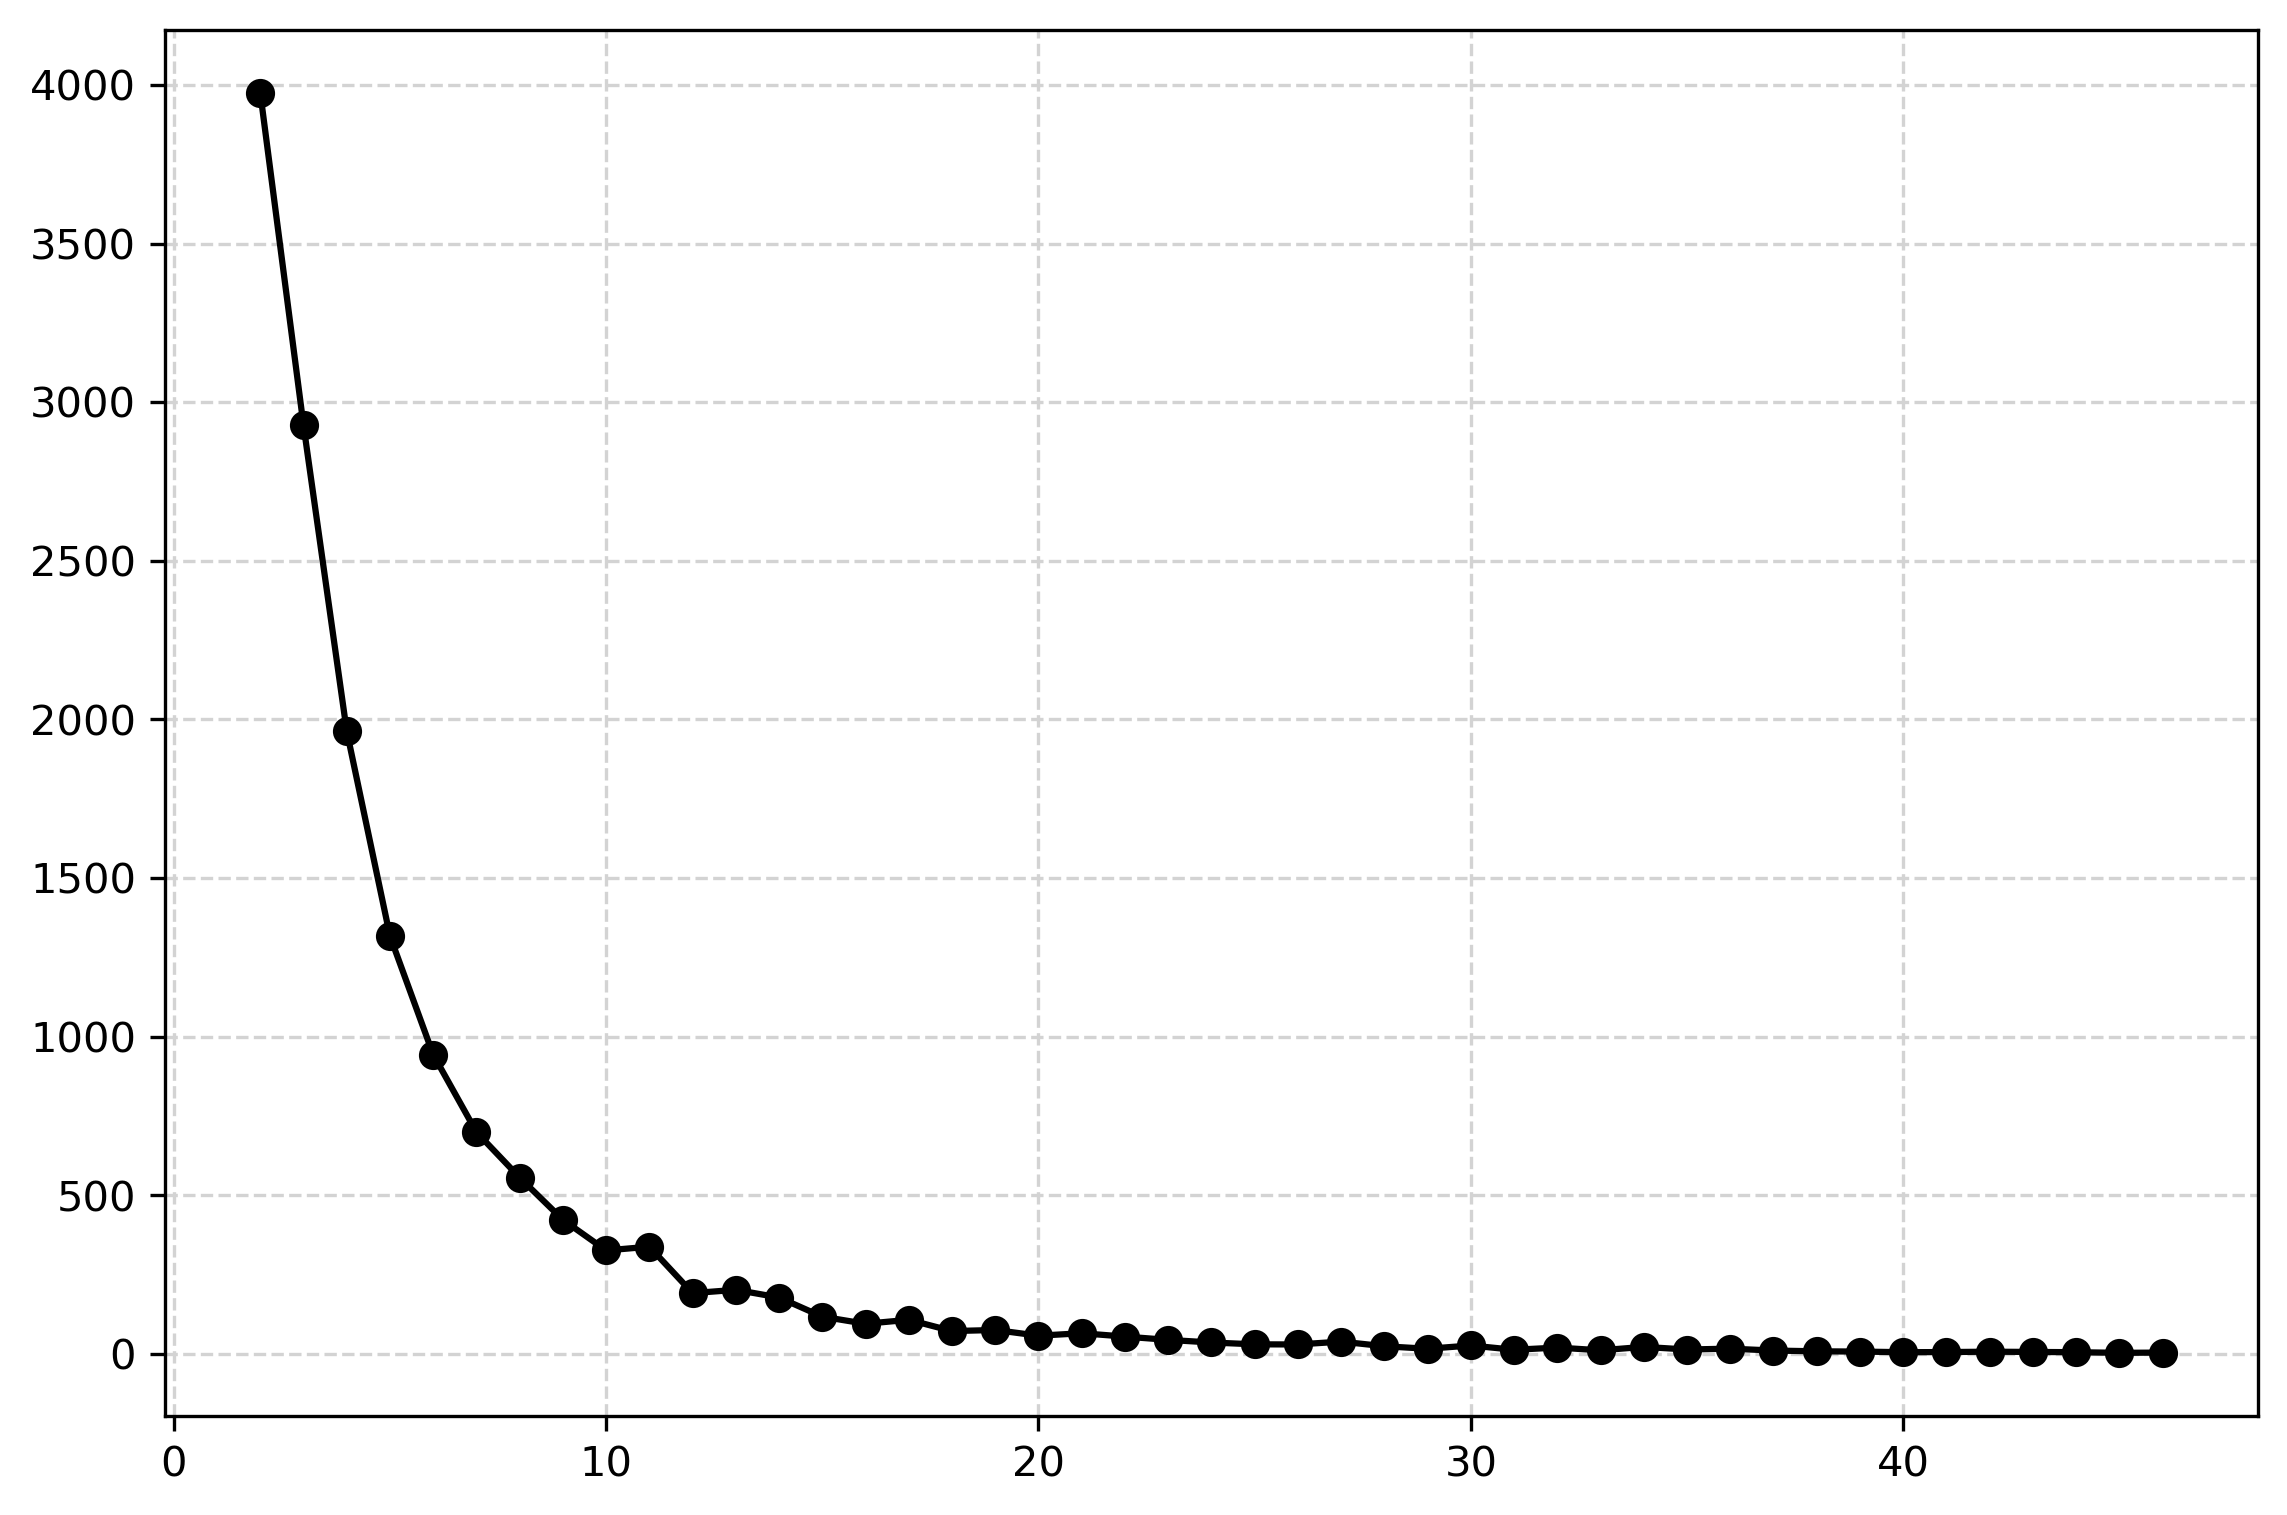

In [1117]:
plt.plot(k_range_T, T_k, color="black")

plt.scatter(k_range_T, T_k, color="black")

In [1099]:
k_elbow = 10
clustering_elbow = kmeans(T, k_elbow, max_iter=100)[0]

2.2.5

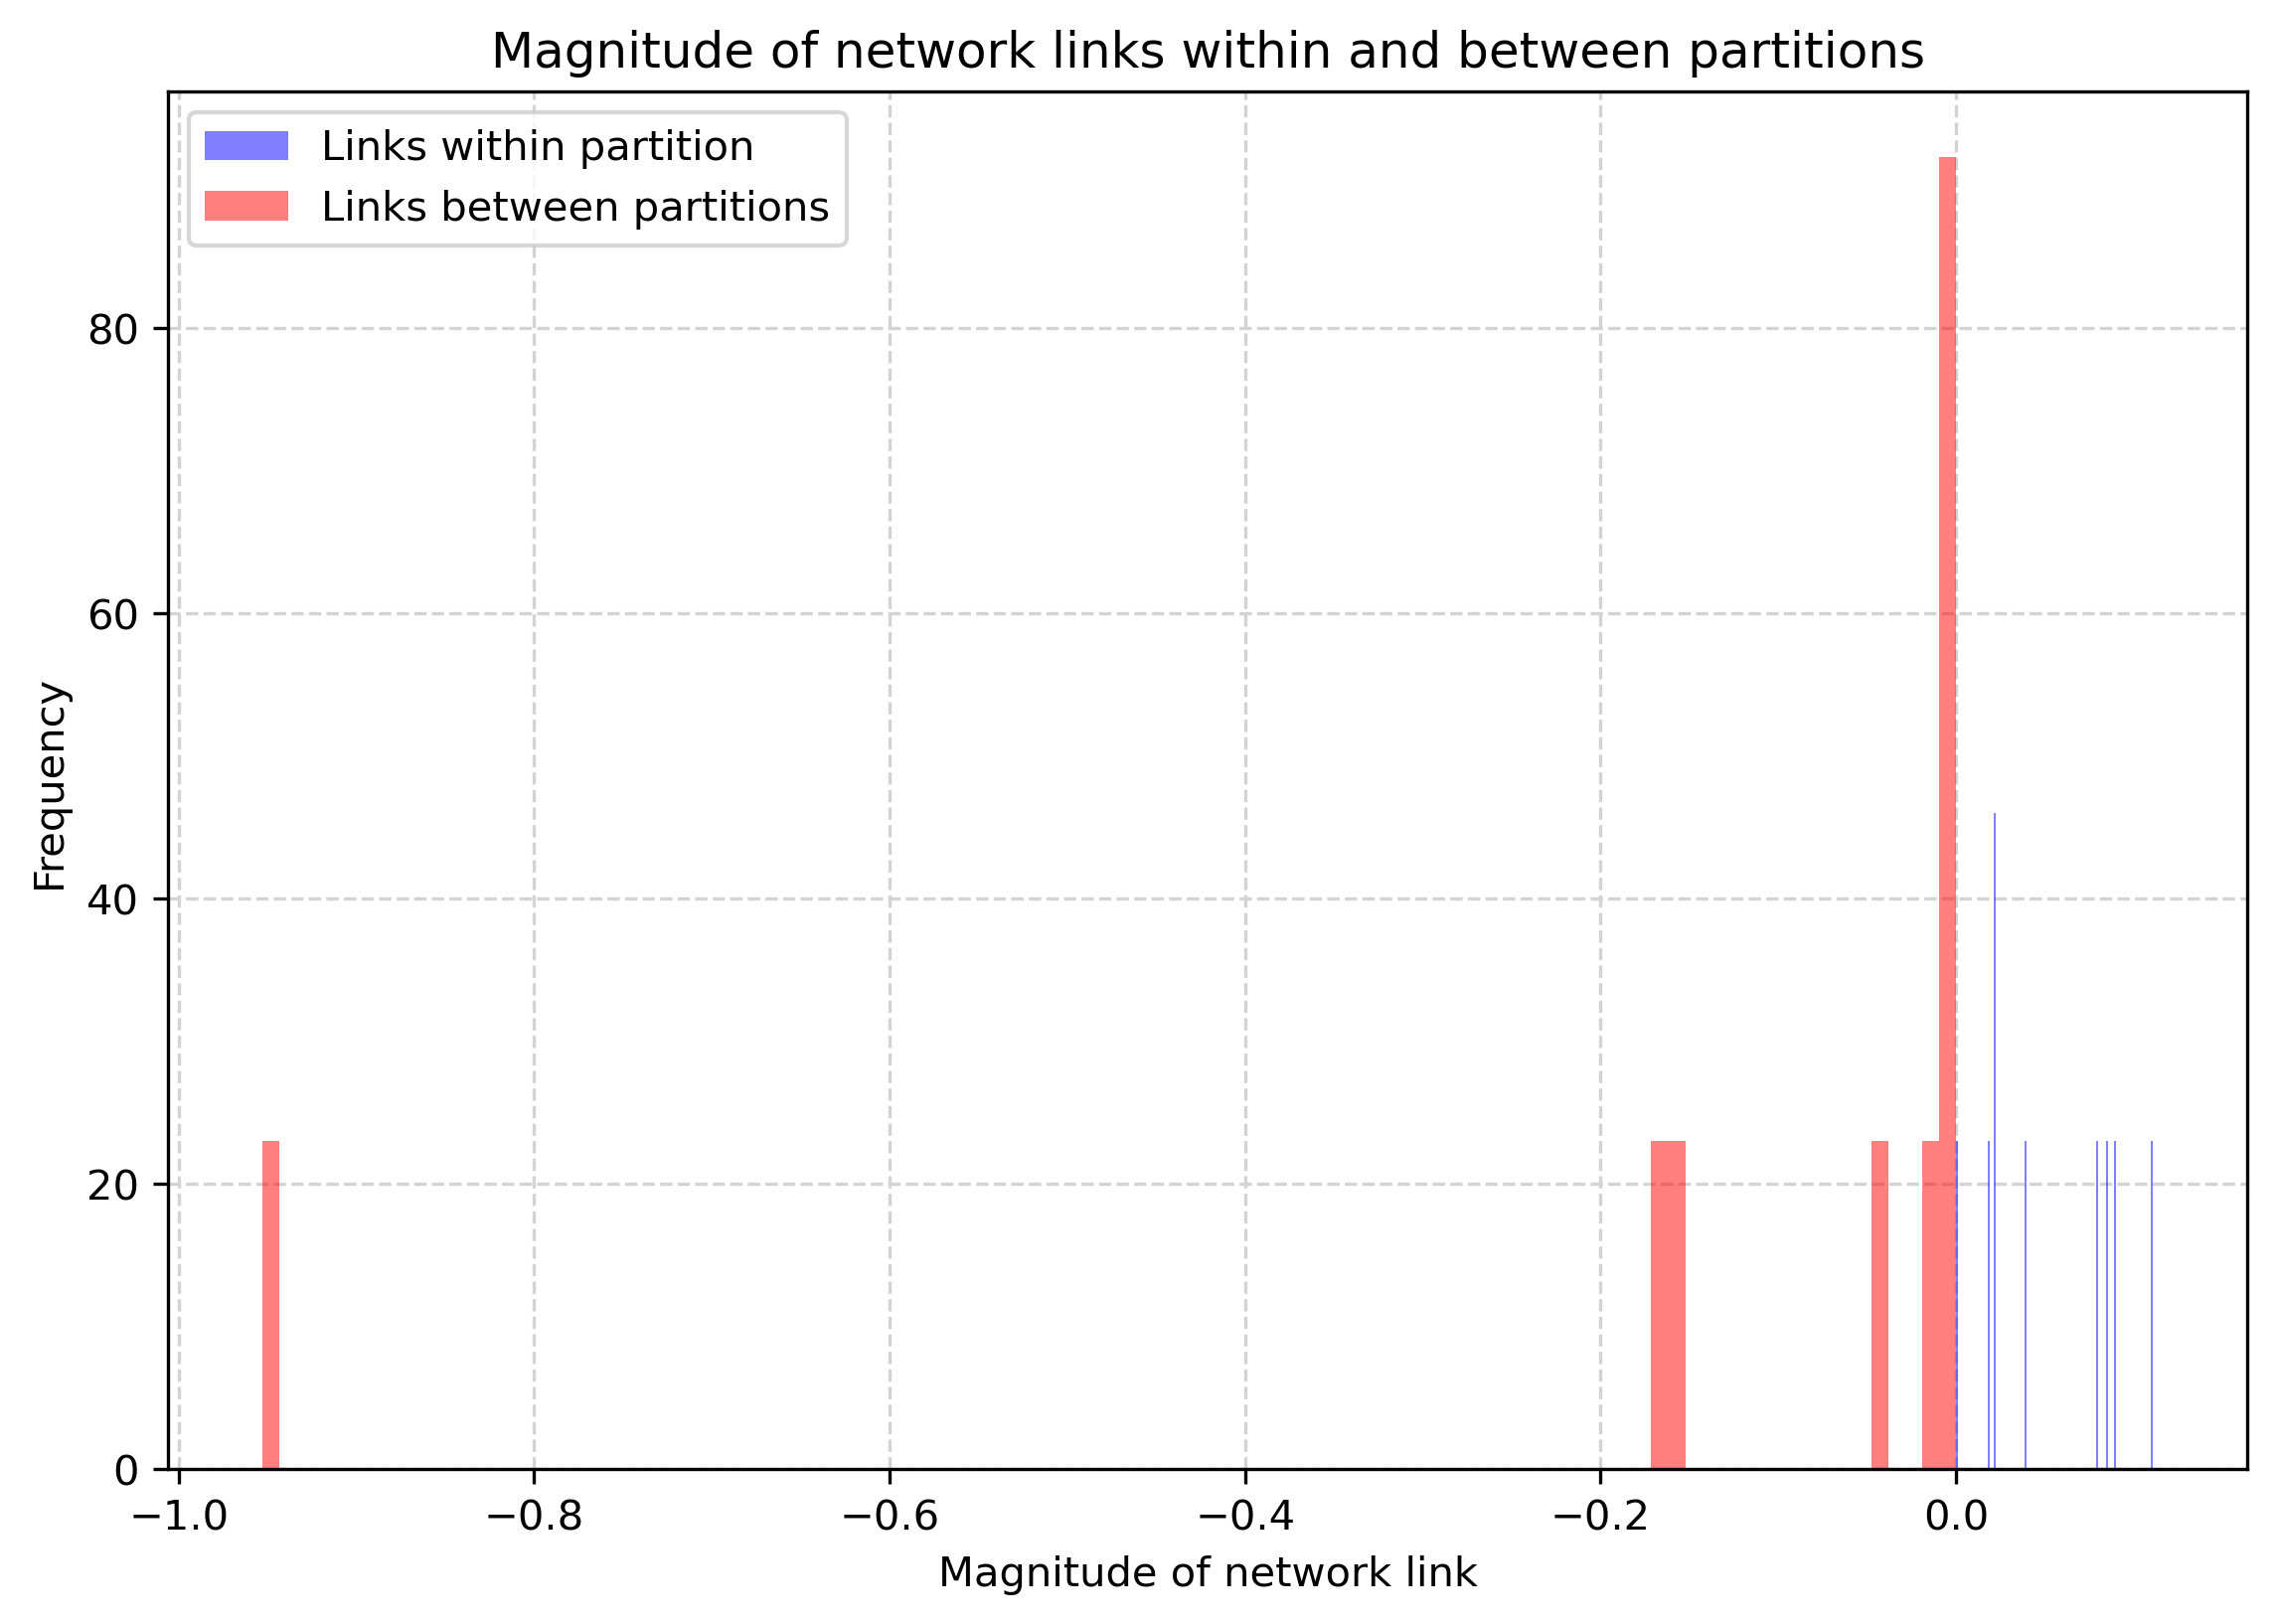

In [1112]:
# find biggest cluster
cluster_sizes = np.bincount(clustering_elbow)
biggest_cluster_val = np.argmax(cluster_sizes)
# cluster subset of T
T[clustering_elbow == biggest_cluster_val]
# perform spectral partitioning on the biggest cluster
T_biggest = T[clustering_elbow == biggest_cluster_val]
# derive binary partition of the subgraph
T_biggest_binary = T_biggest > 0
T_biggest_one = T_biggest[T_biggest_binary]
T_biggest_zero = T_biggest[~T_biggest_binary]
# visualise magnitude of network links within each partition and between partitions
plt.hist(T_biggest_one, bins=100, color="blue", label="Links within partition", alpha=0.5)
plt.hist(T_biggest_zero, bins=100, color="red", label="Links between partitions", alpha=0.5)
plt.xlabel("Magnitude of network link")
plt.ylabel("Frequency")
plt.title("Magnitude of network links within and between partitions")
plt.legend()
plt.show()

2.2.6

In [1115]:
# compute degree centrality of subgraph
degree_centrality_biggest = np.sum(T_biggest_binary, axis=0)

array([23, 23,  0,  0, 23,  0, 23,  0,  0, 23, 23,  0,  0, 23,  0,  0, 23,
       23])